In [86]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logit
from scipy.stats import norm

import tensorflow as tf
from keras import layers, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR
import torch.autograd.profiler as profiler

from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

import sys
import time
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [87]:
def calculate_metrics(model, data_tensor, labels_tensor, batch_size=1024, num_features=22):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for start_idx in range(0, len(data_tensor), batch_size):
            end_idx = min(start_idx + batch_size, len(data_tensor))
            inputs = data_tensor[start_idx:end_idx].view(-1, num_features)
            labels = labels_tensor[start_idx:end_idx]

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

In [88]:
class CustomDataLoader:
    def __init__(self, features, labels, validation_size=0.2, random_state=42, task_type="classification"):
        self.task_type = task_type
        
        if validation_size > 0.0:
            stratify = labels if task_type == "classification" else None
            train_data, val_data, train_labels, val_labels = train_test_split(
                features, labels, test_size=validation_size, stratify=stratify, random_state=random_state
            )
            
            self.val_data_tensor = torch.tensor(val_data).float().to(device)
            
            if task_type == "classification":
                self.val_labels_tensor = torch.tensor(val_labels).long().to(device)

            else:
                self.val_labels_tensor =torch.tensor(val_labels).float().to(device)
        else:
            train_data, train_labels = features, labels
            self.val_data_tensor, self.val_labels_tensor = None, None
        
        self.train_data_tensor = torch.tensor(train_data).float().to(device)

        if task_type == "classification":
            self.train_labels_tensor = torch.tensor(train_labels).long().to(device)
        else:
            self.train_labels_tensor = torch.tensor(train_labels).float().to(device)

        torch.manual_seed(random_state)
        indices = torch.randperm(len(self.train_data_tensor))

        self.train_data_tensor = self.train_data_tensor[indices]
        self.train_labels_tensor = self.train_labels_tensor[indices]

In [89]:
def evaluate_model(model, custom_train_loader, criterion, optimizer, num_epochs, scheduler, batch_size=1024, num_features=22):
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        model.train()
        i = 0
        total_loss = 0
        num_items = 0
        for start_idx in range(0, len(custom_train_loader.train_data_tensor), batch_size):
            end_idx = min(start_idx + batch_size, len(custom_train_loader.train_data_tensor))
            inputs = custom_train_loader.train_data_tensor[start_idx:end_idx].view(-1, num_features)
            labels = custom_train_loader.train_labels_tensor[start_idx:end_idx]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels, model)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * len(labels)
            total_loss += loss.item() * len(labels)
            num_items += len(labels)

            i += 1
            # if i % 10 == 0:
            #     print(total_loss / num_items)
            #     total_loss = 0
            #     num_items = 0

        if epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                print("Learning Rate:", param_group['lr'])
                
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for start_idx in range(0, len(custom_train_loader.val_data_tensor), batch_size):
                    end_idx = min(start_idx + batch_size, len(custom_train_loader.val_data_tensor))
                    val_inputs = custom_train_loader.val_data_tensor[start_idx:end_idx].view(-1, num_features)
                    val_labels = custom_train_loader.val_labels_tensor[start_idx:end_idx]
    
                    val_outputs = model(val_inputs)
                    val_loss += criterion.regular_loss(val_outputs, val_labels).item() * len(val_labels)
    
            avg_train_loss = running_loss / len(custom_train_loader.train_data_tensor)
            avg_val_loss = val_loss / len(custom_train_loader.val_data_tensor)
    
            train_accuracy, train_f1 = calculate_metrics(model, custom_train_loader.train_data_tensor, custom_train_loader.train_labels_tensor, batch_size, num_features)
            val_accuracy, val_f1 = calculate_metrics(model, custom_train_loader.val_data_tensor, custom_train_loader.val_labels_tensor, batch_size, num_features)
    
            print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
            print(f'Training Accuracy: {train_accuracy}, Training F1 Score: {train_f1}')
            print(f'Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}')
            print()


In [90]:
class CustomLoss(nn.Module):
    def __init__(self, criterion, l1_lambda=0.0, l2_lambda=0.0, f1_lambda=0.0, f2_lambda=0.0):
        super(CustomLoss, self).__init__()
        self.criterion = criterion
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.f1_lambda = f1_lambda
        self.f2_lambda = f2_lambda

    def forward(self, outputs, labels, model):
        l1_norm = sum(
            p.abs().sum()
            for name, module in model.named_modules()
            if isinstance(module, nn.Linear)
            for p in module.parameters()
            if "bias" not in name
        )
        l1_loss = self.l1_lambda * l1_norm

        l2_norm = sum(
            p.pow(2.0).sum()
            for name, module in model.named_modules()
            if isinstance(module, nn.Linear)
            for p in module.parameters()
            if "bias" not in name
        )
        l2_loss = self.l2_lambda * l2_norm

        f1_loss = 0
        f2_loss = 0
        for name, module in model.named_modules():
            if isinstance(module, LearnableActivation):
                interp_tensor = module.interp_tensor

                f1_diff = interp_tensor[:, 1:] - interp_tensor[:, :-1]
                f1_loss += self.f1_lambda * f1_diff.abs().sum()

                f2_diff = f1_diff[:, 1:] - f1_diff[:, :-1]
                f2_loss += self.f2_lambda * f2_diff.abs().sum()

        return self.criterion(outputs, labels) + l1_loss + l2_loss + f1_loss + f2_loss

    def regular_loss(self, outputs, labels):
        return self.criterion(outputs, labels)

In [91]:
class CustomLoss(nn.Module):
    def __init__(self, criterion, l1_lambda=0.0, l2_lambda=0.0, f1_lambda=0.0, f2_lambda=0.0):
        super(CustomLoss, self).__init__()
        self.criterion = criterion
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.f1_lambda = f1_lambda
        self.f2_lambda = f2_lambda

    def forward(self, outputs, labels, model): 
        return self.criterion(outputs, labels)
        
        l1_norm = sum(
            p.abs().sum()
            for name, module in model.named_modules()
            if isinstance(module, nn.Linear)
            for p in module.parameters()
            if "bias" not in name
        )
        l1_loss = self.l1_lambda * l1_norm

        l2_norm = sum(
            p.pow(2.0).sum()
            for name, module in model.named_modules()
            if isinstance(module, nn.Linear)
            for p in module.parameters()
            if "bias" not in name
        )
        l2_loss = self.l2_lambda * l2_norm

        f1_loss = 0
        f2_loss = 0
        for name, module in model.named_modules():
            if isinstance(module, LearnableActivation):
                interp_tensor = module.interp_tensor

                f1_diff = interp_tensor[:, 1:] - interp_tensor[:, :-1]
                f1_loss += self.f1_lambda * f1_diff.abs().sum()

                f2_diff = f1_diff[:, 1:] - f1_diff[:, :-1]
                f2_loss += self.f2_lambda * f2_diff.abs().sum()

        return self.criterion(outputs, labels) + l1_loss + l2_loss + f1_loss + f2_loss

    def regular_loss(self, outputs, labels):
        return self.criterion(outputs, labels)


In [92]:
import torch
import torch.nn as nn

class LearnableActivation(nn.Module):
    def __init__(self, num_features, width=10, density=1, init_to_zero=False):
        super(LearnableActivation, self).__init__()
        self.num_features = num_features
        self.width = width
        
        self.density = density
        self.init_to_zero = init_to_zero

        num_control_points = width * density + 1
        range_values = torch.linspace(-width / 2, width / 2, num_control_points)

        self.register_buffer("feature_idx", torch.arange(self.num_features).view(1, -1))
        self.location = self.width * self.density / 2
        self.max_index = self.width * self.density

        if init_to_zero:
            self.interp_tensor = nn.Parameter(torch.zeros(num_features, num_control_points))
        else:
            self.interp_tensor = nn.Parameter(range_values.repeat(num_features, 1))
            
    def forward(self, x):
        scaled_x = (x * self.density) + self.location

        lower_idx = torch.clamp(scaled_x.long(), min=0, max=self.max_index - 1)
        upper_idx = lower_idx + 1

        lower_value = self.interp_tensor[self.feature_idx, lower_idx]
        upper_value = self.interp_tensor[self.feature_idx, upper_idx]

        interpolation_weight = scaled_x - lower_idx.float()
        return torch.lerp(lower_value, upper_value, interpolation_weight)

    def extend_features(self, extra_features):
        num_control_points = self.width * self.density + 1
        range_values = torch.linspace(-self.width / 2, self.width / 2, num_control_points)

        new_interp_tensor = None
        if self.init_to_zero:
            new_interp_tensor = torch.zeros(extra_features, num_control_points)
        else:
            new_interp_tensor = range_values.repeat(extra_features, 1)

        self.interp_tensor = nn.Parameter(torch.cat([self.interp_tensor.data, new_interp_tensor], dim=0))

        self.num_features += extra_features
        self.feature_idx = torch.arange(self.num_features).view(1, -1).to(self.feature_idx.device)

In [93]:
# X_1 = np.linspace(-5, 5, 1000 * 1000 * 10)
# X_2 = np.linspace(-5, 5, 1000 * 1000 * 10)

# np.random.shuffle(X_1)
# np.random.shuffle(X_2)

In [94]:
# y = np.cos(X_1) * np.cos(X_2)
# y = X_1**2 * (1 / (1 + np.exp(-X_2))) * X_2
# y = np.tanh(X_1) * np.tanh(X_2)
# y = (np.cos(X_1) + np.cos(X_2)) ** 2
# y = np.log(1 + np.exp(X_1 * X_2)) - (1 / (1 + np.exp(X_1 * X_2)))
# y = np.log(1 + np.exp(X_1 ** 2)) * (1 / (1 + np.exp(X_2 ** 2)))
# y = np.cos(X_1) * np.tanh(X_2)
# y = X_1 * np.log(1 + np.exp(-X_2))
# y = X_1 * X_2
# y = np.sin(X_1**2 - X_2**2) * np.exp(-(X_1**2 + X_2**2) / 10)
# y = np.sqrt(X_1 ** 2 + X_2 ** 2) * 1 / (1 + np.exp(-X_1))
# y = np.log(1 + np.exp(-X_1)) * np.tanh(X_2) + np.sin(X_1)

In [95]:
# X = np.column_stack((X_1, X_2))
# x_scaled = X

# print(X.shape)

# x_scaler = StandardScaler()
# x_scaled = x_scaler.fit_transform(X)

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

In [96]:
data = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
data = data.dropna()

print(data.columns)

"""
data = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
data = pd.read_csv('/kaggle/input/forest-cover-type-dataset/covtype.csv')

X = data[[
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]]

X = data[['radius_worst', 'concave points_worst']]
X = data.drop(["id", "diagnosis", "Unnamed: 32"], axis=1)
y = data["diagnosis"]

X = data.drop(["Cover_Type"], axis=1)
y = data["Cover_Type"]

"""

X = data.drop(["loan_status"], axis=1)
y = data["loan_status"]

X = pd.get_dummies(X, drop_first=True)
for col in X.columns:
    if (X[col] > 0).all():
        X[col] = np.log(X[col])

print(X.shape, y.shape)
print(X.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')
(28638, 22) (28638,)
Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y'],
      dtype='object')


In [97]:
data_dl = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
data_og = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

data_dl = data_dl.drop(["id"], axis=1)
data_og['person_emp_length'] = data_og['person_emp_length'].fillna(data_og['person_emp_length'].mean())
data_og['loan_int_rate'] = data_og['loan_int_rate'].fillna(data_og['loan_int_rate'].mean())

data_dl['source'] = 0
data_og['source'] = 1

data = pd.concat([data_dl, data_og], ignore_index=True)

grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
data['loan_grade'] = data['loan_grade'].map(grade_mapping)

# purpose_mapping = {
#     'DEBTCONSOLIDATION': 1,
#     'HOMEIMPROVEMENT': 2,
#     'MEDICAL': 3,
#     'PERSONAL': 4,
#     'EDUCATION': 5,
#     'VENTURE': 6
# }
# data['loan_intent'] = data['loan_intent'].map(purpose_mapping)

home_ownership_mapping = {
    'OWN': 1,
    'MORTGAGE': 2,
    'OTHER': 3,
    'RENT': 4
}
data['person_home_ownership'] = data['person_home_ownership'].map(home_ownership_mapping)

print(data.columns)
print(data.isnull().sum())

X = data.drop(["loan_status"], axis=1)
X['loan_percent_income_ratio'] = (X['person_income'] / X['loan_amnt'])
X['loan_to_income_ratio'] = X['loan_amnt'] / X['person_income']
X['financial_burden'] = X['loan_amnt'] * X['loan_int_rate']
X['loan_int_emp_interaction'] = X['loan_int_rate'] * X['person_emp_length']
X['debt_to_credit_ratio'] = X['loan_amnt'] / X['cb_person_cred_hist_length']

y = data["loan_status"]

exclude_columns = [
    "loan_percent_income_ratio",
    "loan_to_income_ratio",
    "financial_burden",
    "debt_to_credit_ratio"
]

X = pd.get_dummies(X, drop_first=True)

column_to_log = [
    'person_age',
    'person_income',
    # 'loan_int_rate', improved without log
    'cb_person_cred_hist_length',
    'loan_percent_income_ratio',
    'financial_burden',
    'debt_to_credit_ratio'
]

column_to_sqrt = [
    'person_emp_length', # improved a bit wihout sqrt but skewness reduction here is high so take sqrt
    # 'loan_amnt', improved a bit without sqrt
    'loan_percent_income',
    # 'loan_to_income_ratio', improved substantially without sqrt
    'loan_int_emp_interaction',
]

for col in column_to_log:
    if (X[col] <= 0).any():
        print(f"Column '{col}' contains non-positive values. Adding 1 to avoid log of non-positive numbers.")
        X[col] = np.log(X[col] + 1)
    else:
        X[col] = np.log(X[col])

for col in column_to_sqrt:
    if (X[col] < 0).any():
        print(f"Column '{col}' contains negative values. Setting negative values to NaN before applying sqrt.")
        X[col] = np.sqrt(X[col].clip(lower=0))
    else:
        X[col] = np.sqrt(X[col])

print(X.shape, y.shape)
print(X.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'source'],
      dtype='object')
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
source                        0
dtype: int64
(91226, 21) (91226,)
Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length', 'source',
       'loan_percent_income_ratio', 'loan_to_income

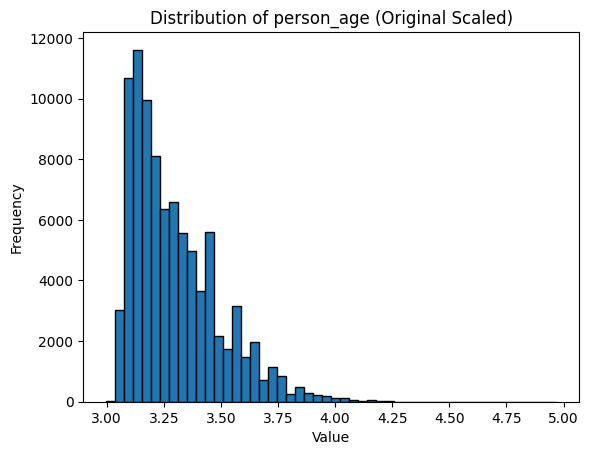

person_age - Min: 2.995732273553991, Max: 4.969813299576001
person_age - Skewness (Original): 1.1963776374885764


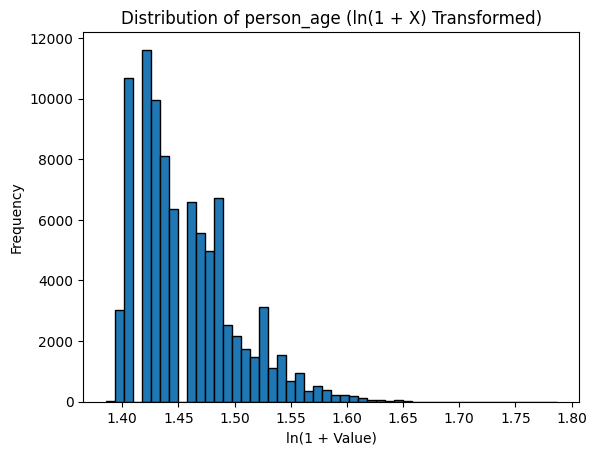

person_age - Skewness (ln(1 + X) Transformed): 1.0597049120194657


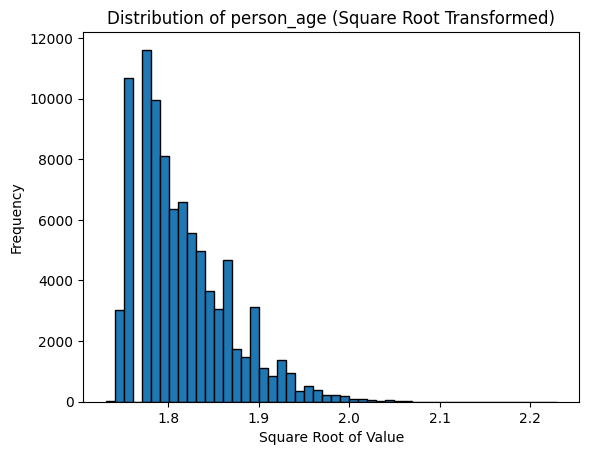

person_age - Skewness (Square Root Transformed): 1.1067432357483333


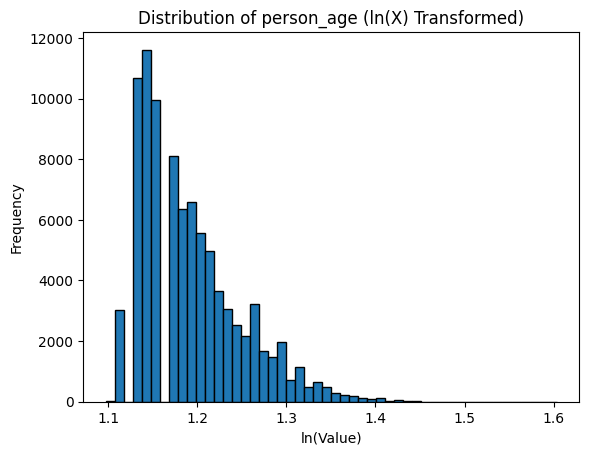

person_age - Skewness (ln(X) Transformed): 1.0229275641618563


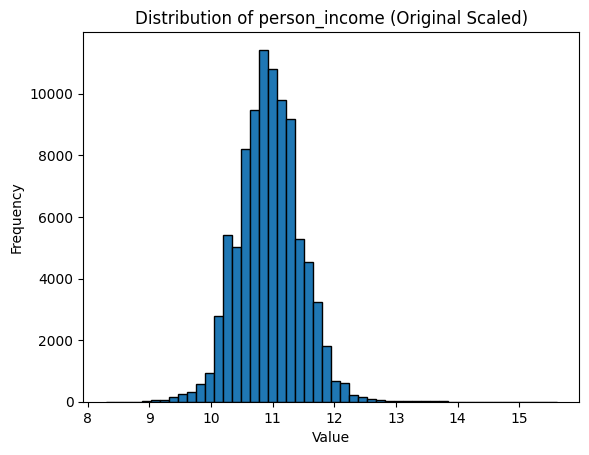

person_income - Min: 8.294049640102028, Max: 15.607270027192328
person_income - Skewness (Original): 0.17110289730558728


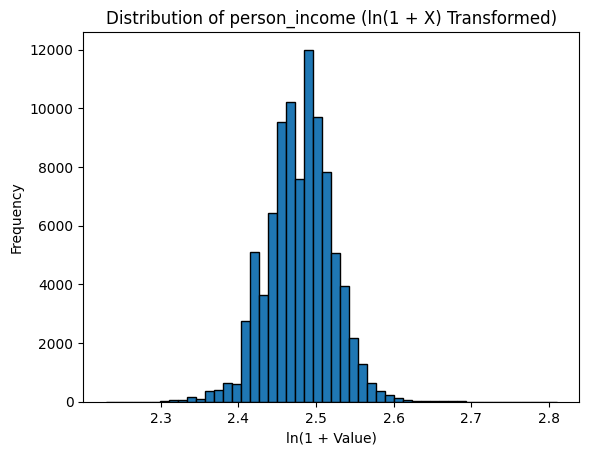

person_income - Skewness (ln(1 + X) Transformed): -0.023334493187727092


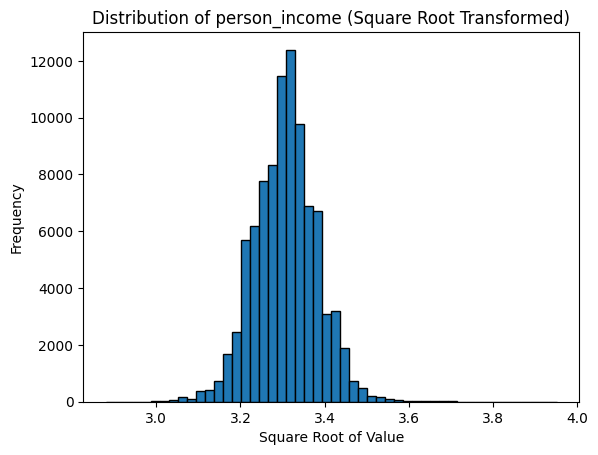

person_income - Skewness (Square Root Transformed): 0.0641525279046015


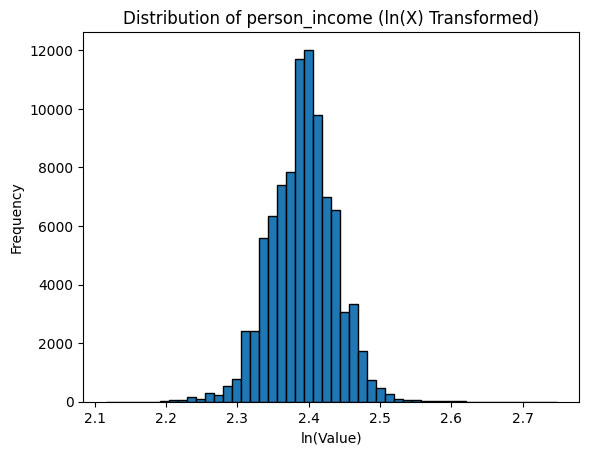

person_income - Skewness (ln(X) Transformed): -0.04080035102558139


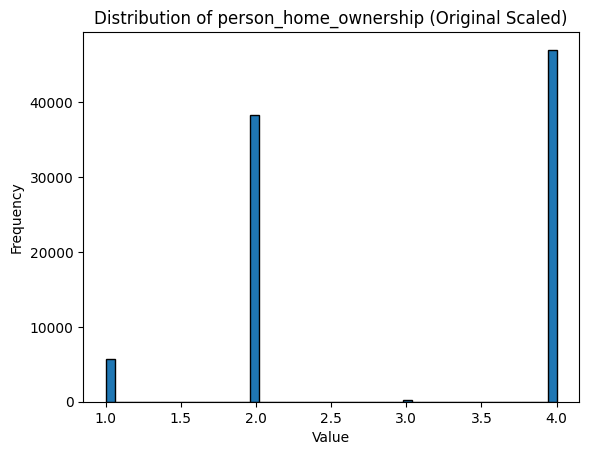

person_home_ownership - Min: 1.0, Max: 4.0
person_home_ownership - Skewness (Original): -0.23365571415948036


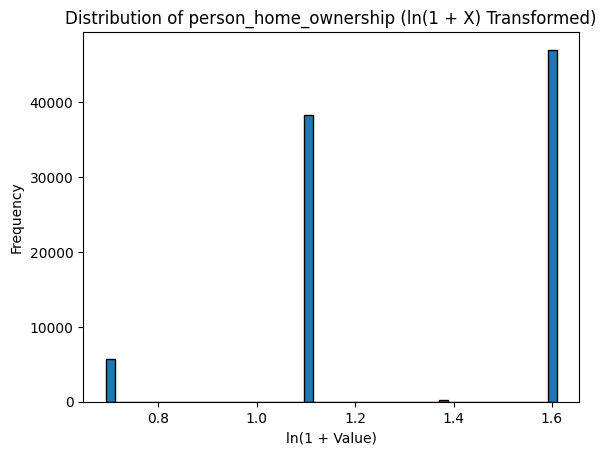

person_home_ownership - Skewness (ln(1 + X) Transformed): -0.4606938547780195


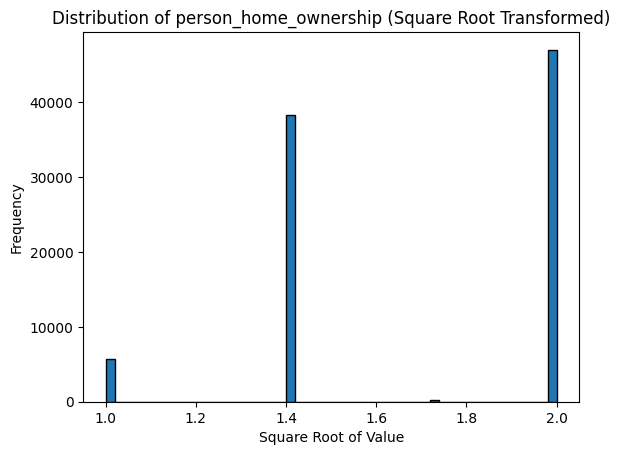

person_home_ownership - Skewness (Square Root Transformed): -0.38680789969696344


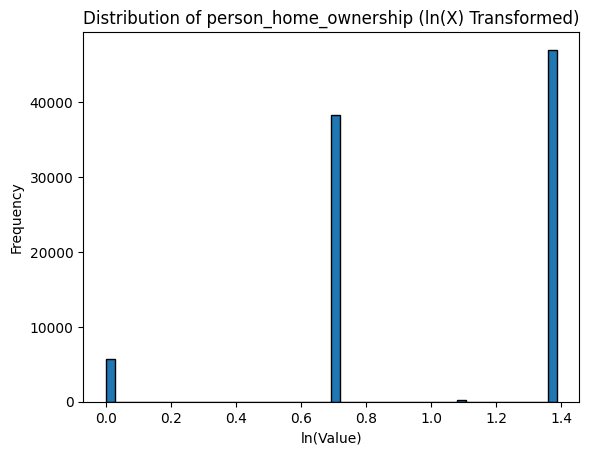

person_home_ownership - Skewness (ln(X) Transformed): -0.6515563064306374


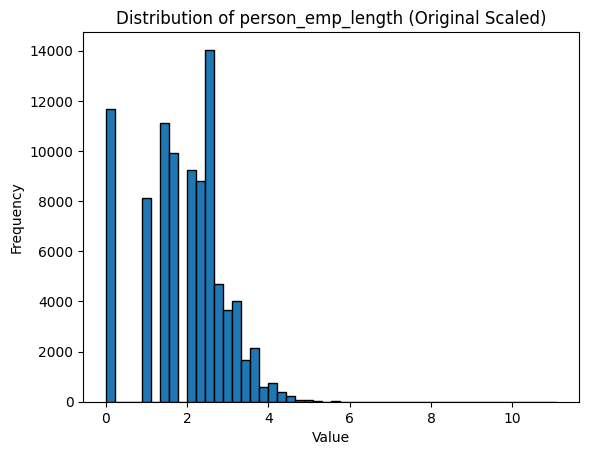

person_emp_length - Min: 0.0, Max: 11.090536506409418
person_emp_length - Skewness (Original): -0.2152654541406268


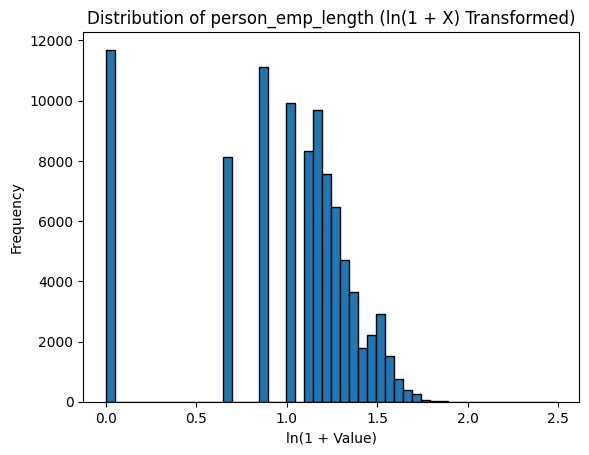

person_emp_length - Skewness (ln(1 + X) Transformed): -1.159101203434821



KeyboardInterrupt



In [98]:
x_scaled_df = pd.DataFrame(X, columns=X.columns)
x_scaled_df = x_scaled_df.astype(float)

num_bins = 50  # Make number of bins a variable

for column in x_scaled_df.columns:
    data = x_scaled_df[column]
    
    plt.figure()
    plt.hist(data, bins=num_bins, edgecolor='black')
    plt.title(f'Distribution of {column} (Original Scaled)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    
    print(f"{column} - Min: {data.min()}, Max: {data.max()}")
    original_skewness = data.skew()
    print(f"{column} - Skewness (Original): {original_skewness}")
    
    ln1p_transformed = np.log1p(data)
    plt.figure()
    plt.hist(ln1p_transformed, bins=num_bins, edgecolor='black')
    plt.title(f'Distribution of {column} (ln(1 + X) Transformed)')
    plt.xlabel('ln(1 + Value)')
    plt.ylabel('Frequency')
    plt.show()
    
    ln1p_skewness = ln1p_transformed.skew()
    print(f"{column} - Skewness (ln(1 + X) Transformed): {ln1p_skewness}")
    
    sqrt_transformed = np.sqrt(data.clip(lower=0))
    plt.figure()
    plt.hist(sqrt_transformed, bins=num_bins, edgecolor='black')
    plt.title(f'Distribution of {column} (Square Root Transformed)')
    plt.xlabel('Square Root of Value')
    plt.ylabel('Frequency')
    plt.show()
    
    sqrt_skewness = sqrt_transformed.skew()
    print(f"{column} - Skewness (Square Root Transformed): {sqrt_skewness}")
    
    non_positive = data[data <= 0]
    if non_positive.empty:
        ln_transformed = np.log(data)
        plt.figure()
        plt.hist(ln_transformed, bins=num_bins, edgecolor='black')
        plt.title(f'Distribution of {column} (ln(X) Transformed)')
        plt.xlabel('ln(Value)')
        plt.ylabel('Frequency')
        plt.show()
        
        ln_skewness = ln_transformed.skew()
        print(f"{column} - Skewness (ln(X) Transformed): {ln_skewness}")
    else:
        print(f"Skipping ln transformation for {column} due to negative or zero values.")

In [ ]:
"""
x_scaler = MinMaxScaler(feature_range=(-1, 1))
"""
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(x_scaled.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix

X = data.drop(["loan_status"], axis=1)
X['loan_percent_income_ratio'] = (X['person_income'] / X['loan_amnt'])
X['loan_to_income_ratio'] = X['loan_amnt'] / X['person_income']
X['financial_burden'] = X['loan_amnt'] * X['loan_int_rate']
X['loan_int_emp_interaction'] = X['loan_int_rate'] * X['person_emp_length']
X['debt_to_credit_ratio'] = X['loan_amnt'] / X['cb_person_cred_hist_length']

y = data["loan_status"]

exclude_columns = [
    "loan_percent_income_ratio",
    "loan_to_income_ratio",
    "financial_burden",
    "debt_to_credit_ratio"
]

X = pd.get_dummies(X, drop_first=True)

column_to_log = [
    'person_age',
    'person_income',
    # 'loan_int_rate', improved without log
    'cb_person_cred_hist_length',
    'loan_percent_income_ratio',
    'financial_burden',
    'debt_to_credit_ratio'
]

column_to_sqrt = [
    'person_emp_length', # improved a bit wihout sqrt but skewness reduction here is high so take sqrt
    # 'loan_amnt', improved a bit without sqrt
    'loan_percent_income',
    # 'loan_to_income_ratio', improved substantially without sqrt
    'loan_int_emp_interaction',
]

for col in column_to_log:
    if (X[col] <= 0).any():
        print(f"Column '{col}' contains non-positive values. Adding 1 to avoid log of non-positive numbers.")
        X[col] = np.log(X[col] + 1)
    else:
        X[col] = np.log(X[col])

for col in column_to_sqrt:
    if (X[col] < 0).any():
        print(f"Column '{col}' contains negative values. Setting negative values to NaN before applying sqrt.")
        X[col] = np.sqrt(X[col].clip(lower=0))
    else:
        X[col] = np.sqrt(X[col])

x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    x_scaled, y_encoded, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000, tol=0.0)
model.fit(X_train, y_train)

y_train_pred_proba = model.predict_proba(X_train)
y_test_pred_proba = model.predict_proba(X_test)

train_log_loss = log_loss(y_train, y_train_pred_proba)
validation_log_loss = log_loss(y_test, y_test_pred_proba)

print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Validation Log Loss: {validation_log_loss:.4f}")

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
validation_accuracy = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Model Coefficients:")
print(model.coef_)

print("Model Intercept:")
print(model.intercept_)

In [ ]:
logits = model.decision_function(x_scaled)

stacked_logits = np.stack([-logits, logits], axis=1)
quantiles_out = np.quantile(stacked_logits, q=np.linspace(0, 1, 43), axis=0).T
quantiles_out = quantiles_out[:, 1:-1]
quantiles_tensor_out = torch.tensor(quantiles_out, dtype=torch.float32)

print(quantiles_tensor_out)

In [ ]:
quantiles_tensor_out = torch.linspace(-0.01, 0.01, 41, dtype=torch.float32).unsqueeze(0)
print(quantiles_tensor_out.shape)

In [ ]:
feature_means = x_scaled.mean(axis=0)
feature_variances = x_scaled.var(axis=0)
feature_mins = x_scaled.min(axis=0)
feature_maxs = x_scaled.max(axis=0)

feature_stats_scaled_full = pd.DataFrame({
    'Mean': feature_means,
    'Variance': feature_variances,
    'Min': feature_mins,
    'Max': feature_maxs
})

print("Mean, Variance, Min, and Max of Scaled Features:")
print(feature_stats_scaled_full)

In [ ]:
quantiles = np.quantile(x_scaled, q=np.linspace(0, 1, 43), axis=0).T
quantiles = quantiles[:, 1:-1]
quantiles_tensor = torch.tensor(quantiles, dtype=torch.float32)

print(quantiles)

In [ ]:
# class TabularDenseNet(nn.Module):
#     def __init__(self, input_size, output_size, num_layers=2, width=10, density=1):
#         super(TabularDenseNet, self).__init__()
#         self.input_size = input_size
#         self.output_size = output_size
#         self.width = width
#         self.density = density
        
#         self.first_activation = LearnableActivation(self.input_size, self.width, self.density, init_to_zero=False)
#         self.second_activation = LearnableActivation(1, width * 4, density, init_to_zero=True)
#         self.trainable_param = nn.Parameter(torch.tensor([1.0, 0.0]), requires_grad=True)
#         self.grow = False
        
#     def forward(self, x):
#         x_1 = self.first_activation(x)
#         x = x_1.sum(dim=-1).unsqueeze(-1)
#         x = self.second_activation(x).sum(dim=-1) + (self.trainable_param * x_1).sum(dim=-1)
#         return x

#         # second then first
#         # if not self.grow:
#         #     x = x.sum(dim=-1).unsqueeze(-1)
#         #     return self.second_activation(x).sum(dim=-1)

#         # x = self.first_activation(x).sum(dim=-1).unsqueeze(-1)
#         # x = self.second_activation(x).sum(dim=-1)
#         # return x

#         # first then second
#         # if not self.grow:
#         #     return self.first_activation(x).sum(dim=-1)

#         # x = self.first_activation(x).sum(dim=-1).unsqueeze(-1)
#         # x = self.second_activation(x).sum(dim=-1)
#         # return x

#     def grow_network(self, width, density):
#         self.grow = True
#         # self.first_activation = LearnableActivation(self.input_size, self.width, self.density, init_to_zero=False)
#         self.second_activation = LearnableActivation(1, width, density, init_to_zero=False)

In [123]:
import torch
import torch.nn as nn

class CustomActivation(nn.Module):
    def __init__(self, num_features, control_points, init_identity=False, density=None, i=0):
        super(CustomActivation, self).__init__()
        self.a = nn.Parameter(torch.zeros(num_features, control_points))
        self.b = nn.Parameter(torch.zeros(num_features, control_points))

        middle_index = control_points // 2

        # with torch.no_grad():
        #     self.a[i, middle_index] = 1.0
        #     self.b[i, middle_index] = 1.0

        if init_identity:
            # self.a = nn.Parameter(2 * torch.rand(num_features, control_points) - 1)
            # self.b = nn.Parameter(2 * torch.rand(num_features, control_points) - 1)

            with torch.no_grad():
                self.a[:, middle_index] = 4 * torch.rand(self.a.shape[0]) - 2
                self.b[:, middle_index] = 4 * torch.rand(self.b.shape[0]) - 2

            # with torch.no_grad():
            #     self.a[i, middle_index] = 1.0
            #     self.b[i, middle_index] = 1.0

    def forward(self, x):
        return torch.where(x < 0, self.a * x, self.b * x)

In [124]:
# import torch
# import torch.nn as nn

# class CustomActivation(nn.Module):
#     def __init__(self, num_features, control_points, init_identity=False, density=1.0, i=None):
#         super(CustomActivation, self).__init__()
#         self.density = density
        
#         self.a = nn.Parameter(torch.zeros(num_features, control_points))

#         if init_identity:
#             self.b = nn.Parameter(torch.ones(num_features, control_points))
#         else:
#             self.b = nn.Parameter(torch.zeros(num_features, control_points))

#     def forward(self, x):
#         slopes = self.b - self.a
#         x_clamped = torch.clamp(x, min=-1 / self.density / 2, max=1 / self.density / 2)
#         return slopes * x_clamped

In [125]:
class TabularDenseNet(nn.Module):
    def __init__(self, input_size, output_size, num_layers=2, width=10, density=1):
        super(TabularDenseNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.width = width
        self.density = density

        self.activation_1 = CustomActivation(input_size, width * density + 1, init_identity=False, density=density, i=1)
        # self.register_buffer('bias_1', torch.linspace(-width / 2, width / 2, steps=width * density + 1).repeat(num_features, 1))
        self.bias_1 = torch.nn.Parameter(quantiles_tensor.clone())
        self.global_bias_1 = nn.Parameter(torch.zeros(1, num_features))

        width_factor = 20
        
        self.activation_2 = CustomActivation(1, width_factor * width * density + 1, init_identity=True, density=density)
        self.register_buffer('bias_2', torch.linspace(width_factor * -width / 2, width_factor * width / 2, steps=width_factor * width * density + 1).repeat(1, 1))
        # self.bias_2 = torch.nn.Parameter(quantiles_tensor_out.clone())
        self.global_bias_2 = nn.Parameter(torch.zeros(1, 1))
        
        self.grow = False
        self.fixed_random_number = nn.Parameter(2 * torch.rand(1) - 1)
        self.trainable_scale = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, x):
        x = x.unsqueeze(-1) + self.bias_1
        x = self.activation_1(x)
        x_1 = x.sum(dim=-1) + self.global_bias_1
        x = x_1.sum(dim=-1)
            
        x = x.unsqueeze(-1)
        
        x = x.unsqueeze(-1) + self.bias_2
        x = self.activation_2(x)
        x = x.sum(dim=-1) + self.global_bias_2
        x = x.sum(dim=-1)

        x = x * self.trainable_scale + self.fixed_random_number
        return torch.stack((x, -x), dim=1)

    def grow_network(self, width, density):
        self.grow = True

    def tensor_1(self, x):
        x = x.unsqueeze(-1) + self.bias_1
        x = self.activation_1(x)
        return x.sum(dim=-1) + self.global_bias_1

    def tensor_2(self, x):
        x = x.unsqueeze(-1) + self.bias_2
        x = self.activation_2(x)
        x = x.sum(dim=-1) + self.global_bias_2
        x = x.sum(dim=-1)
        return x

In [126]:
custom_train_loader = CustomDataLoader(x_scaled, y_encoded, validation_size=0.2, random_state=0, task_type="classification")

0


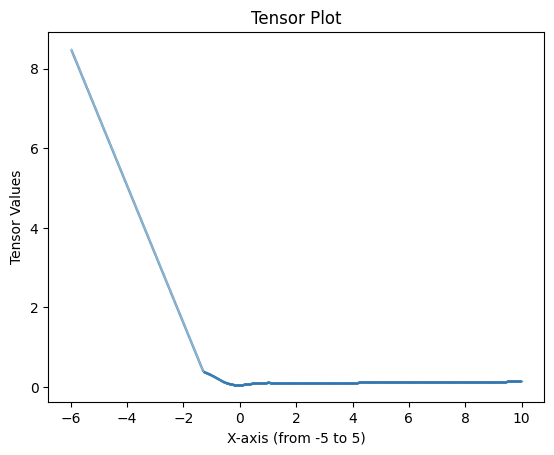

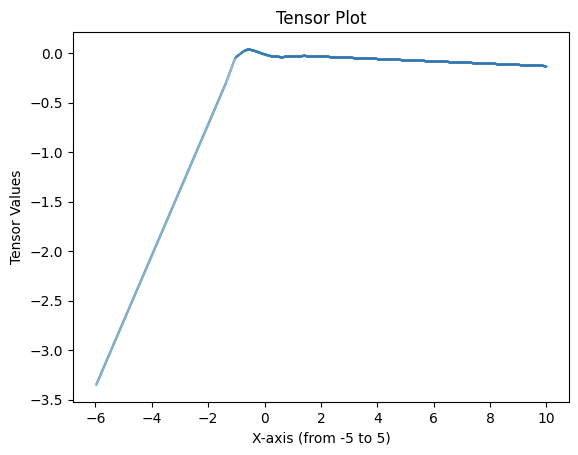

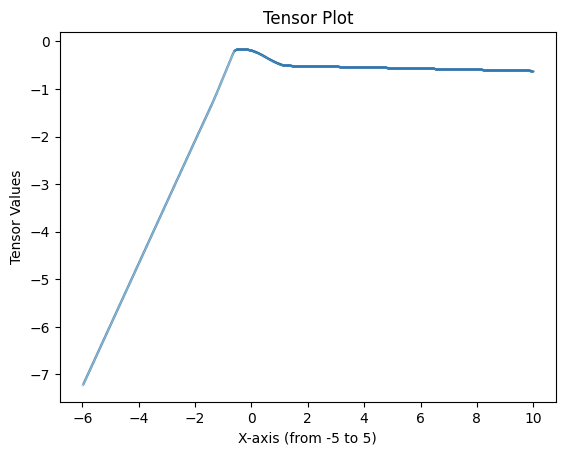

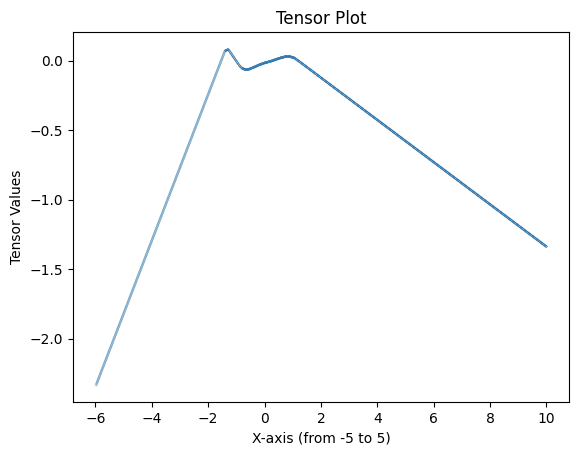

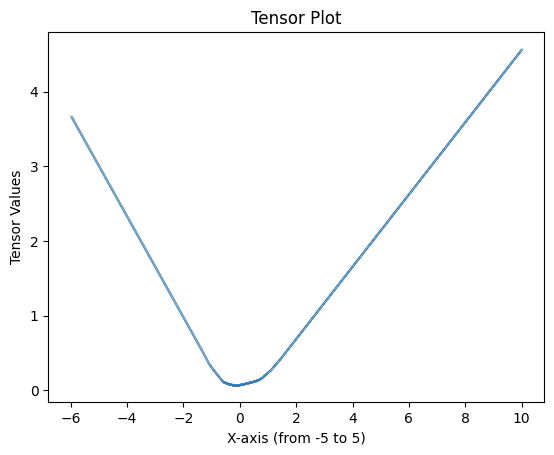

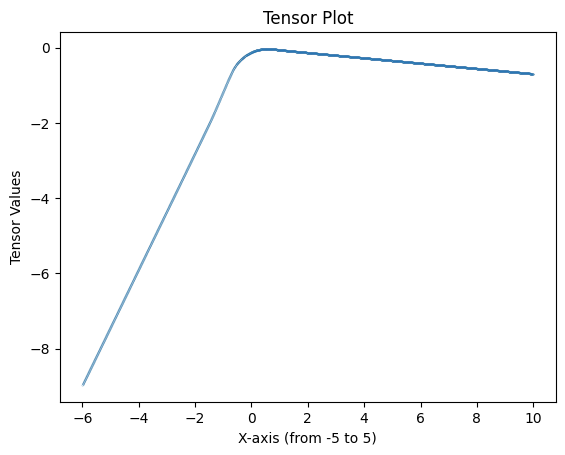

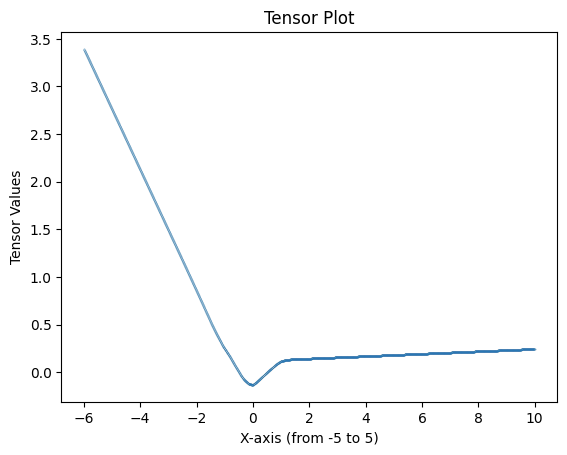

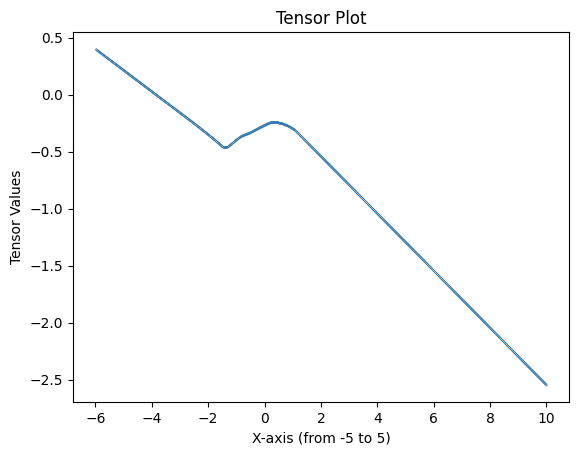

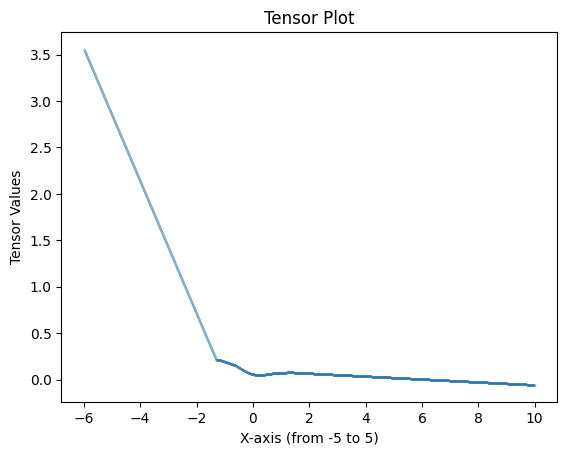

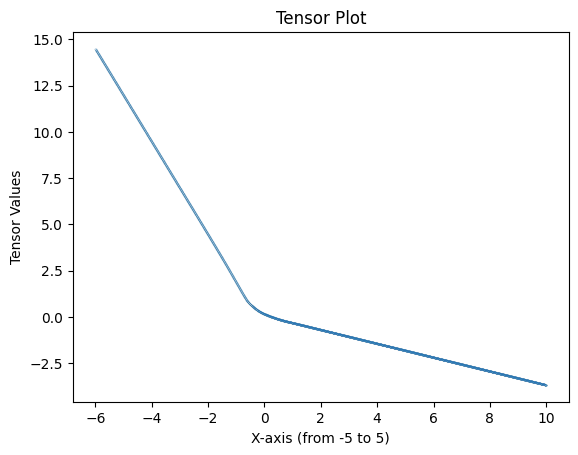

1


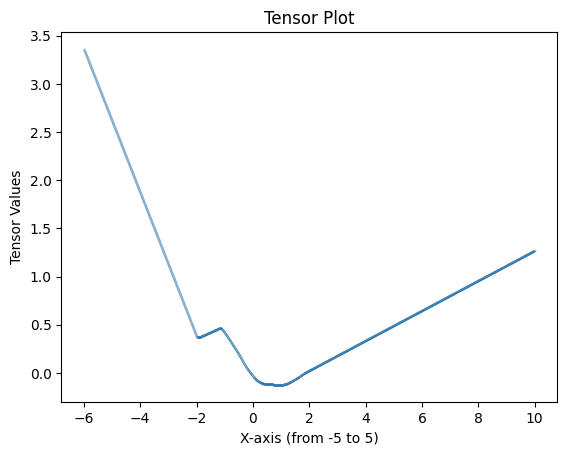

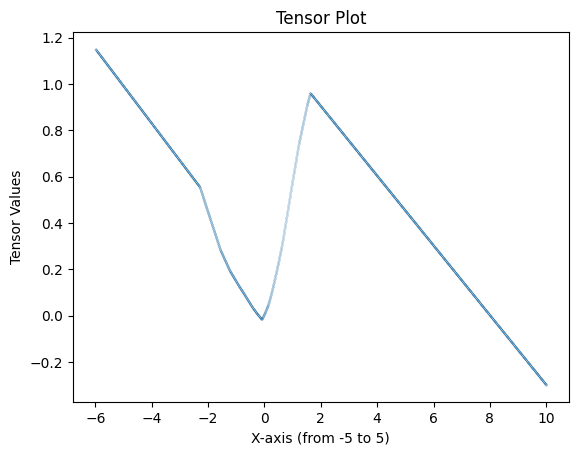

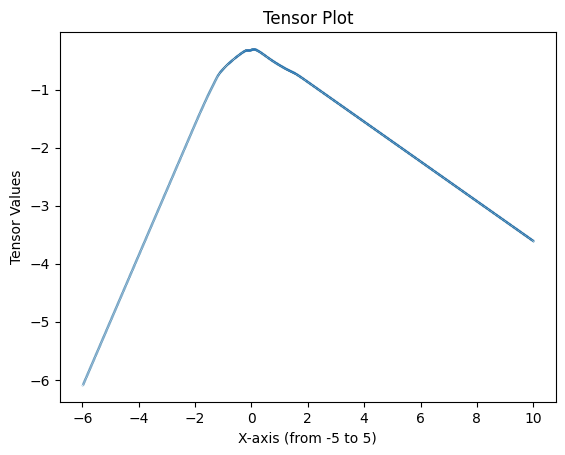

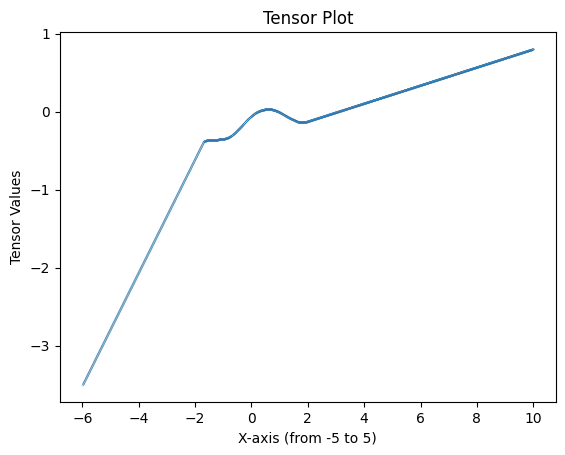

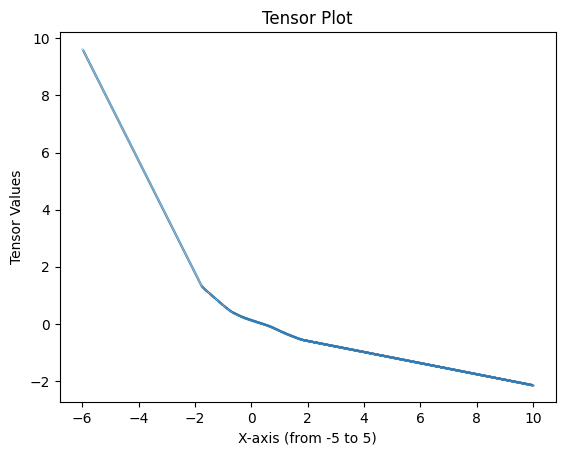

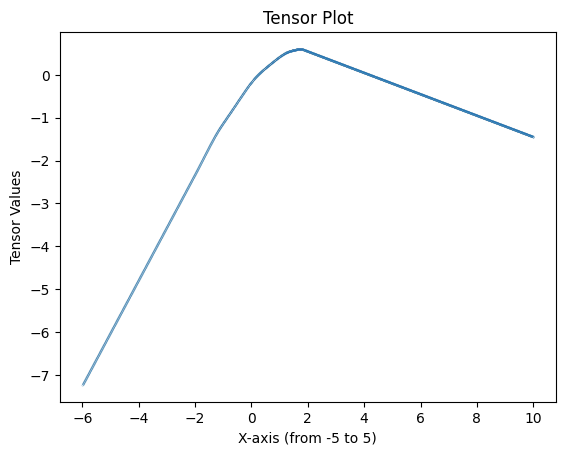

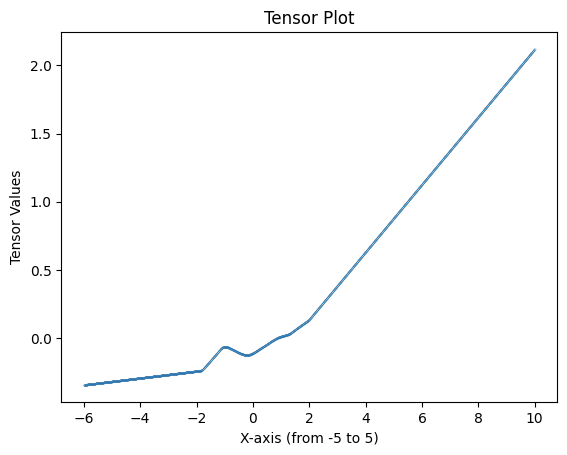

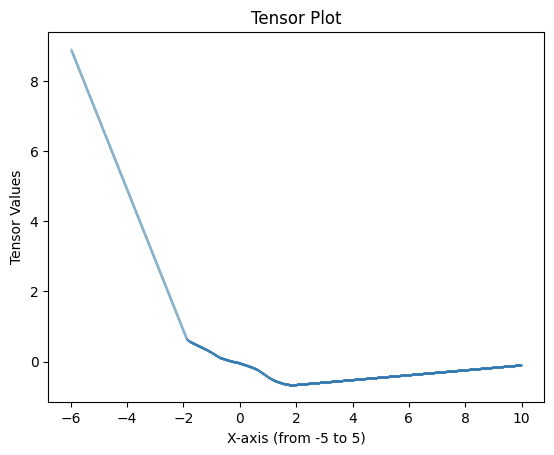

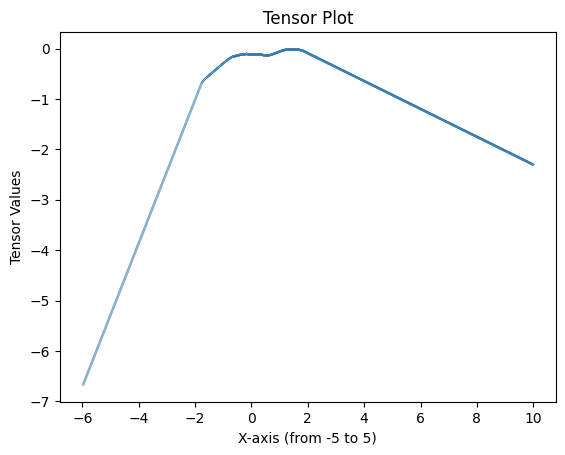

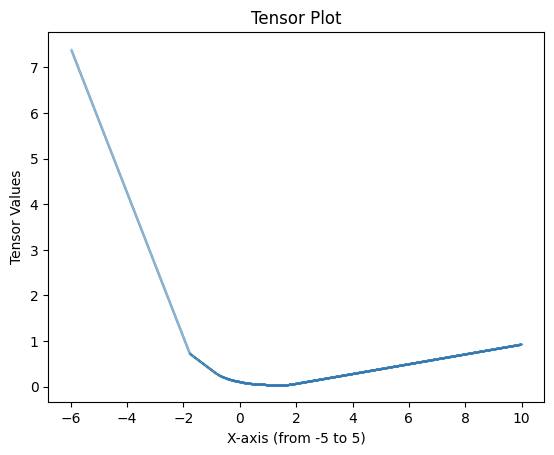

2


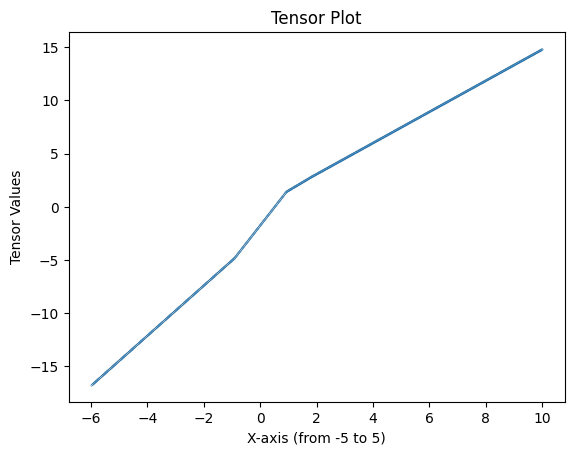

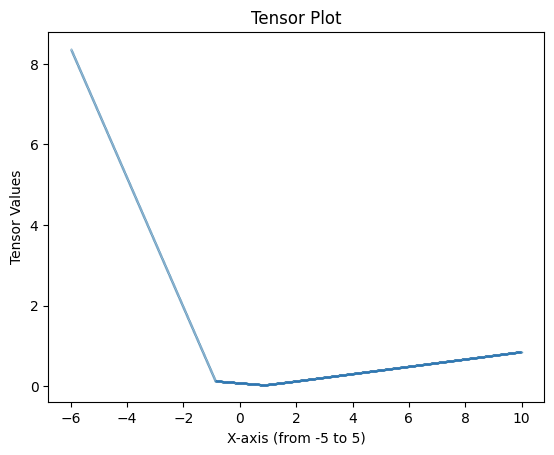

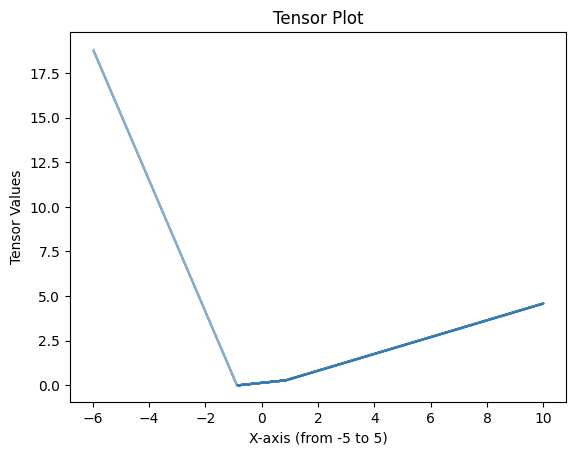

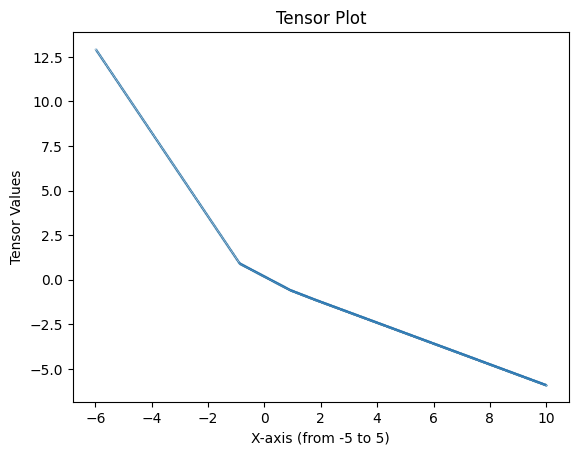

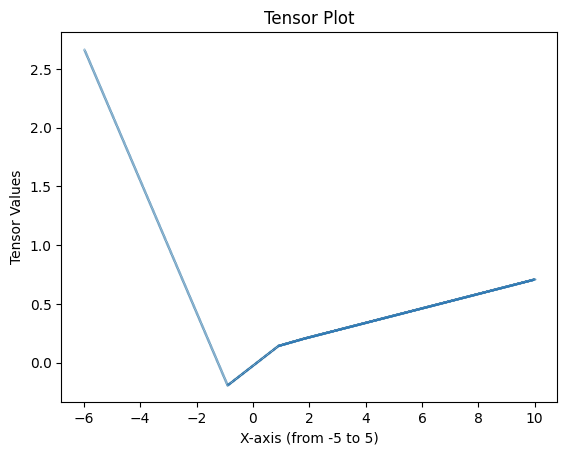

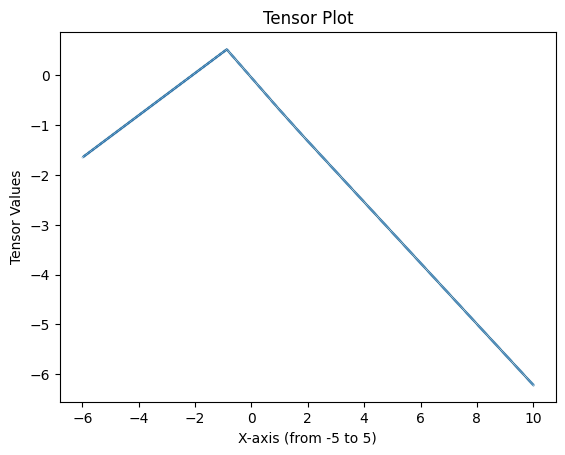

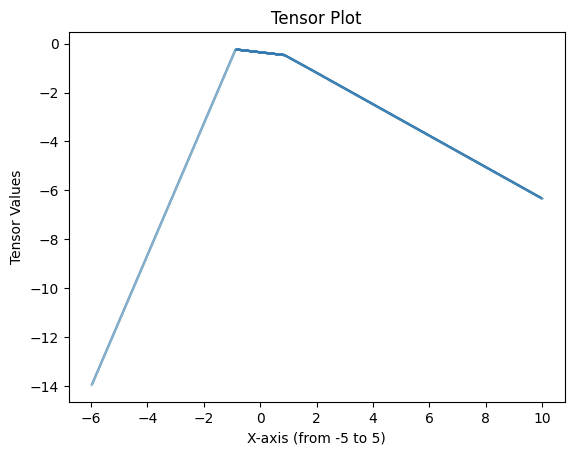

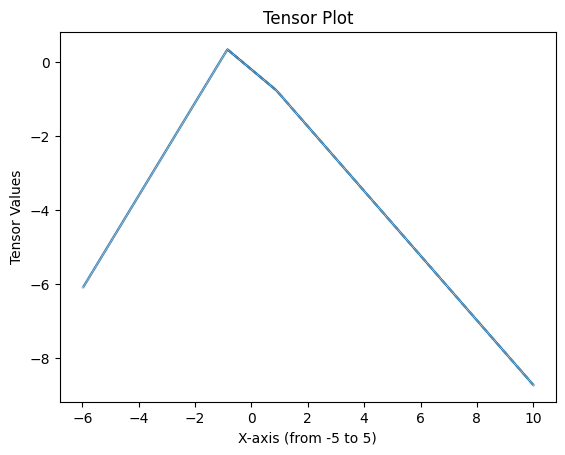

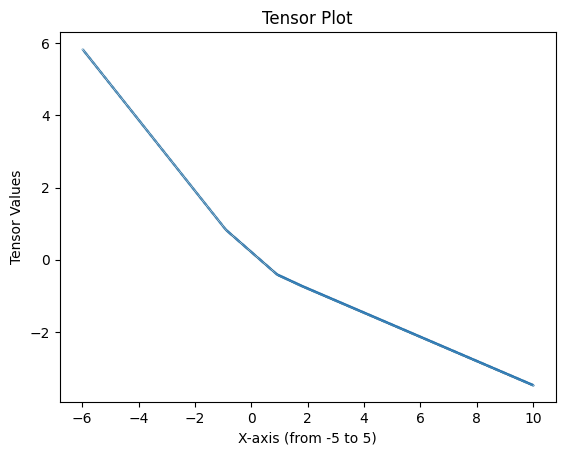

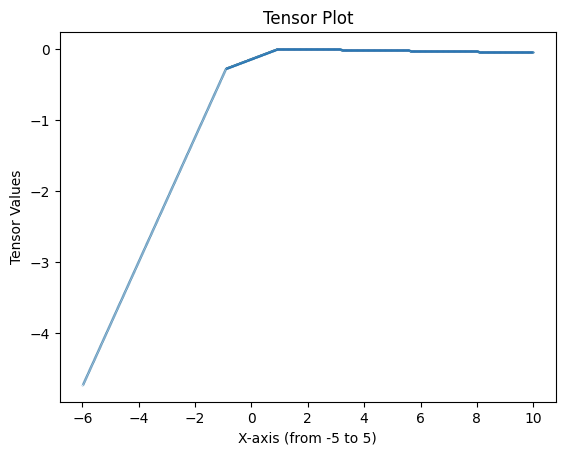

3


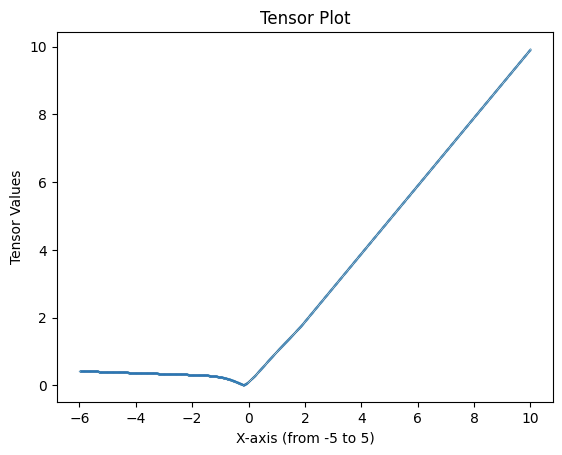

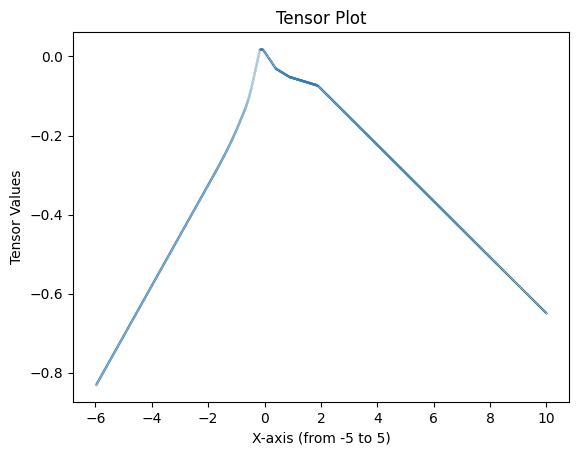

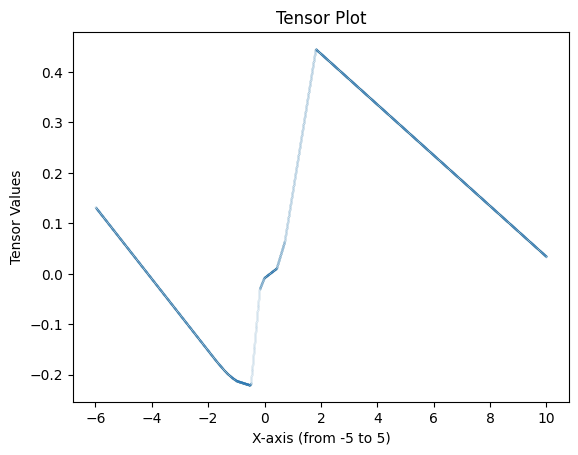

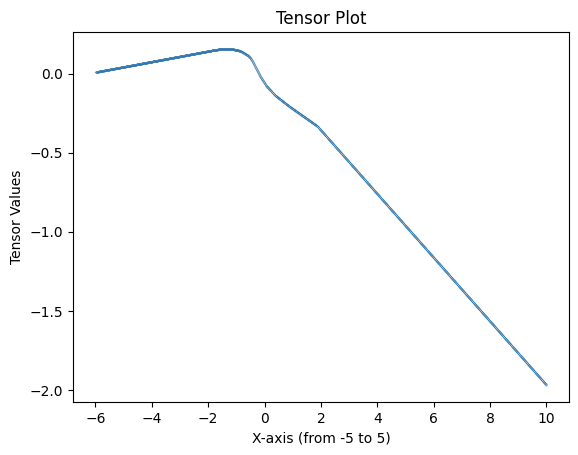

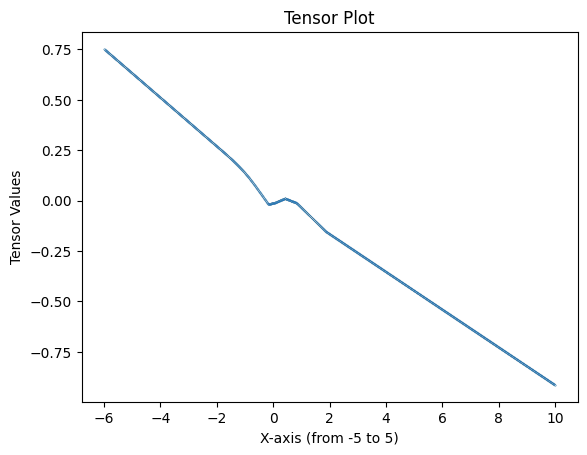

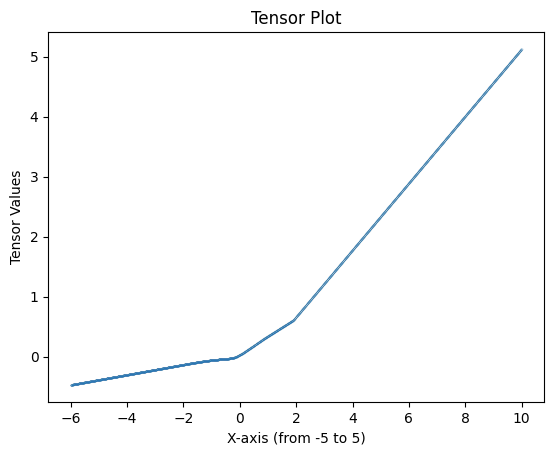

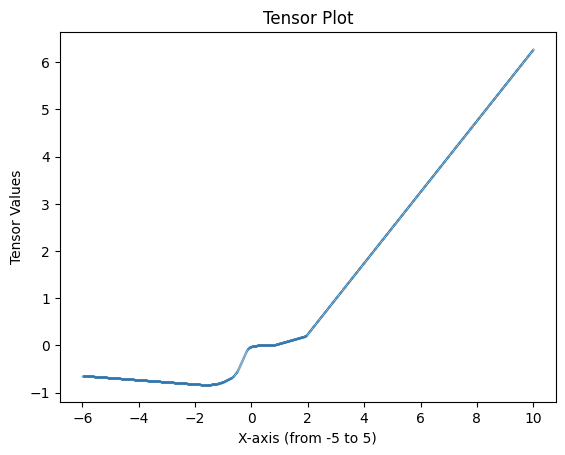

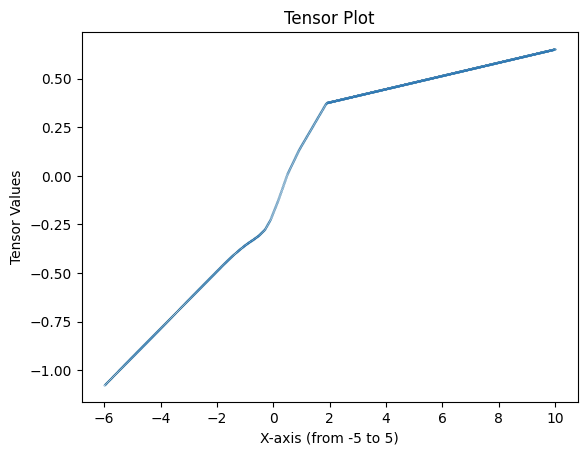

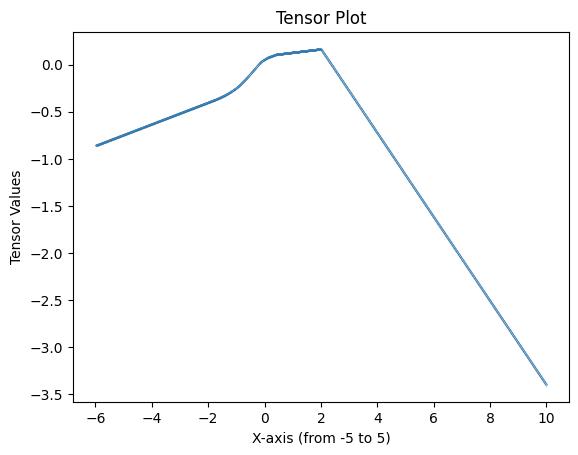

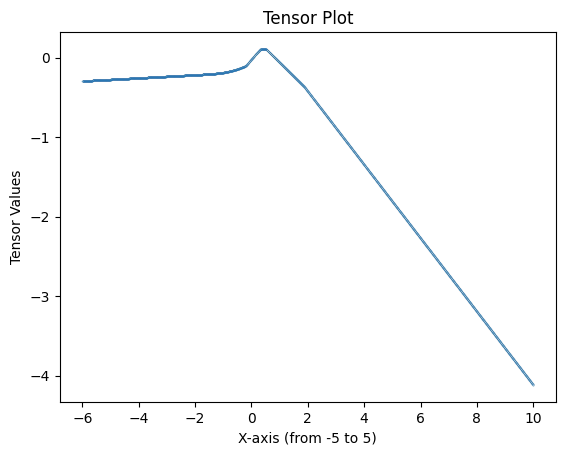

4


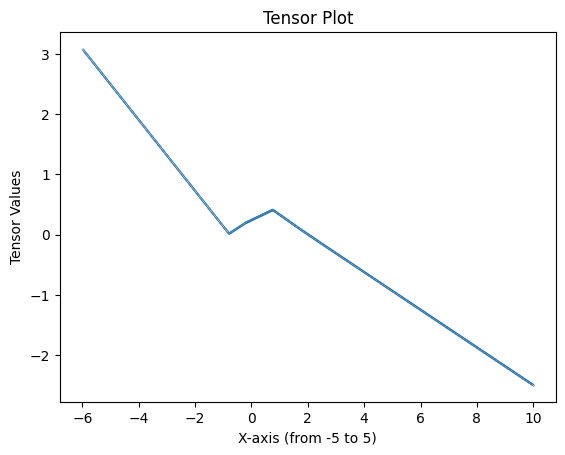

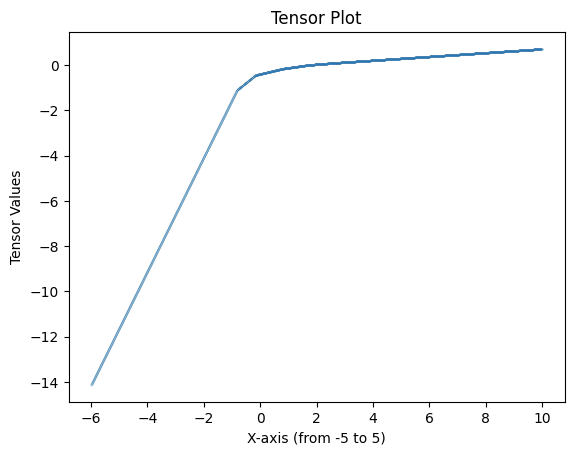

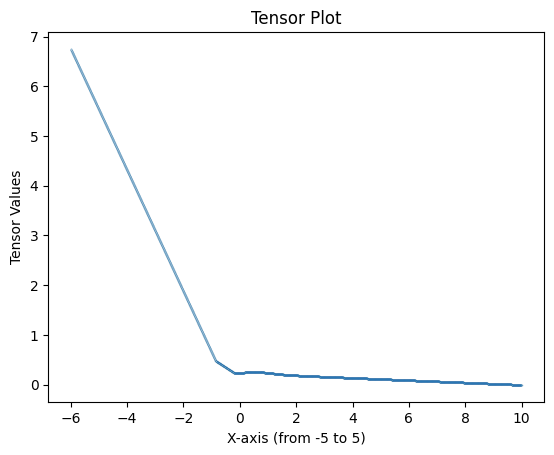

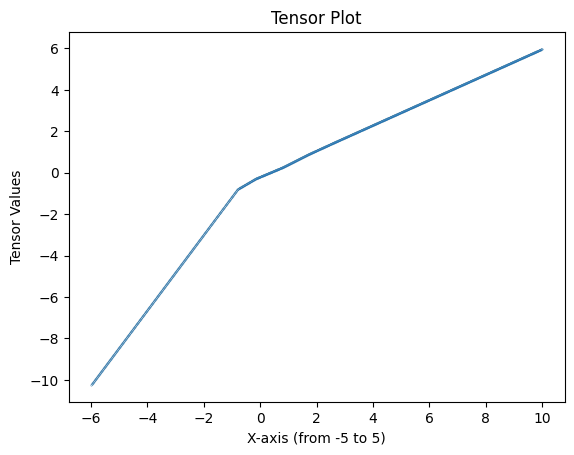

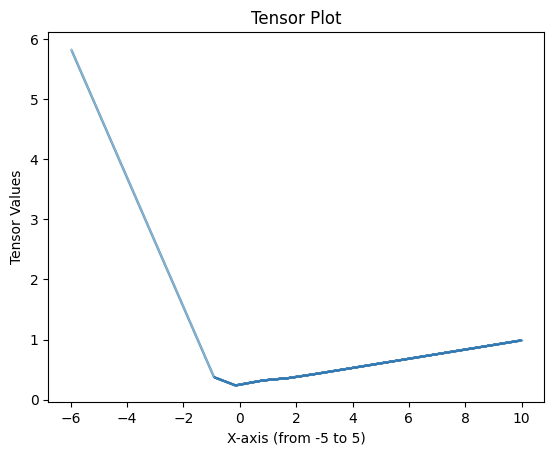

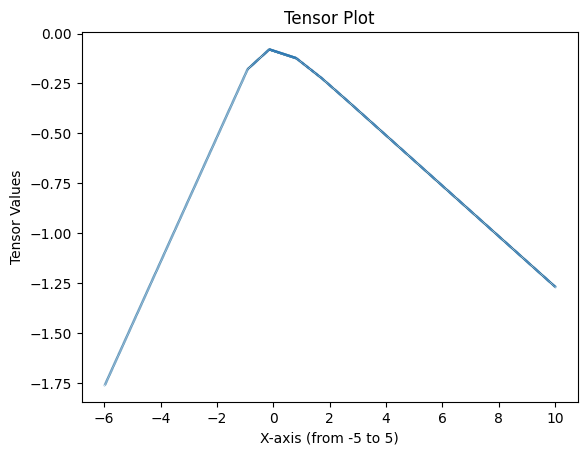

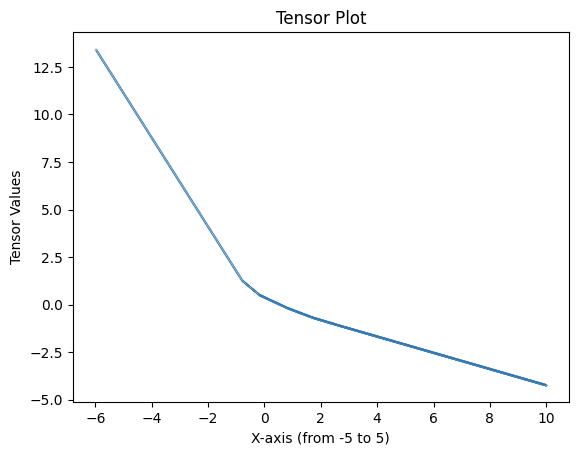

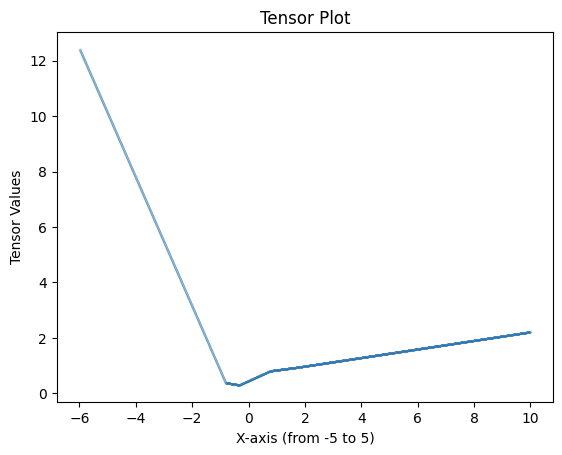

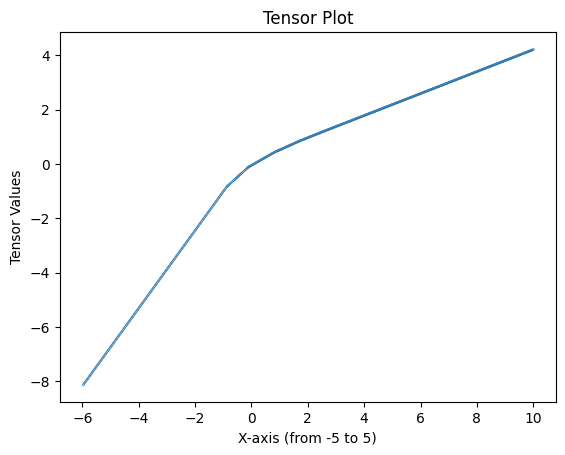

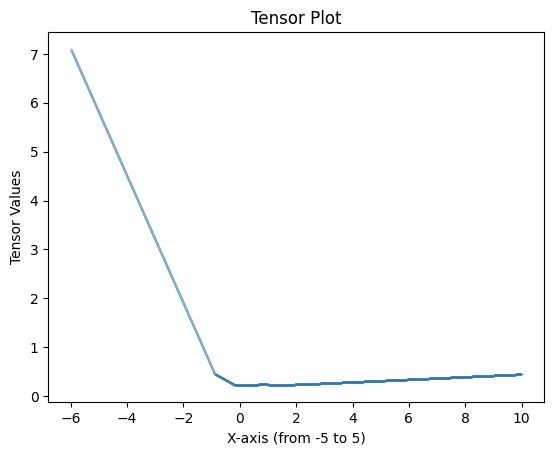

5


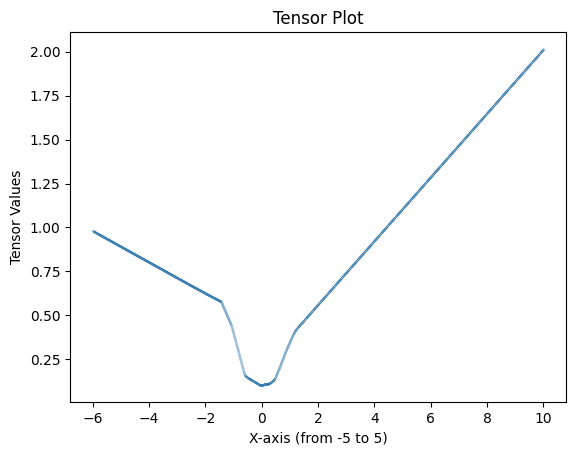

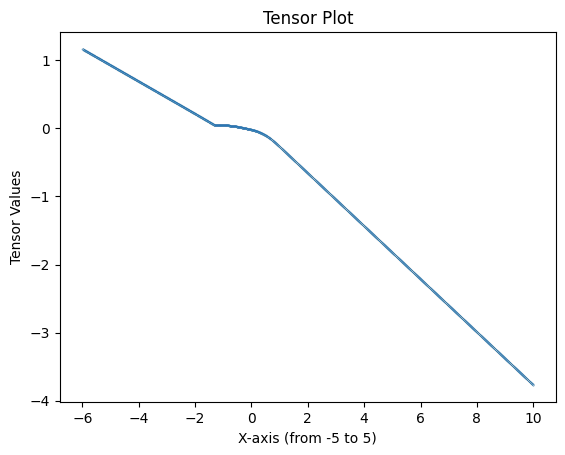

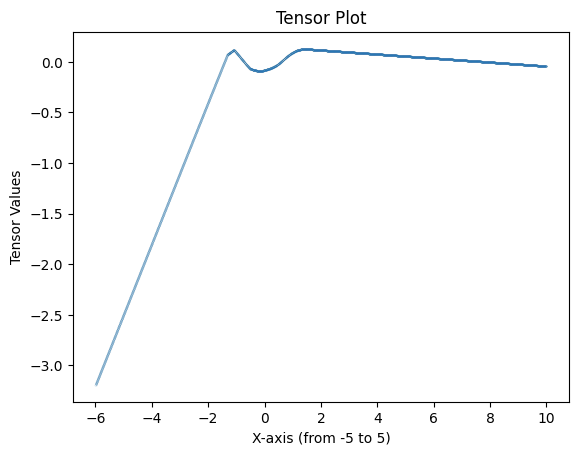

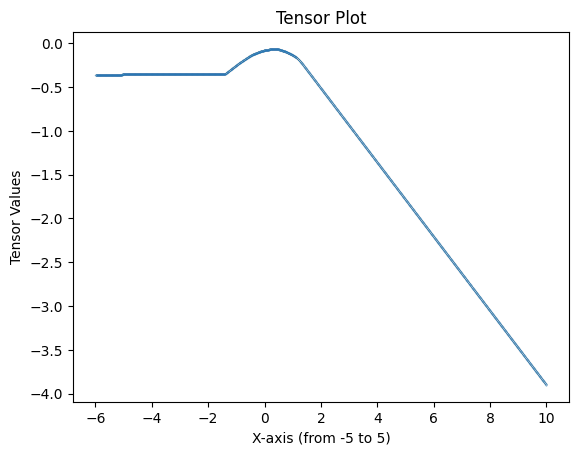

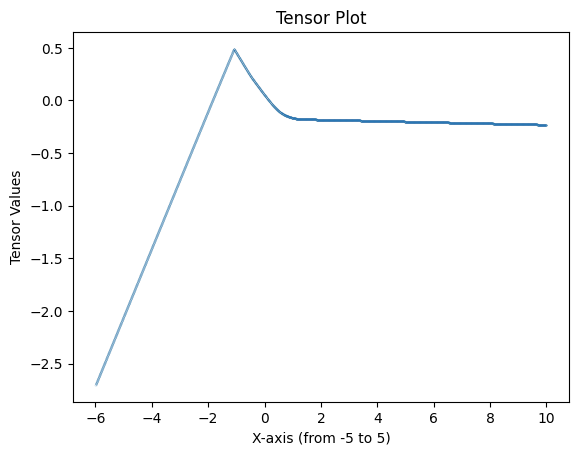

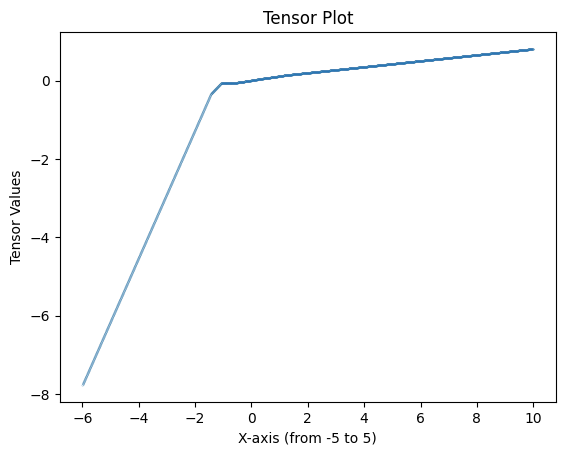

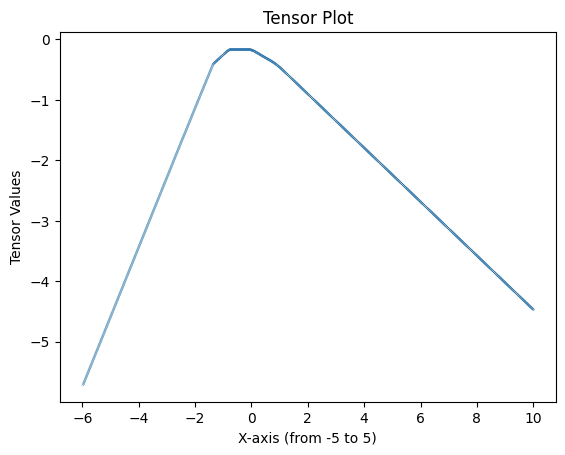

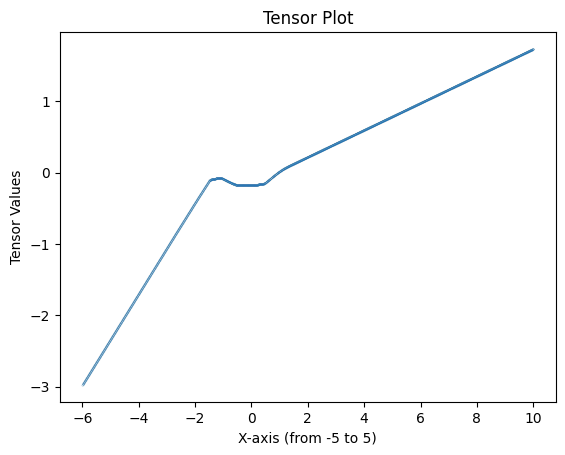

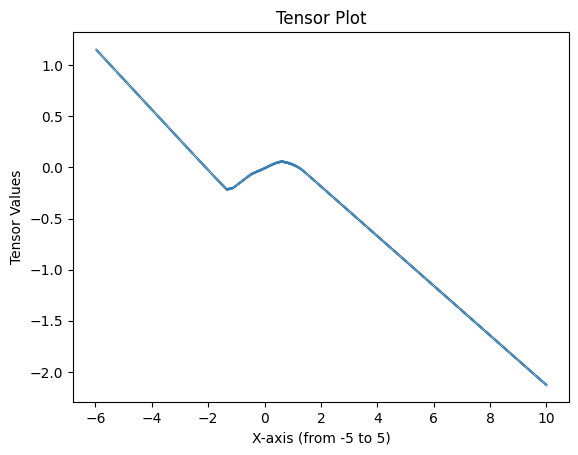

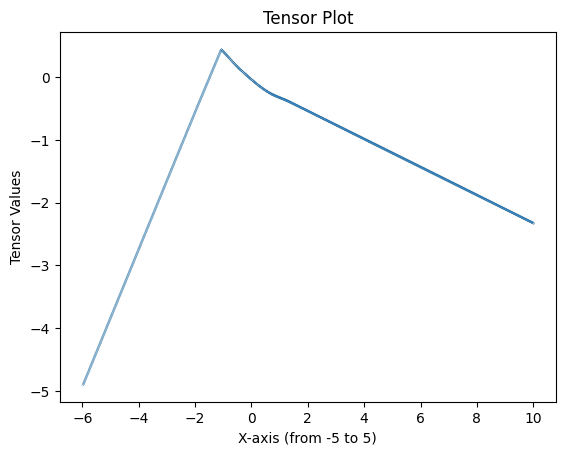

6


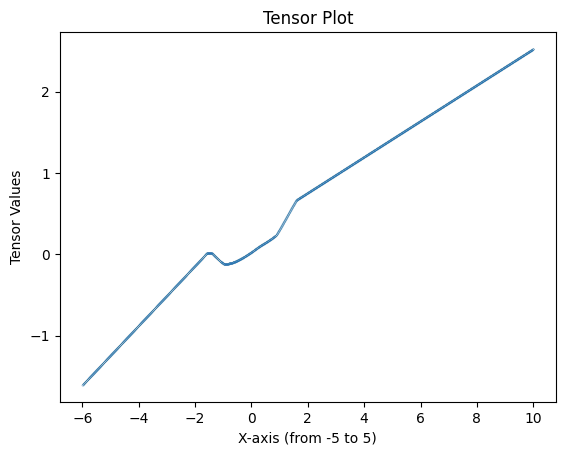

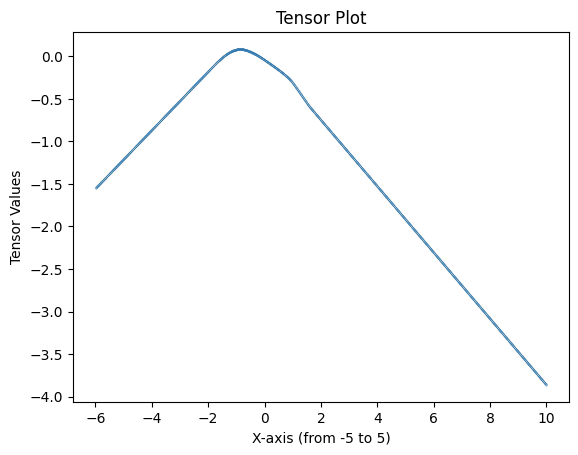

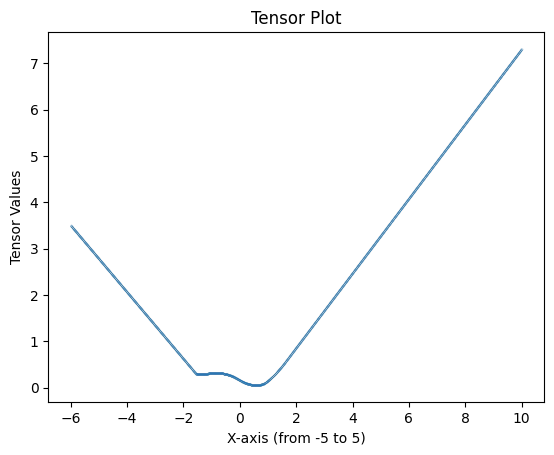

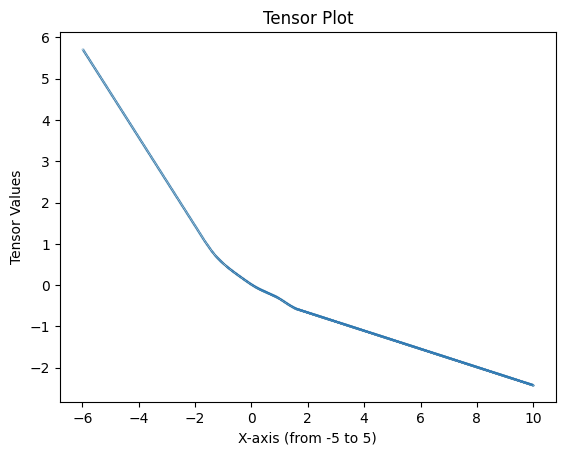

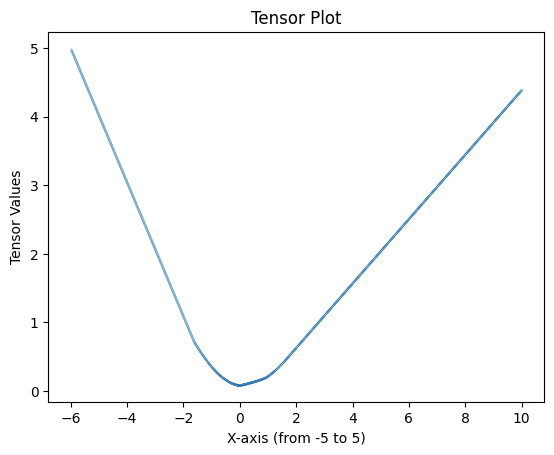

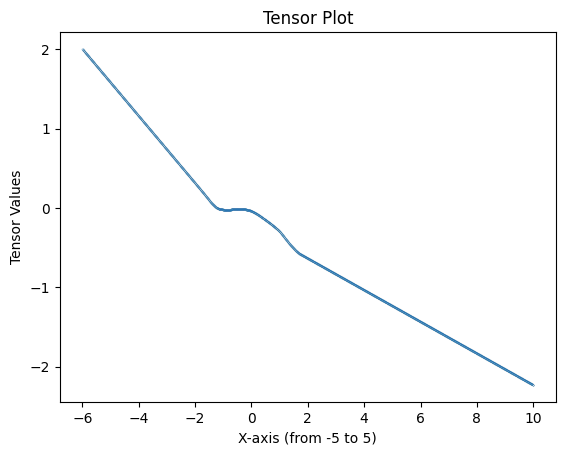

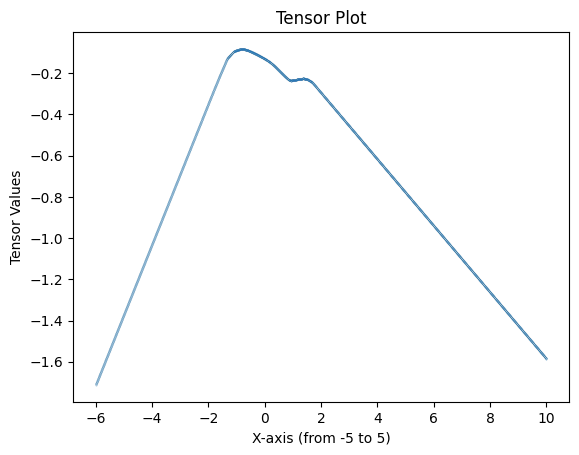

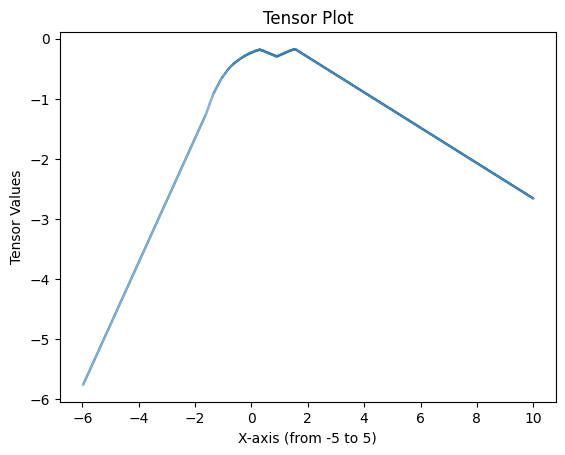

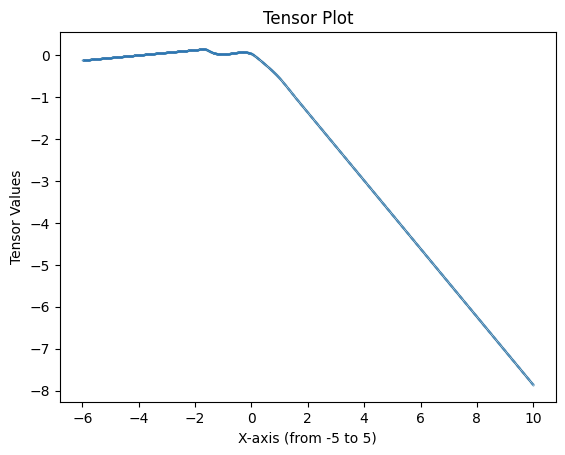

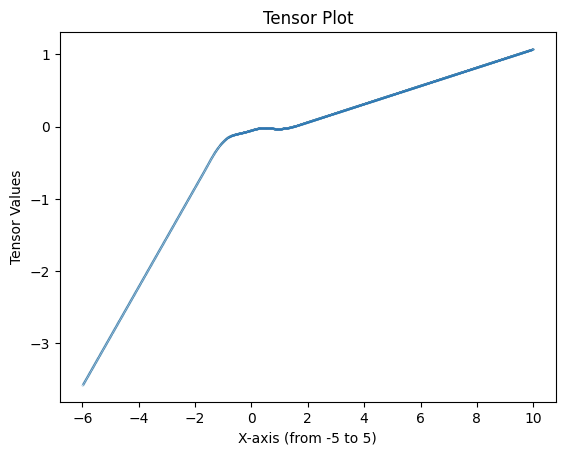

7


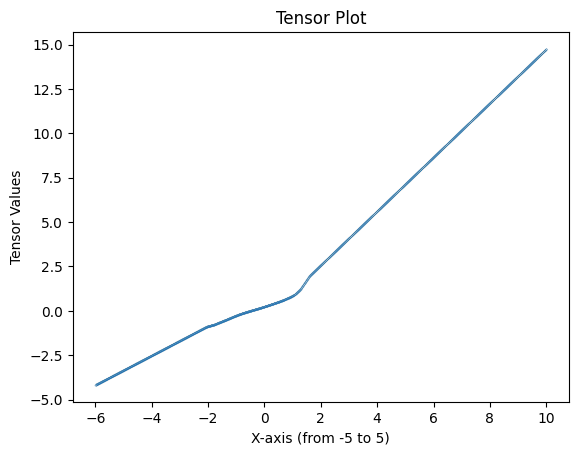

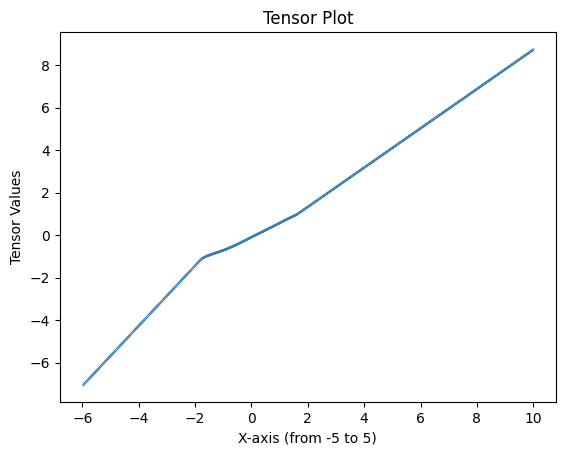

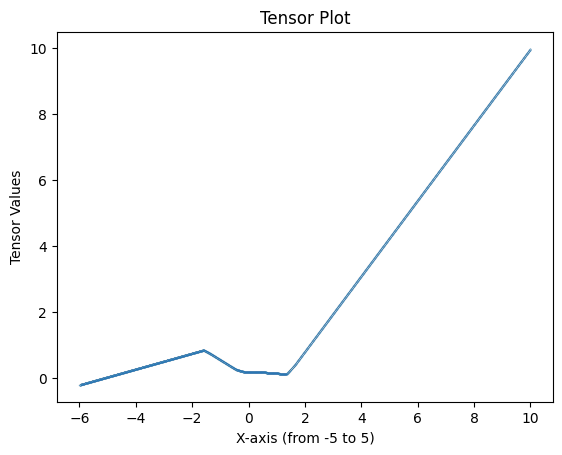

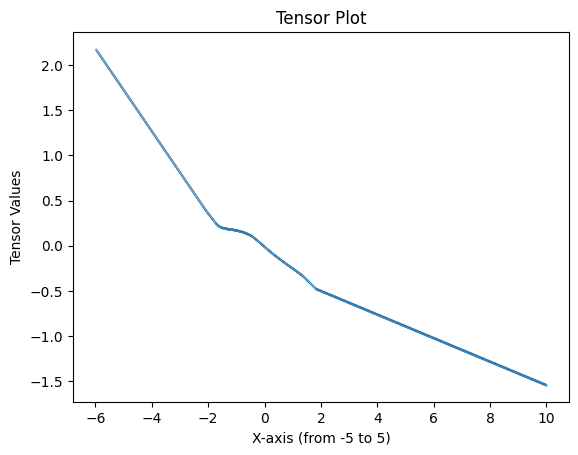

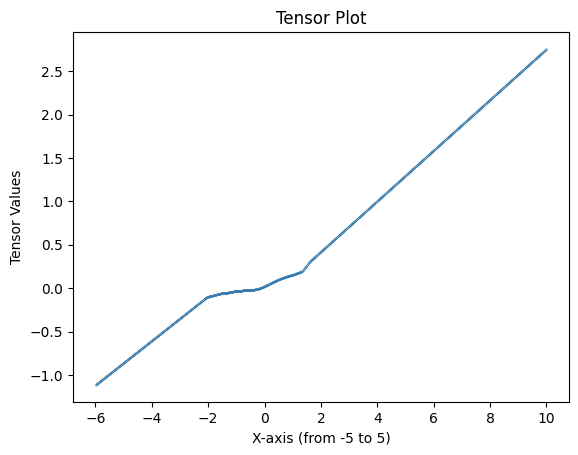

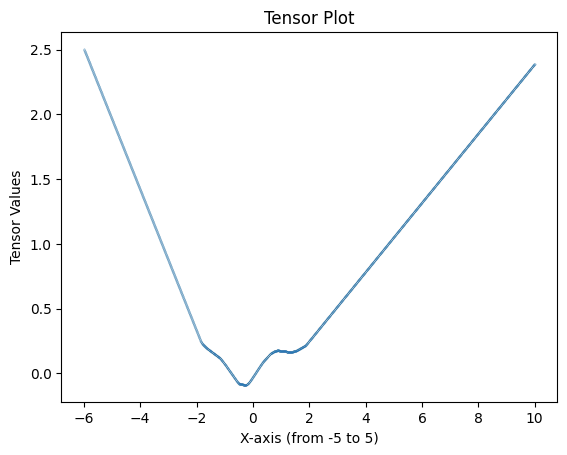

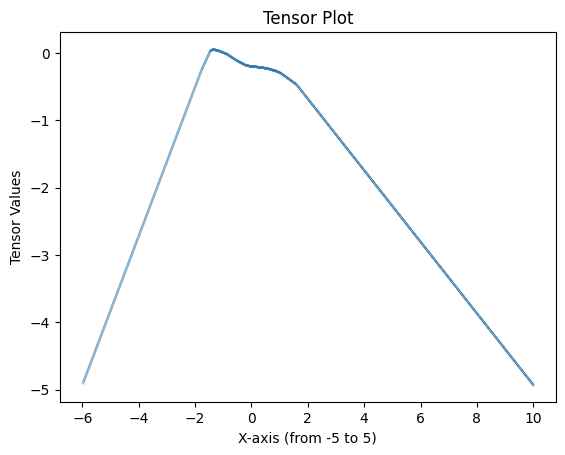

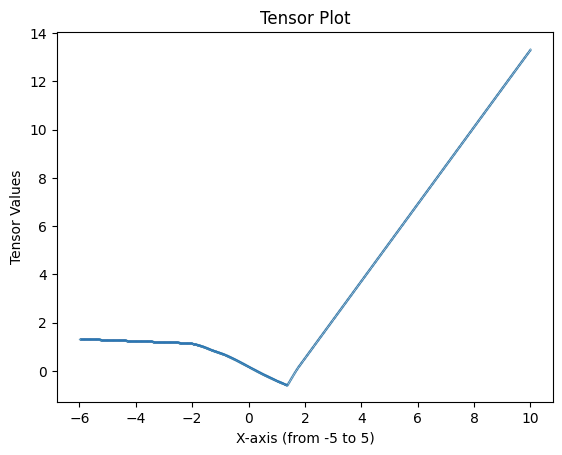

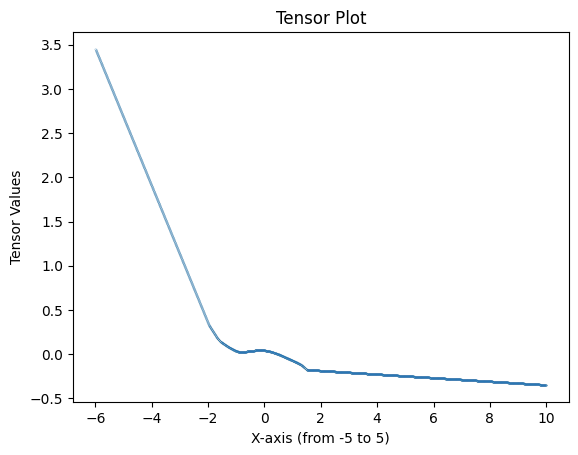

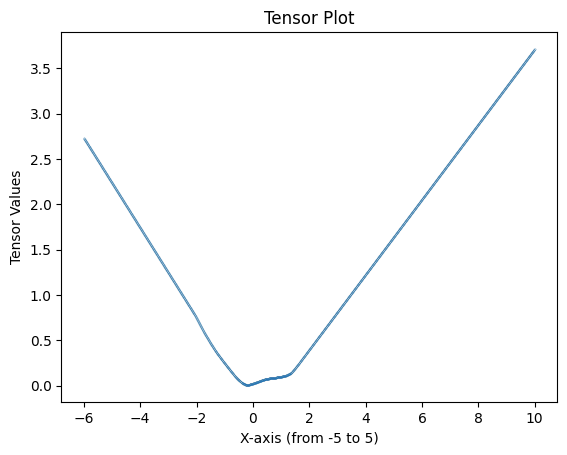

8


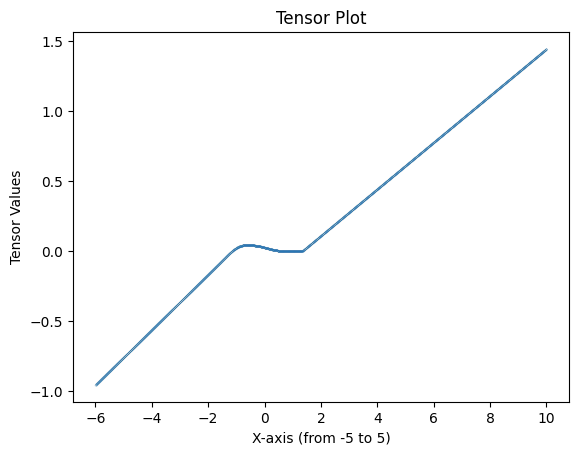

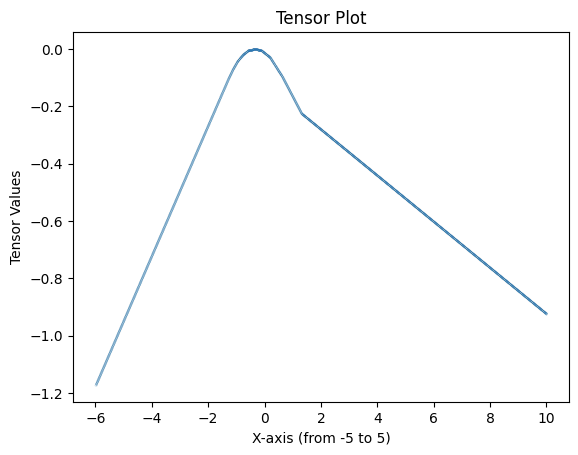

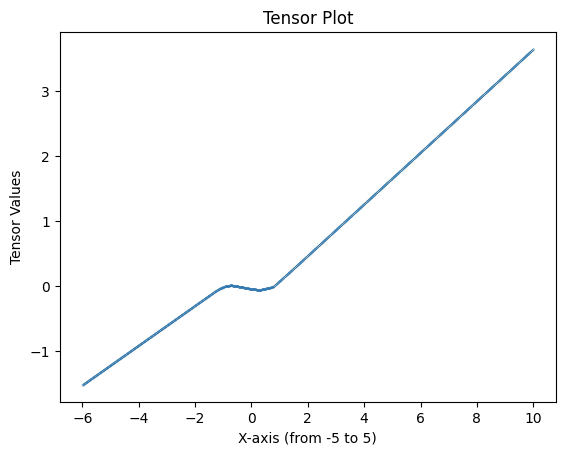

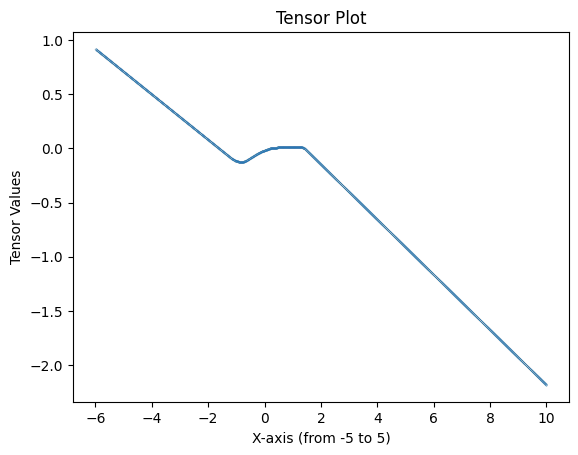

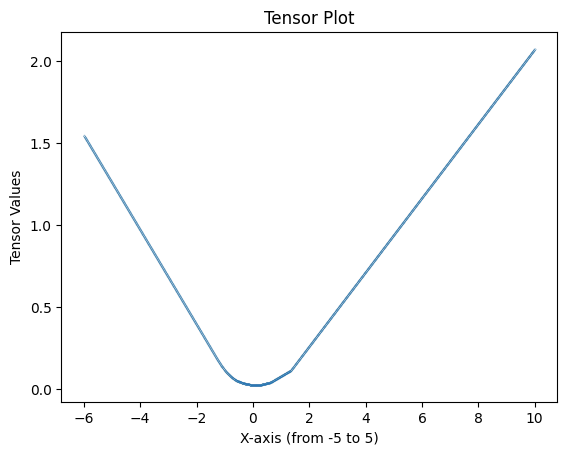

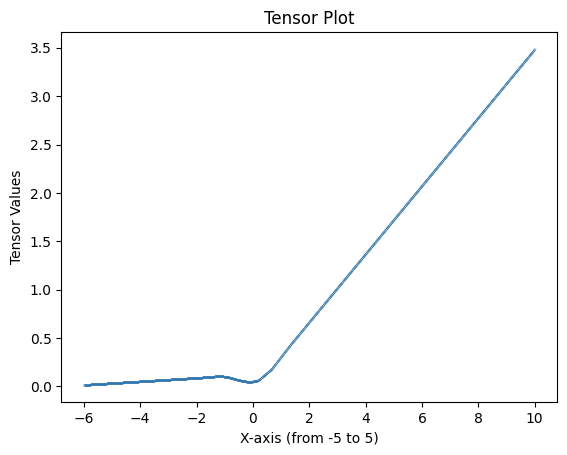

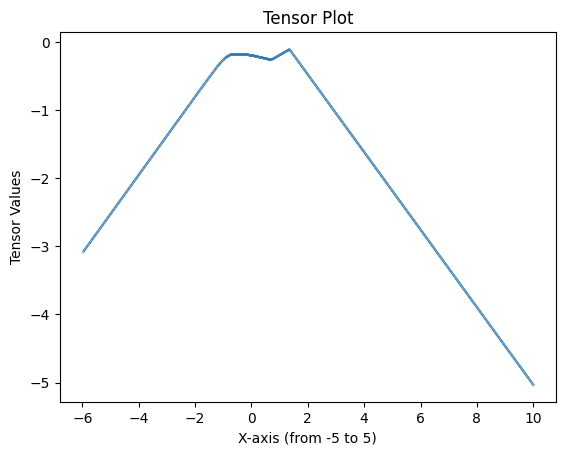

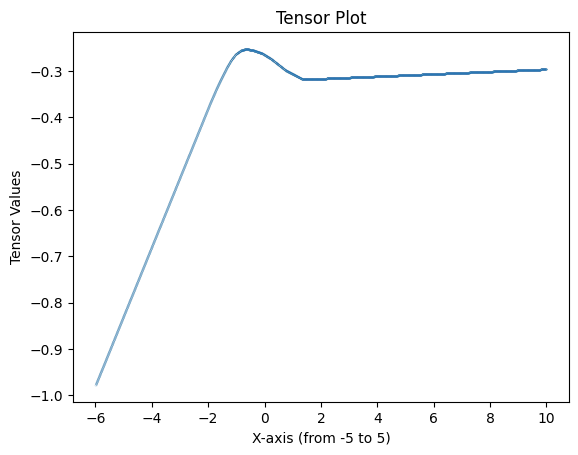

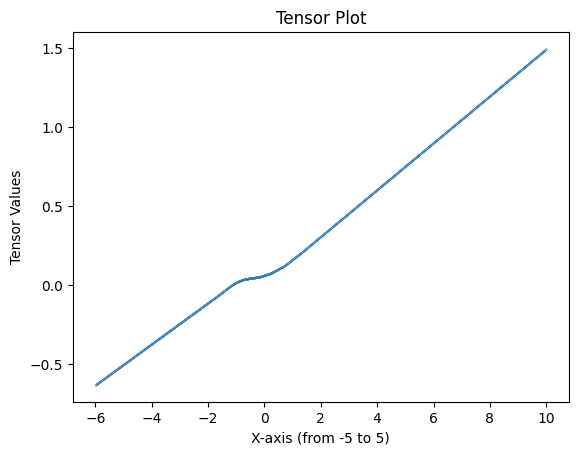

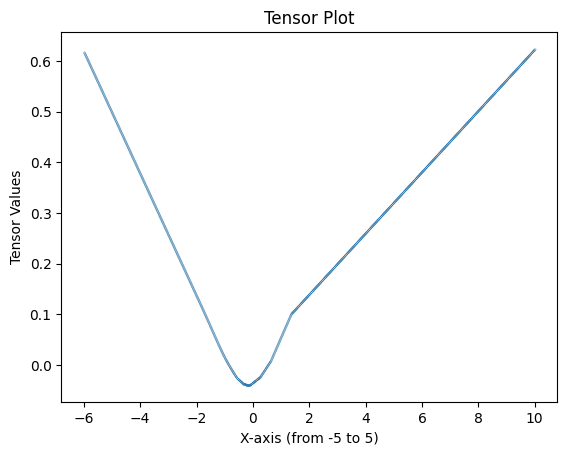

9


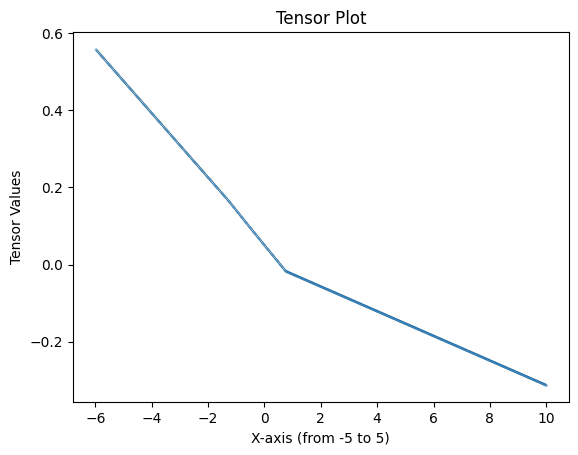

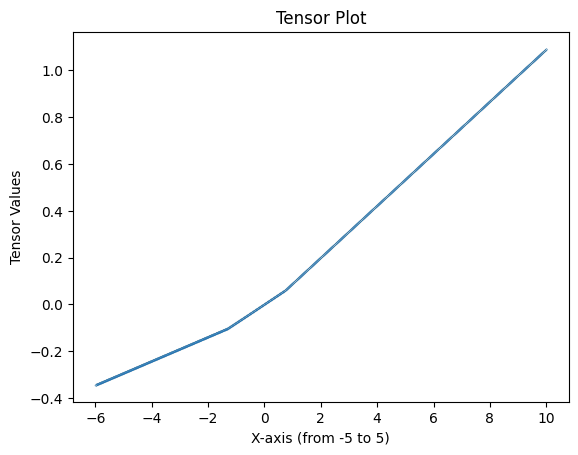

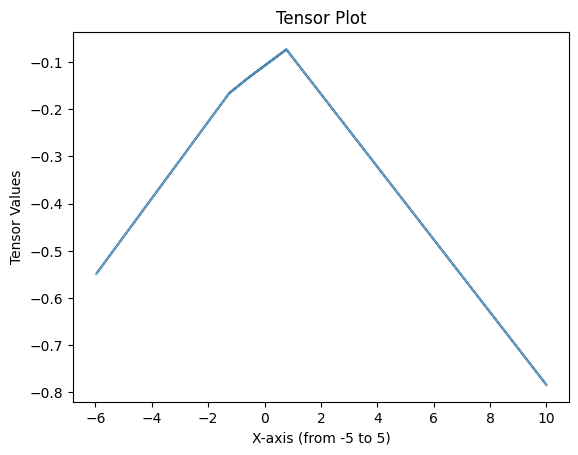

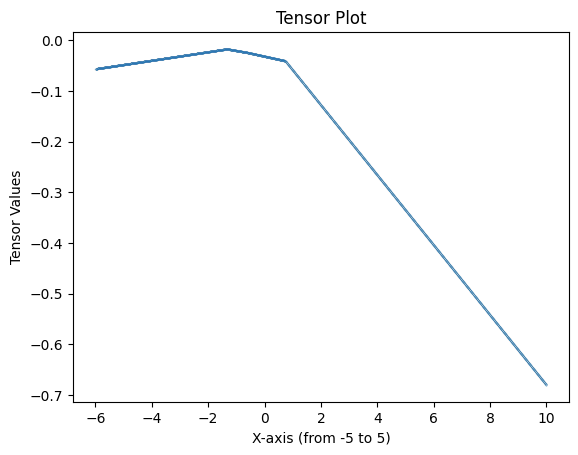

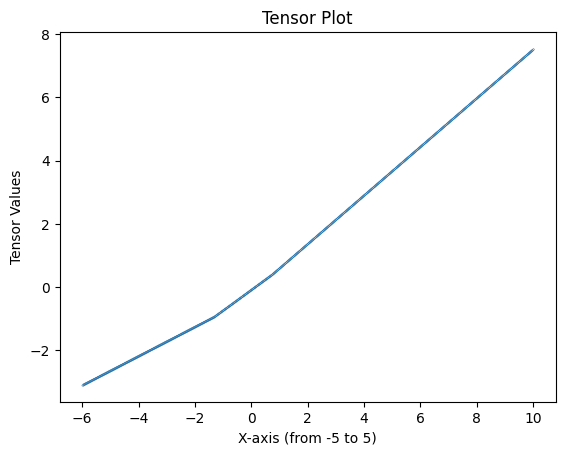

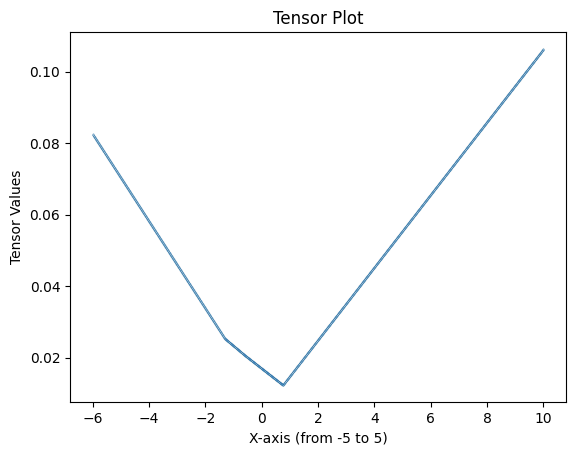

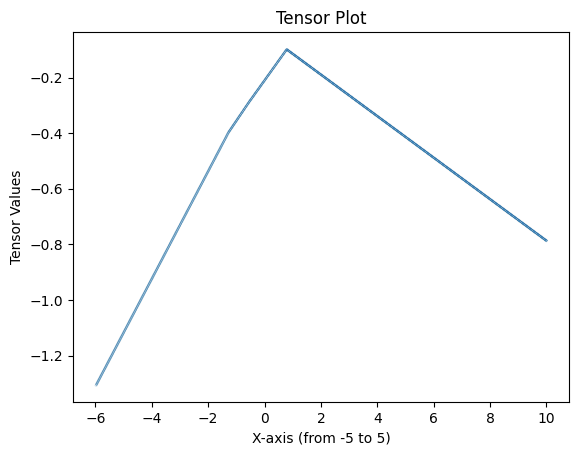

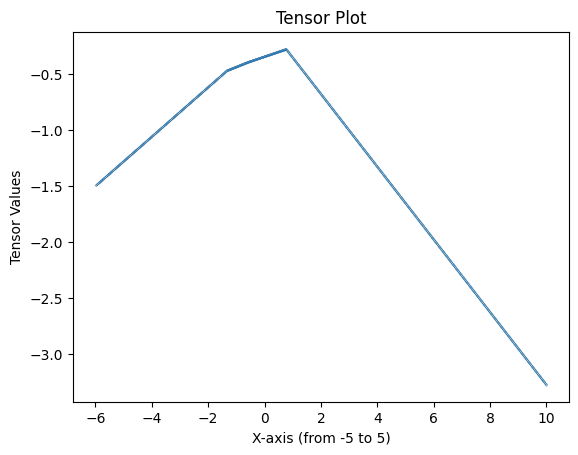

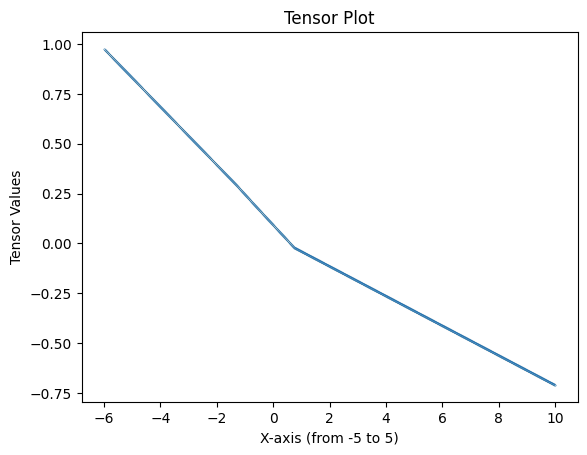

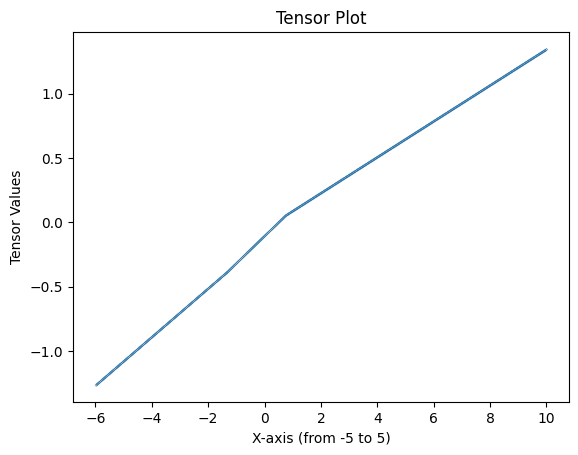

10


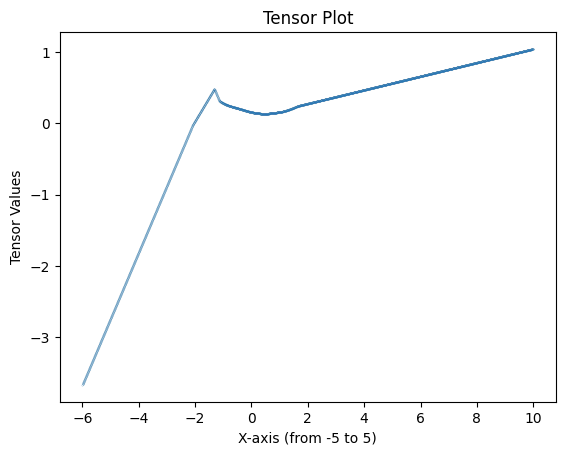

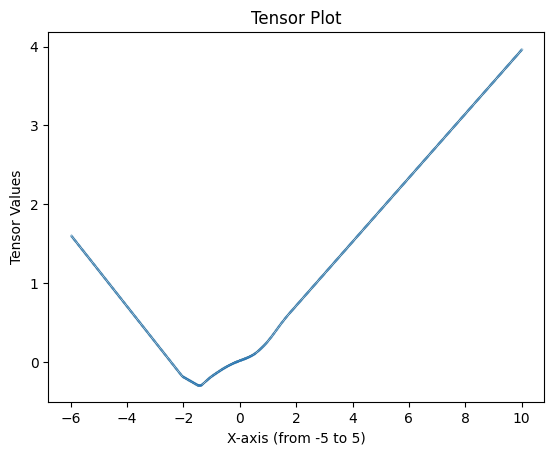

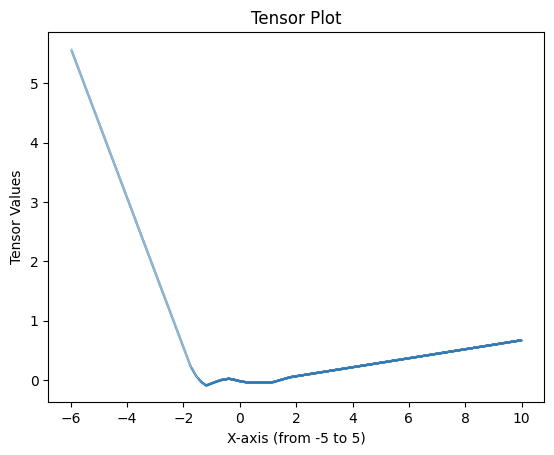

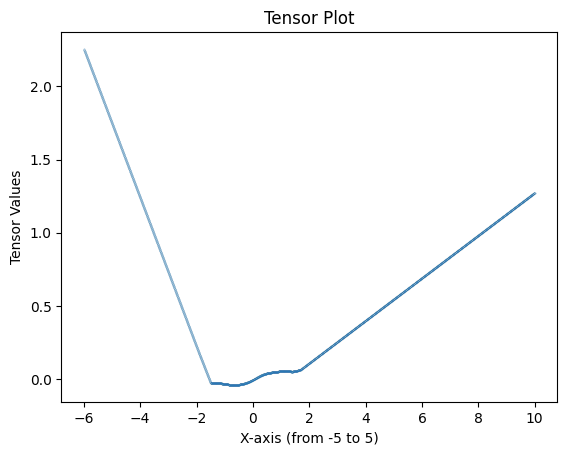

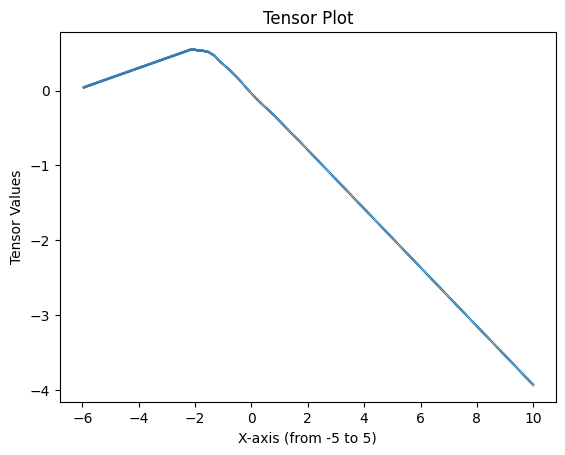

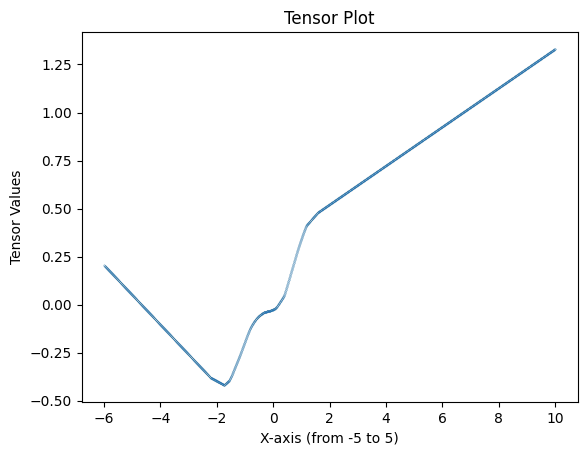

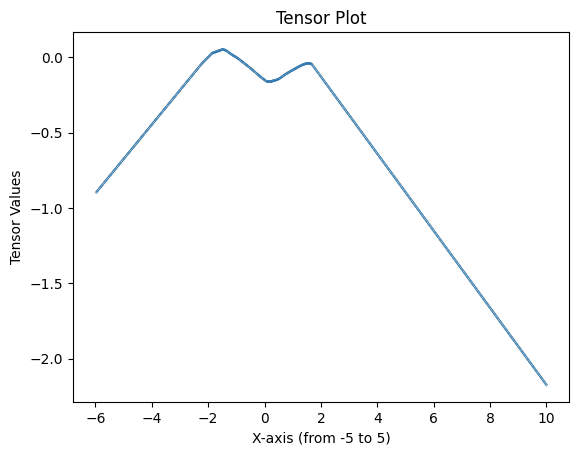

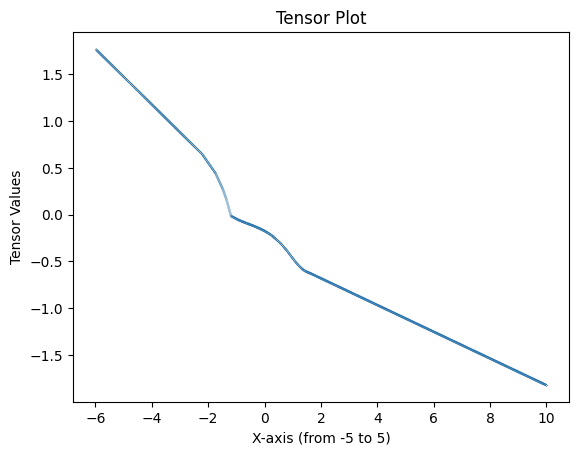

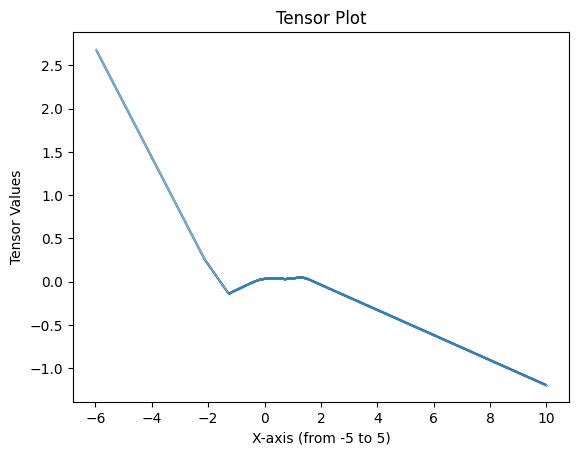

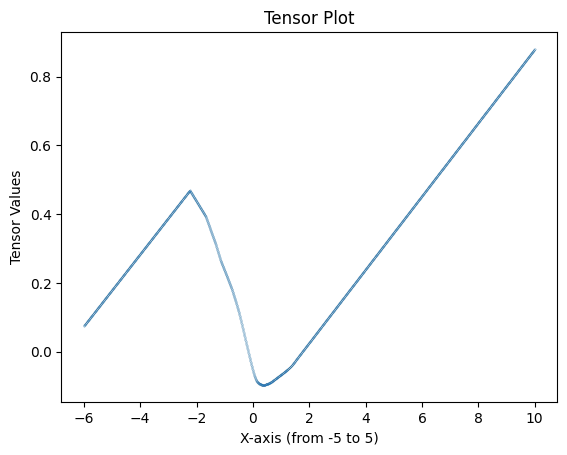

11


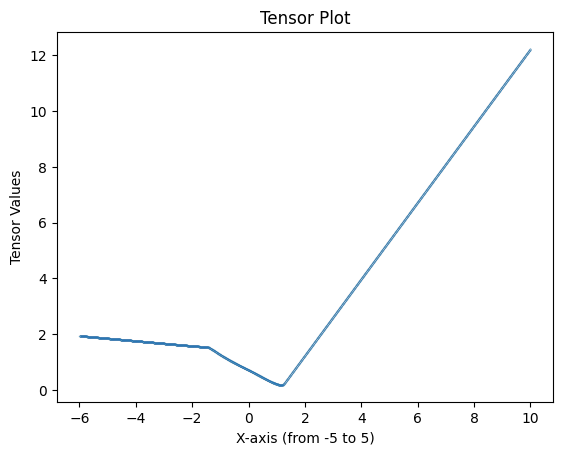

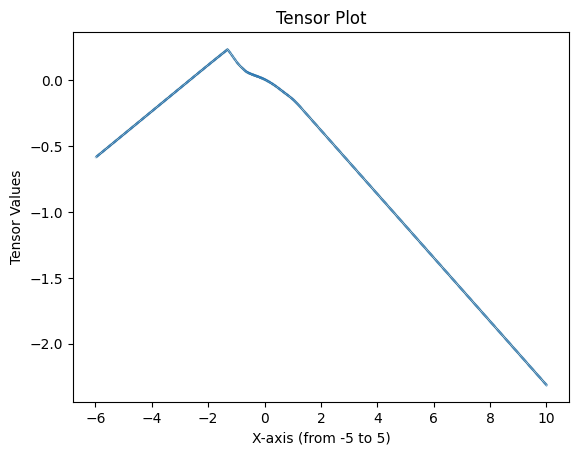

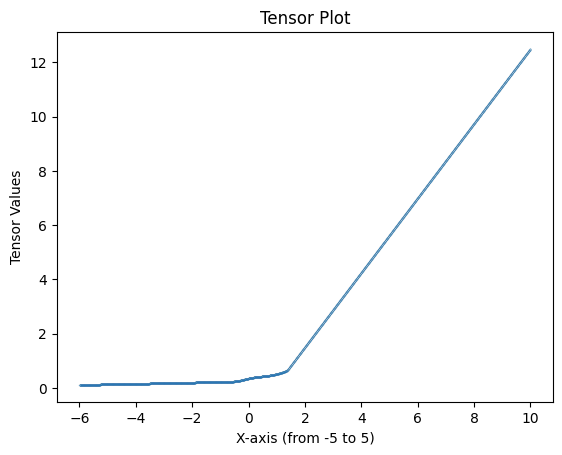

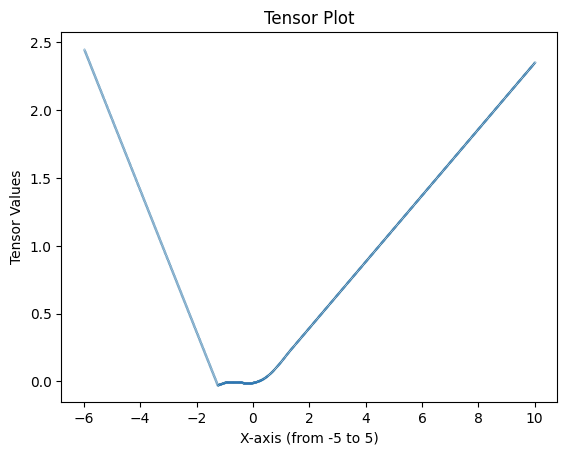

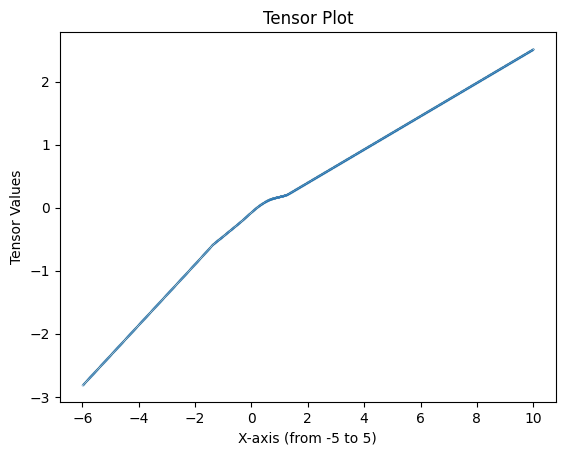

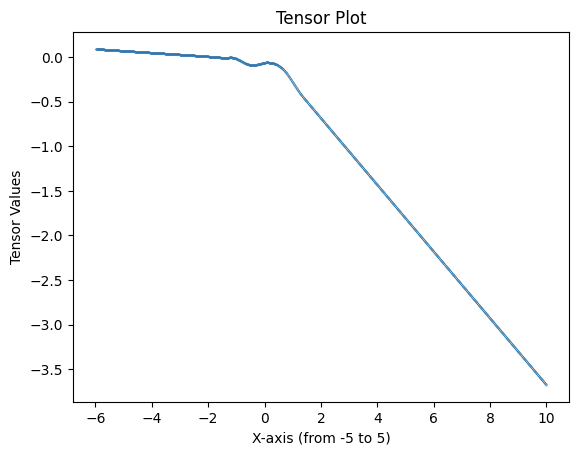

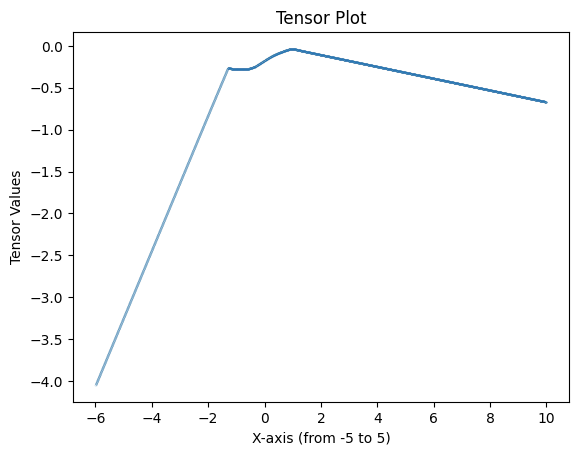

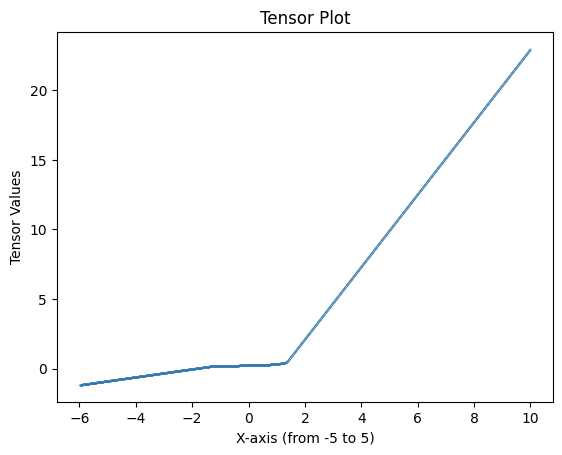

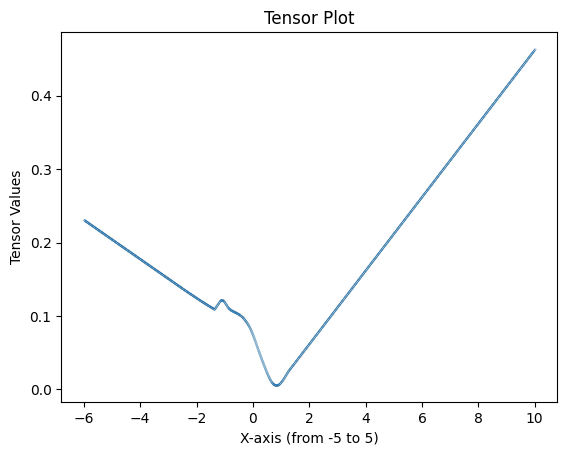

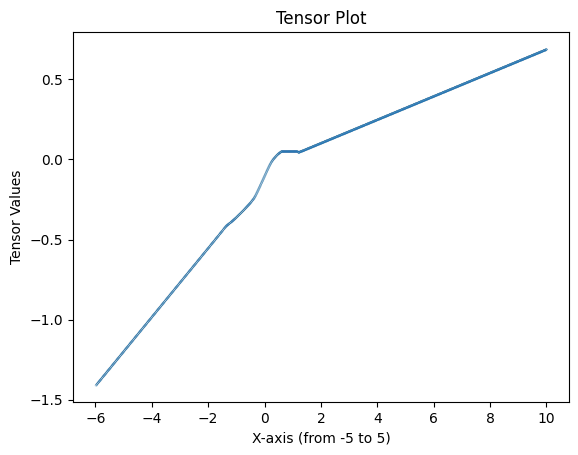

12


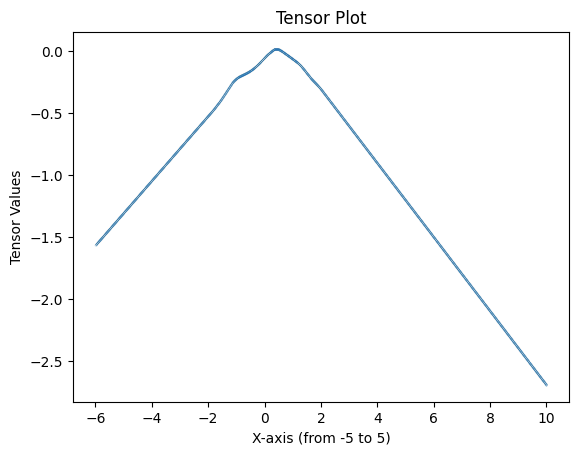

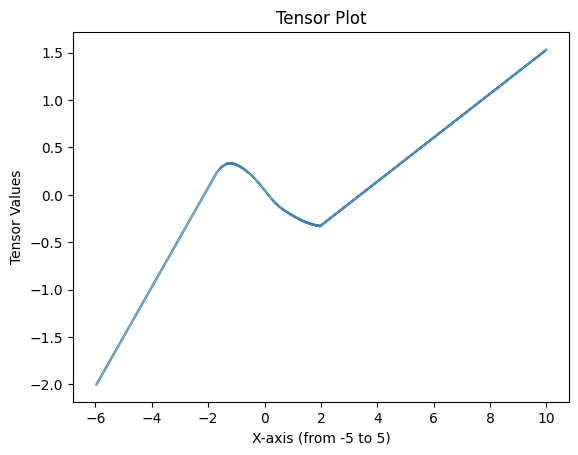

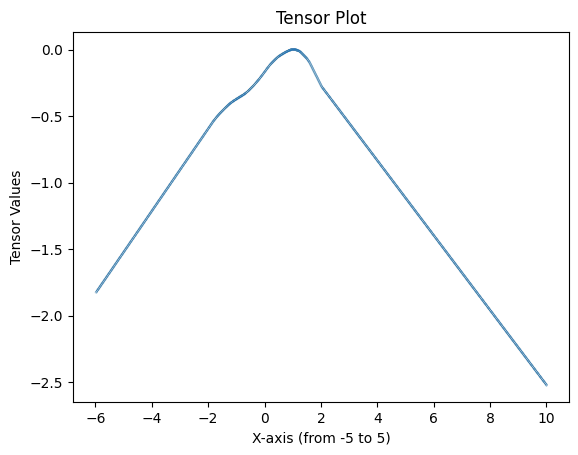

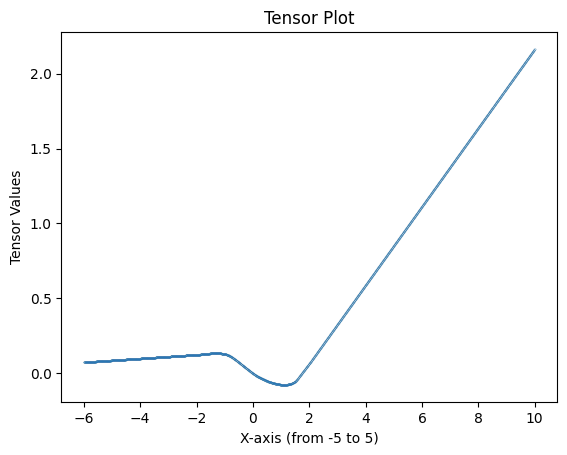

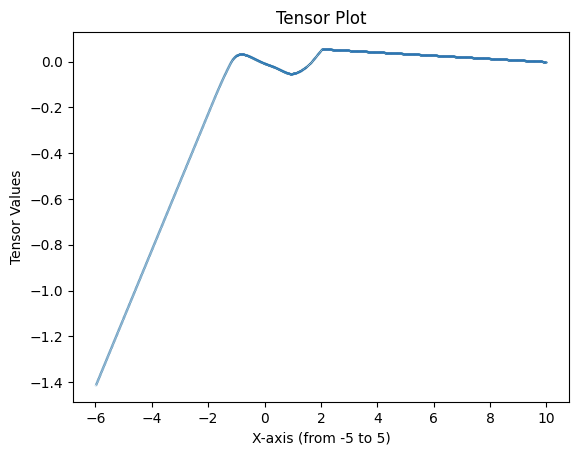

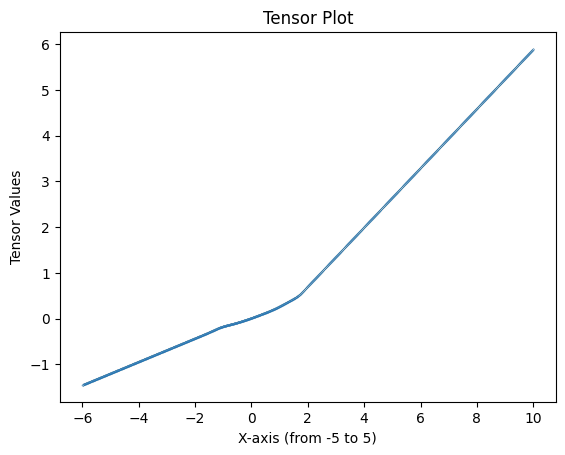

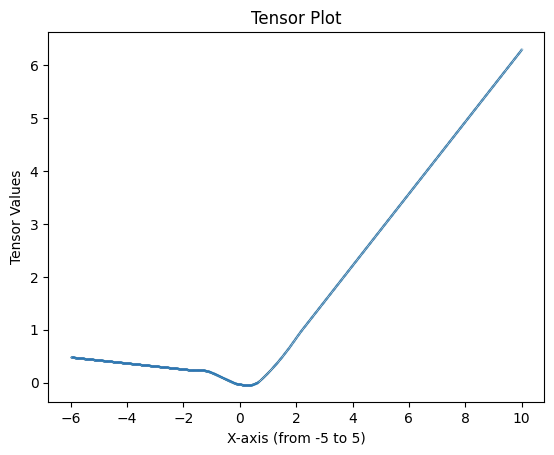

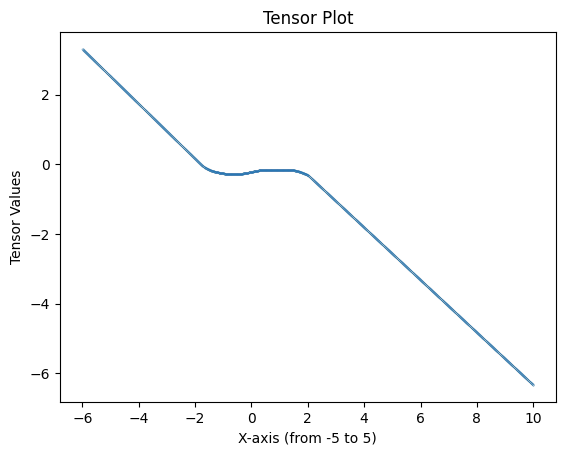

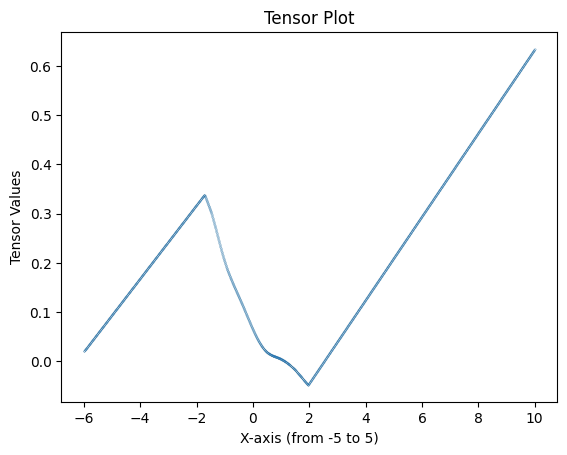

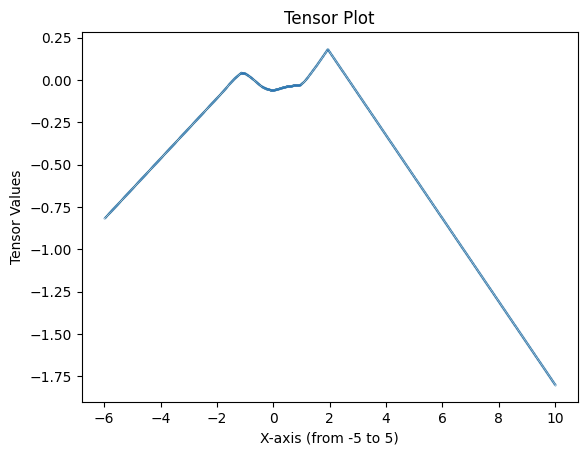

13


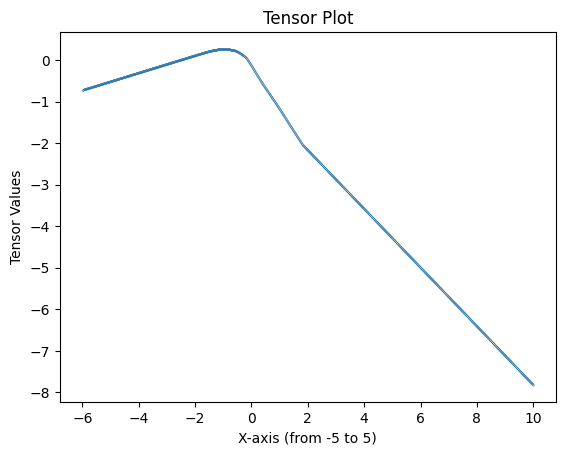

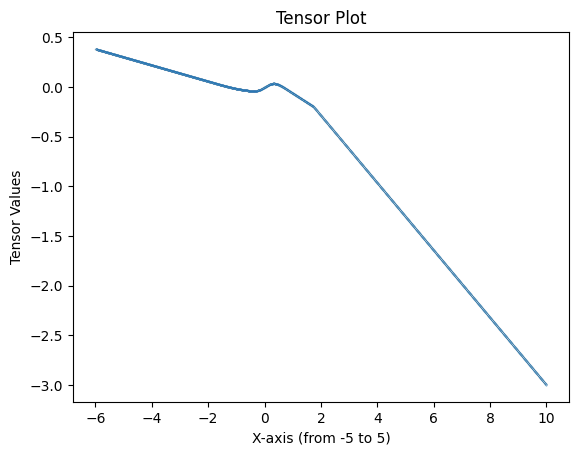

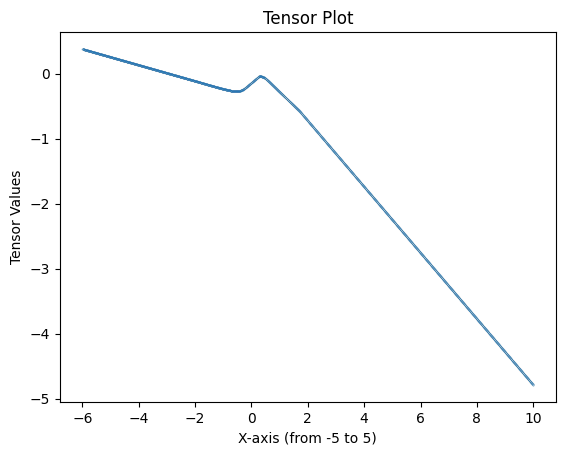

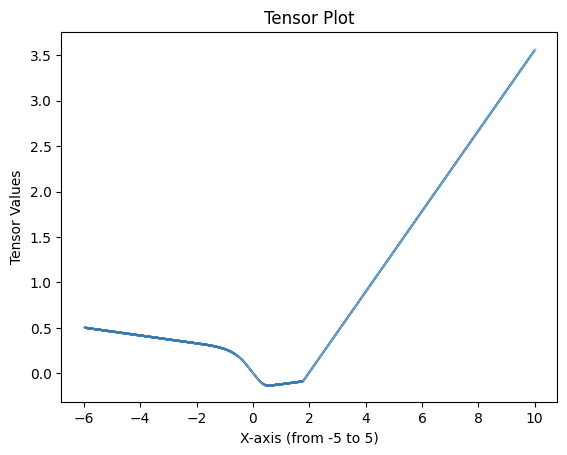

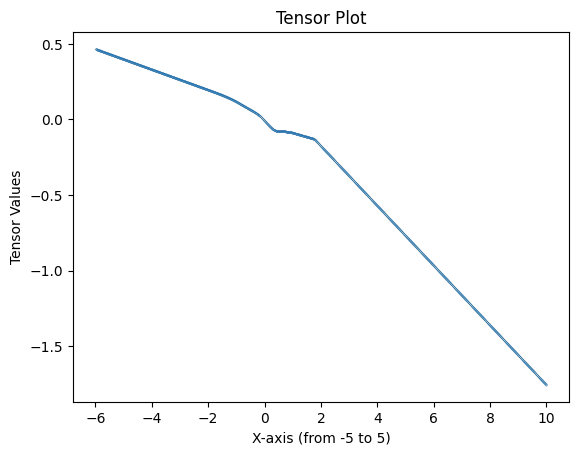

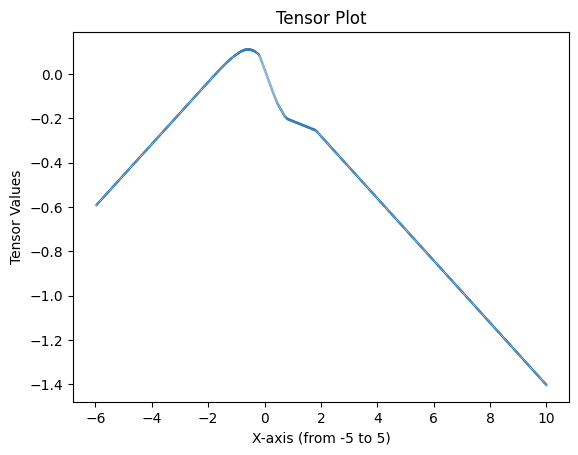

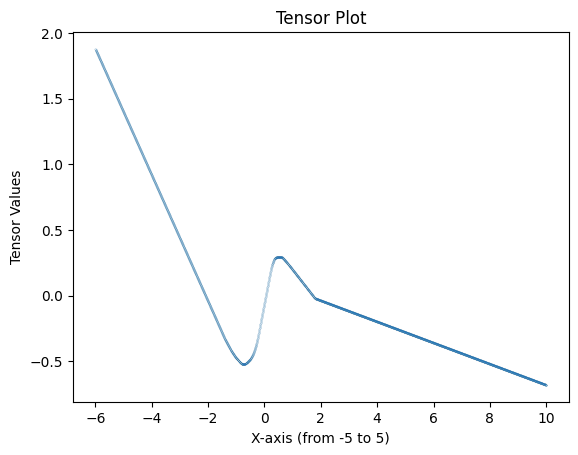

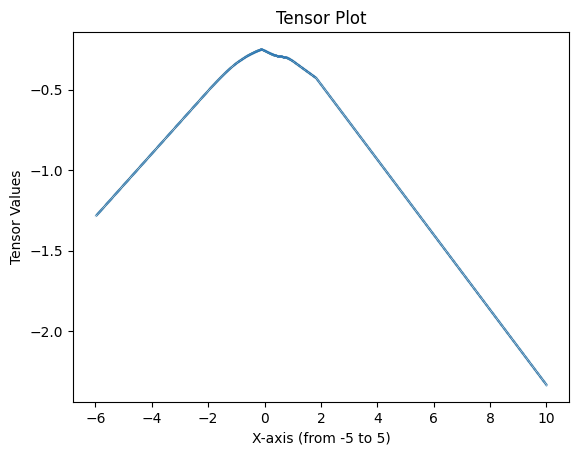

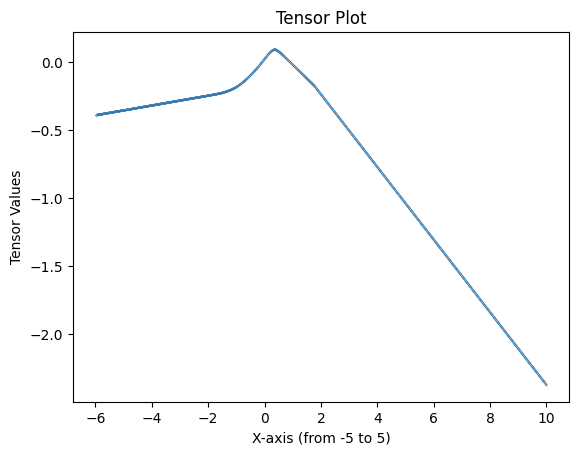

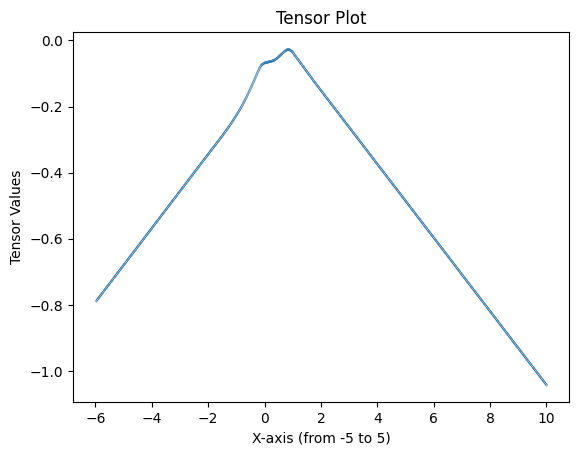

14


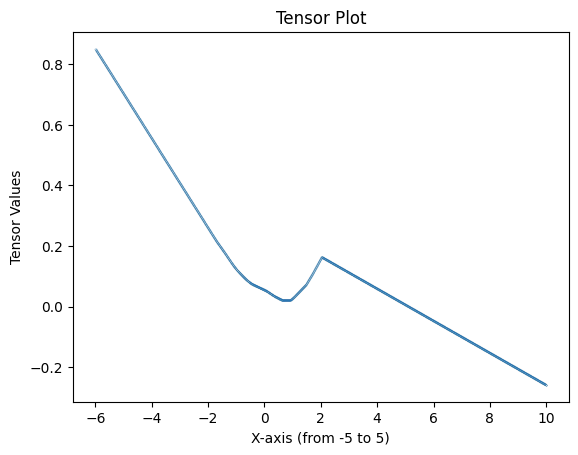

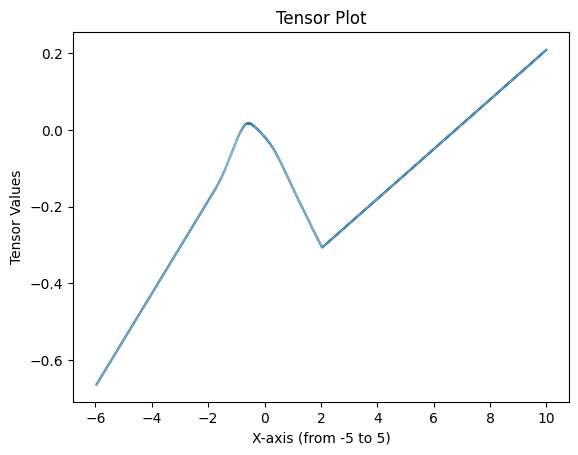

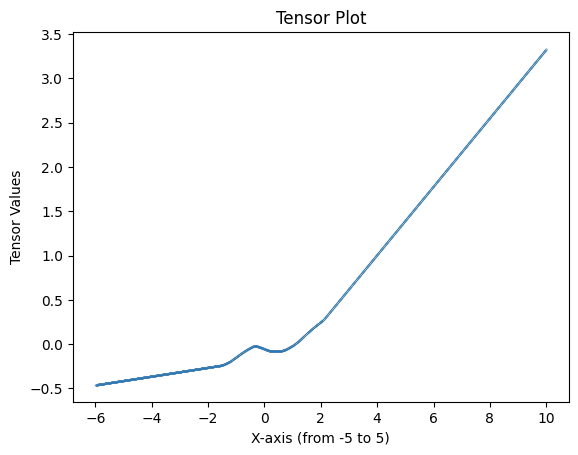

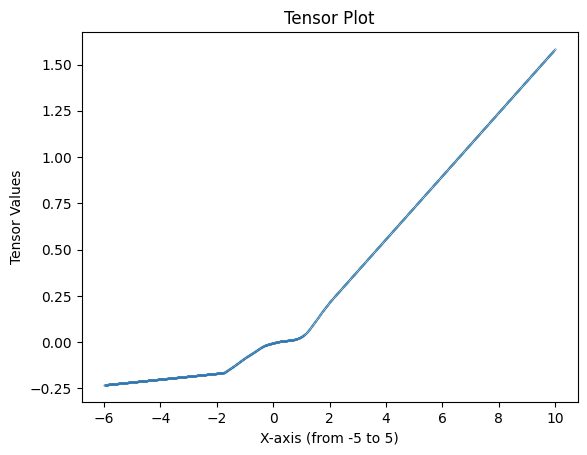

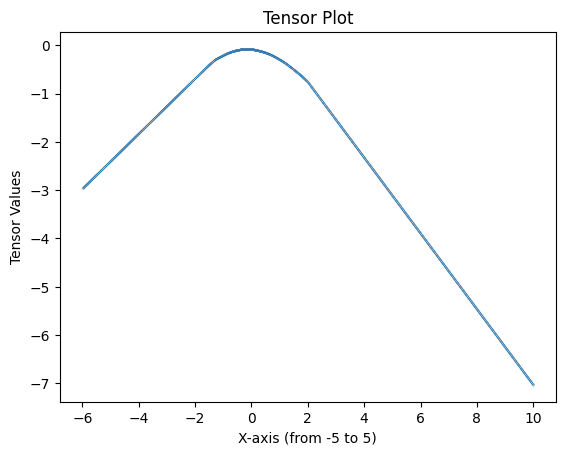

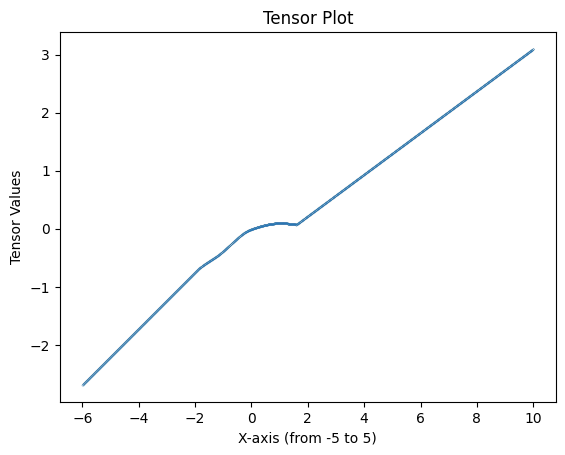

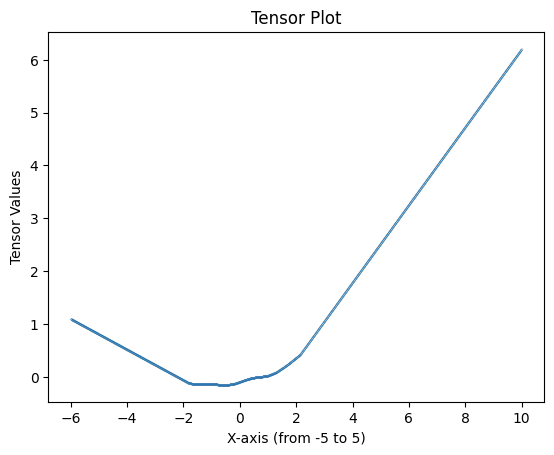

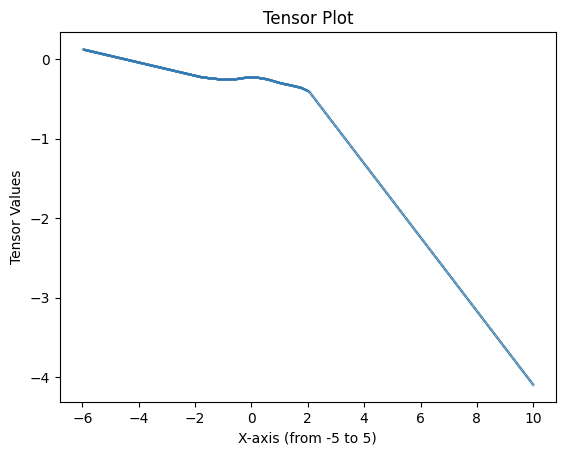

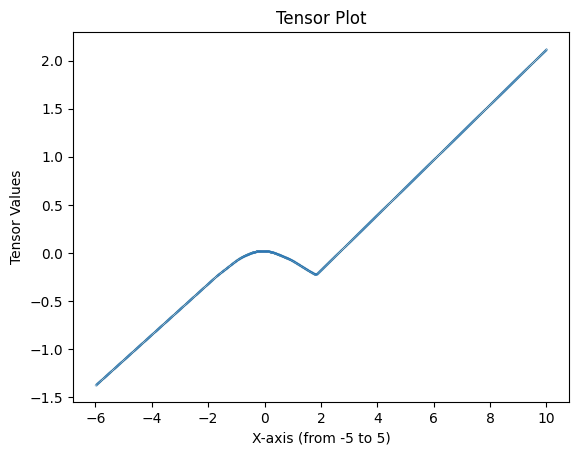

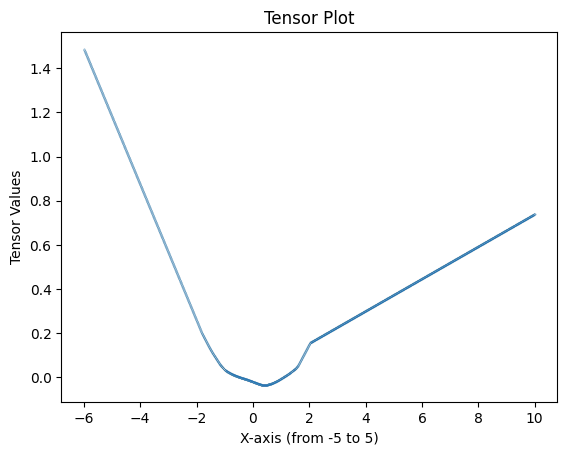

15


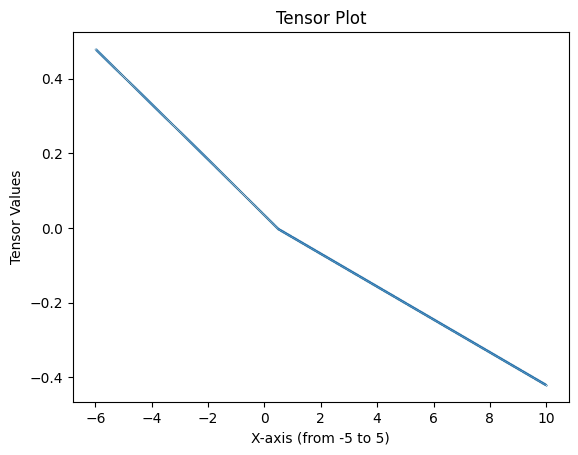

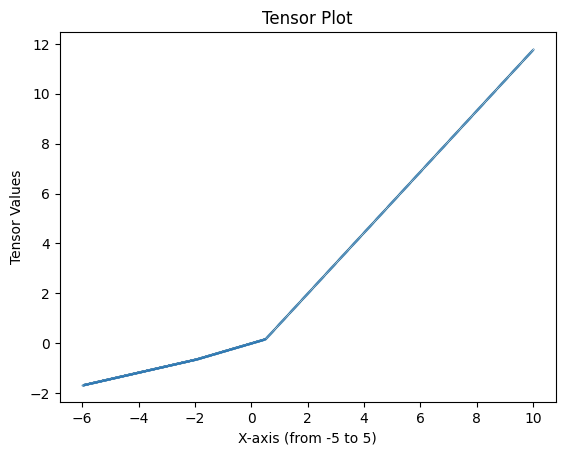

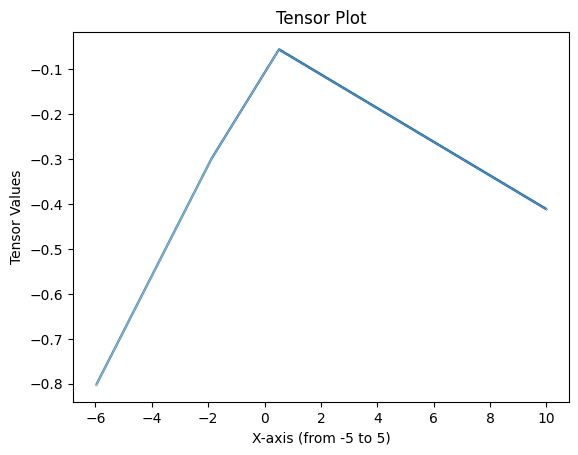

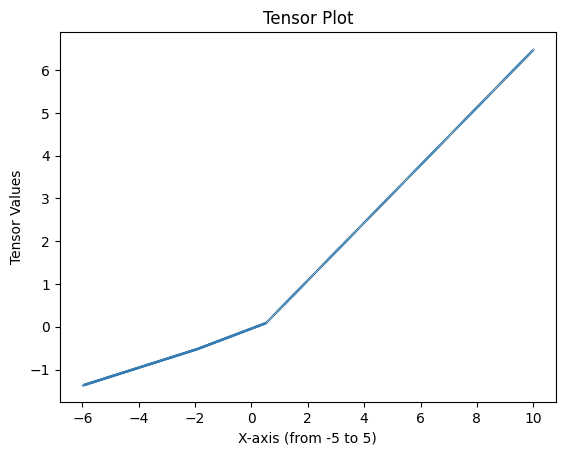

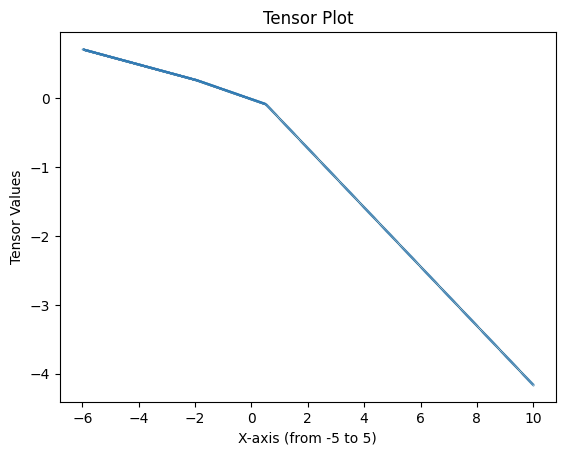

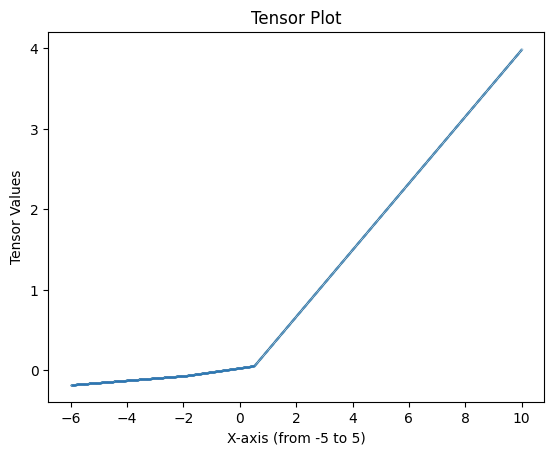

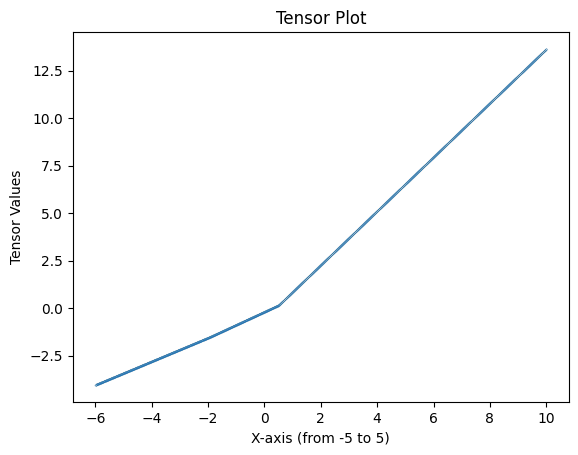

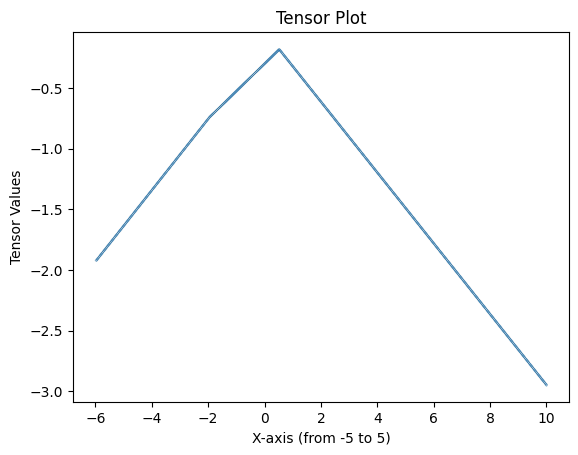

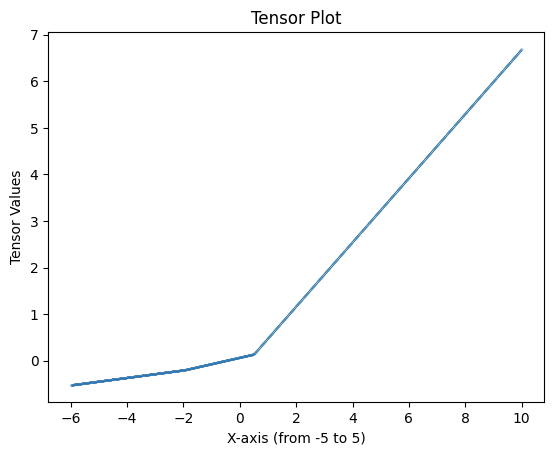

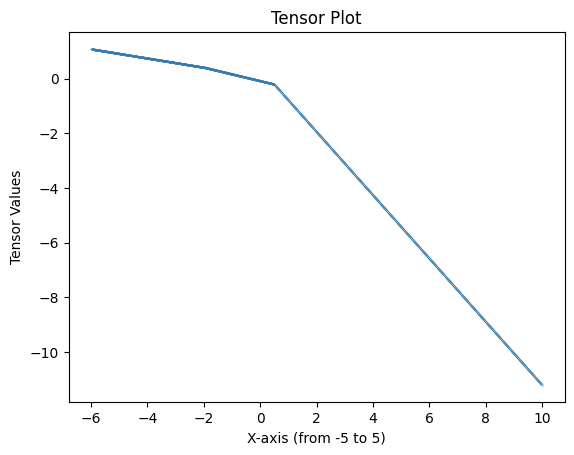

16


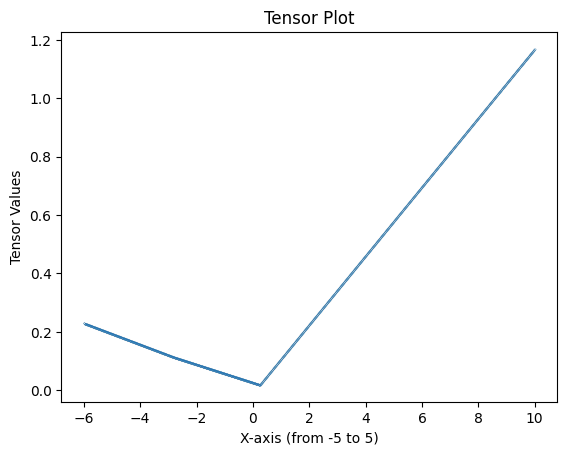

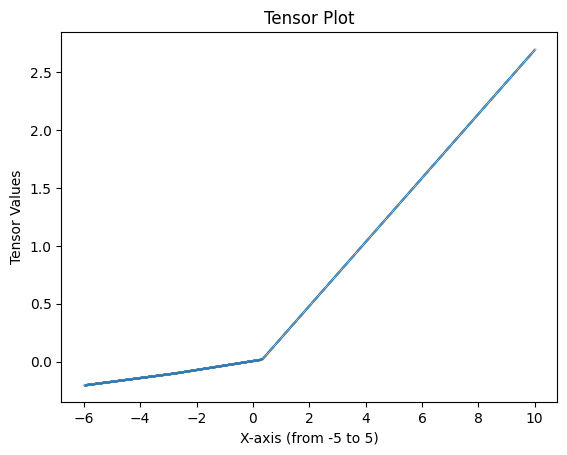

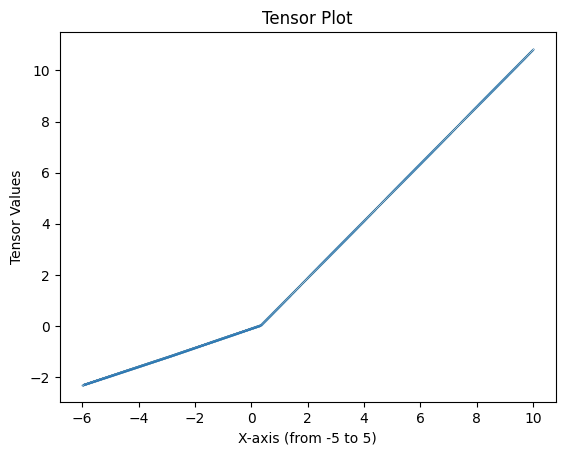

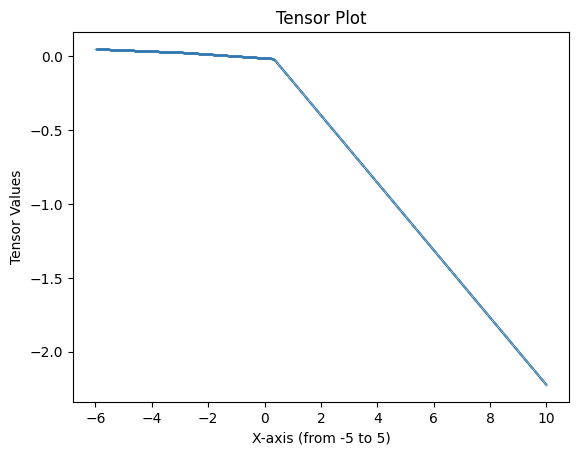

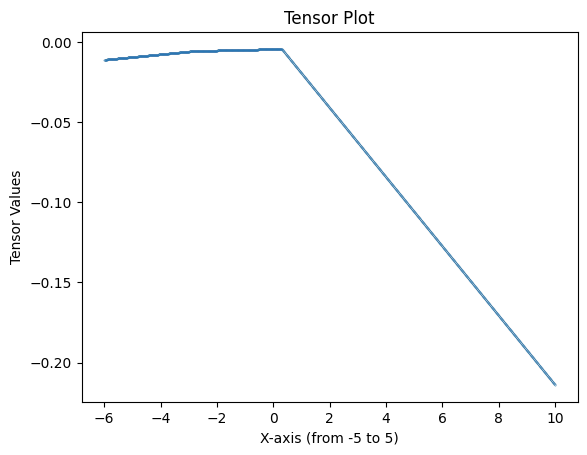

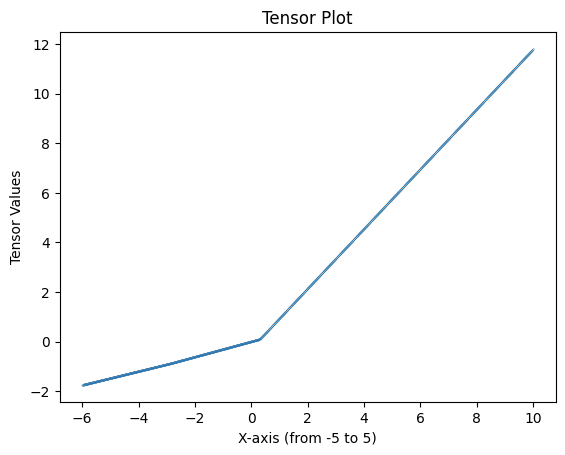

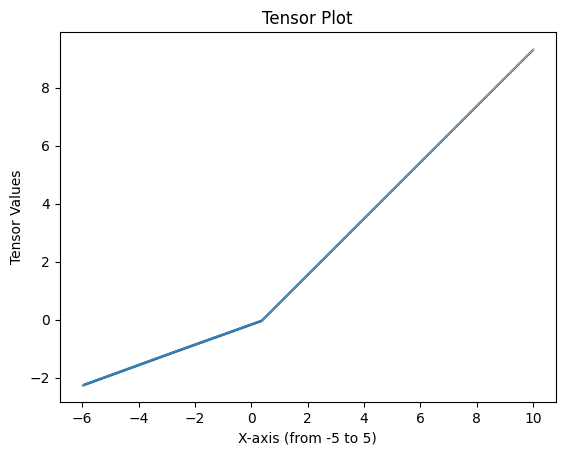

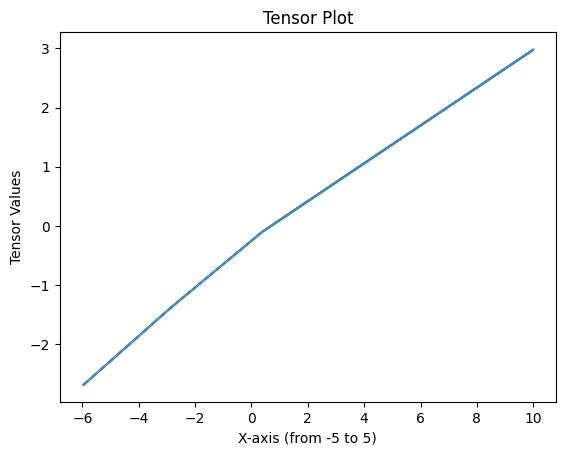

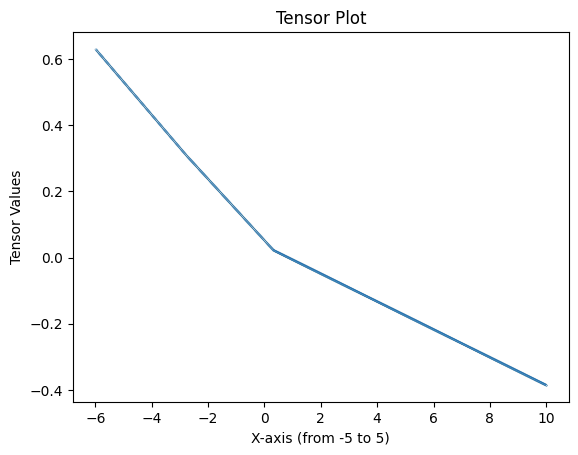

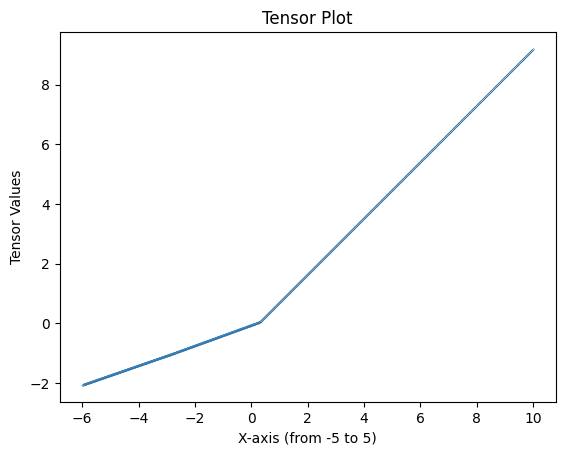

17


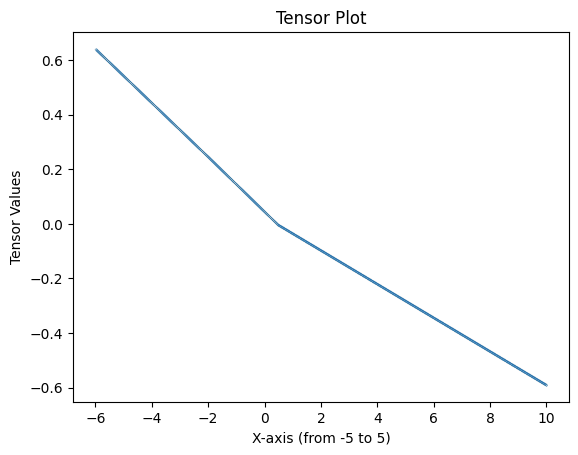

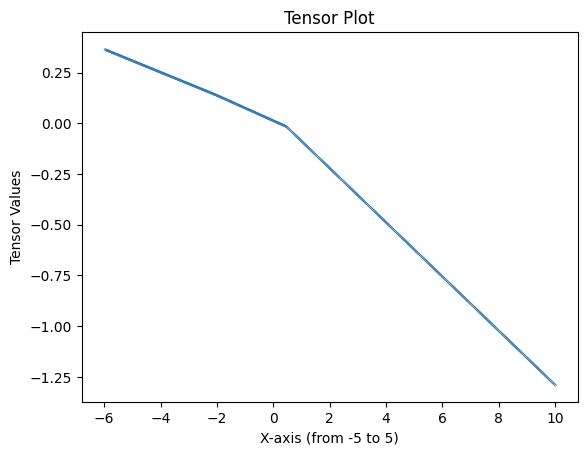

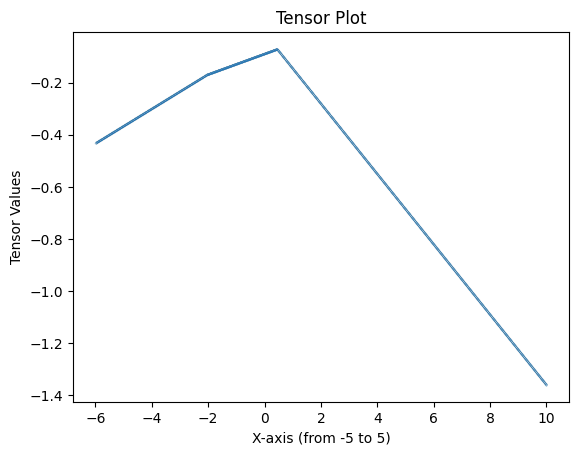

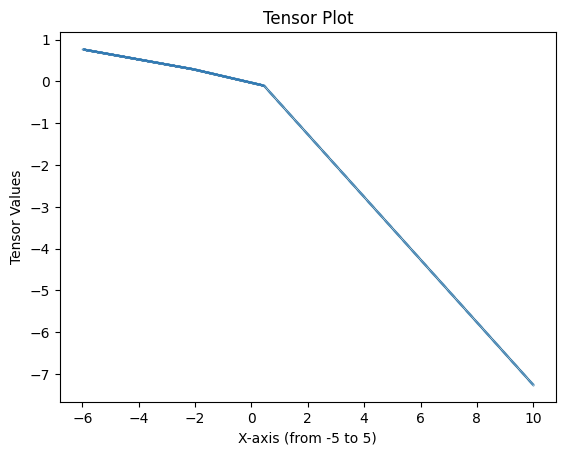

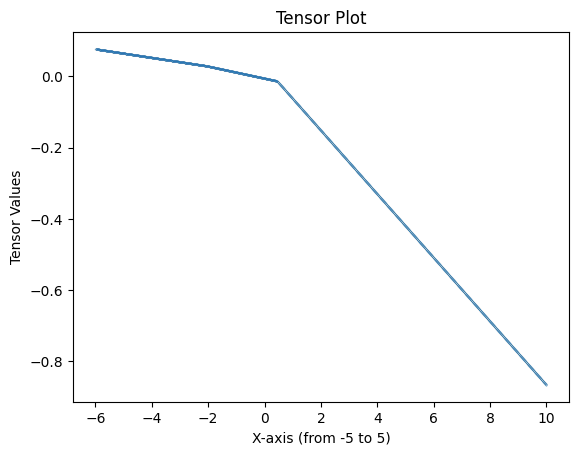

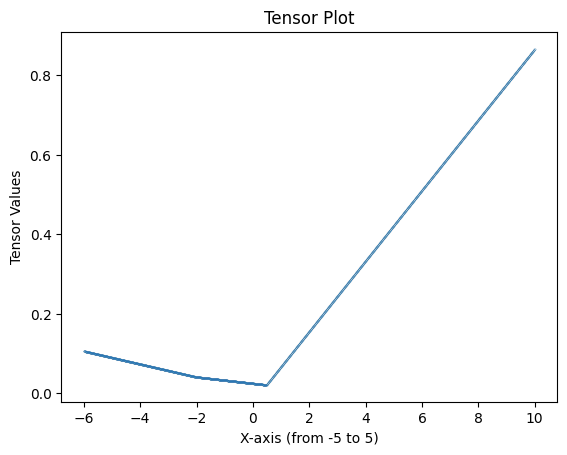

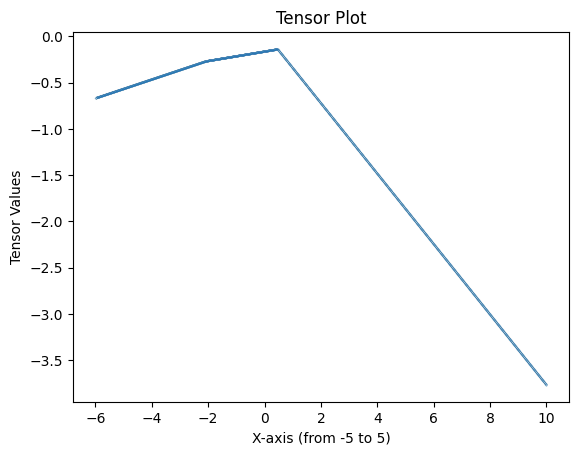

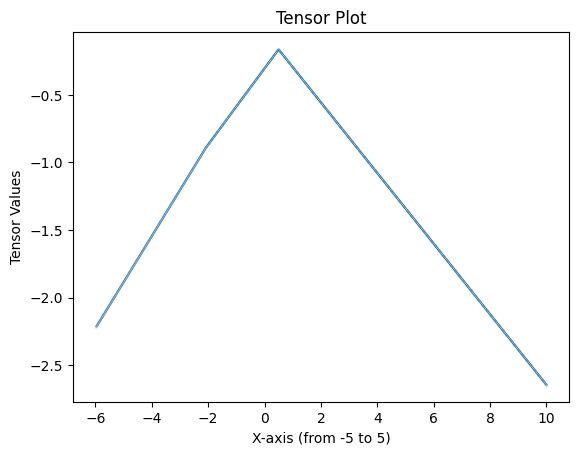

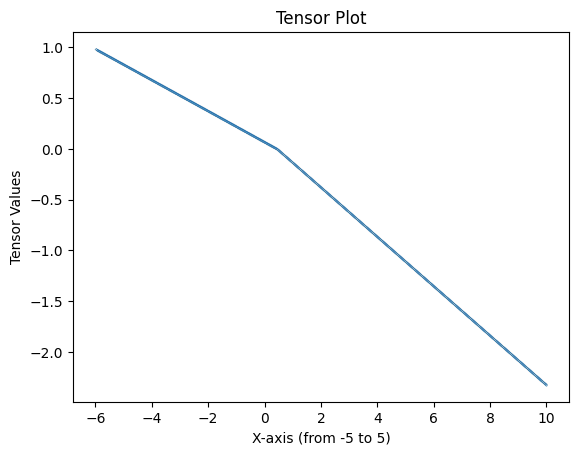

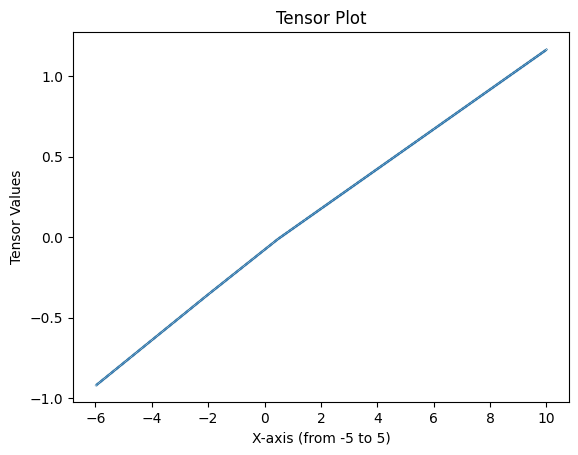

18


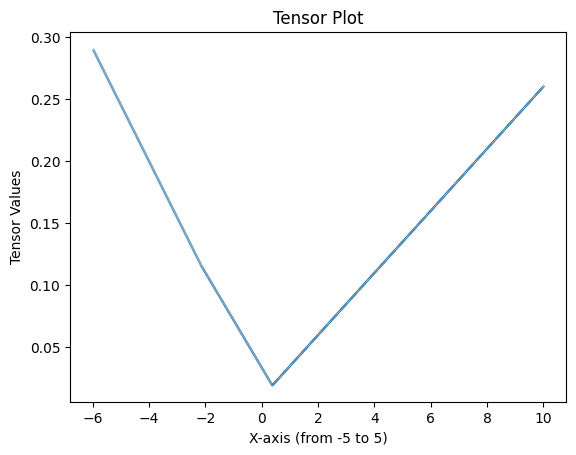

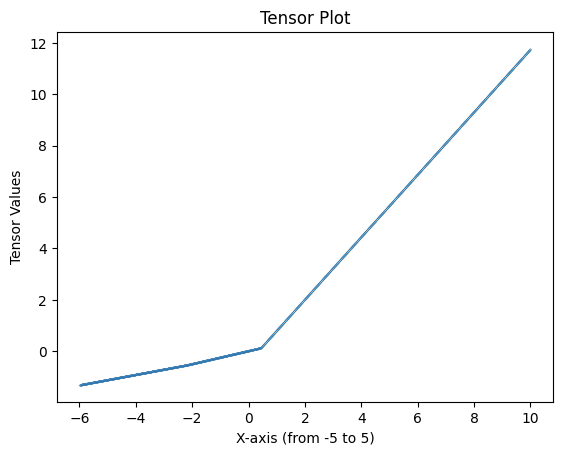

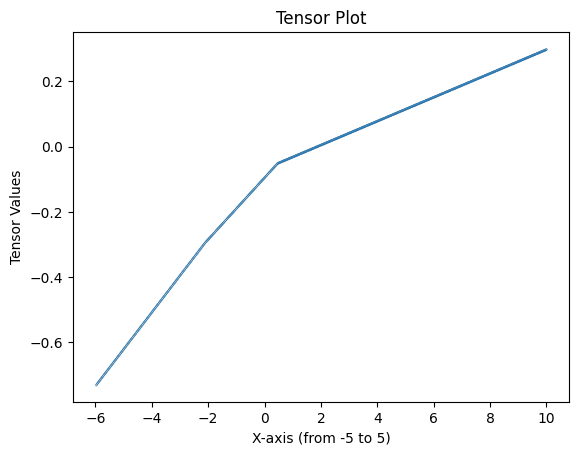

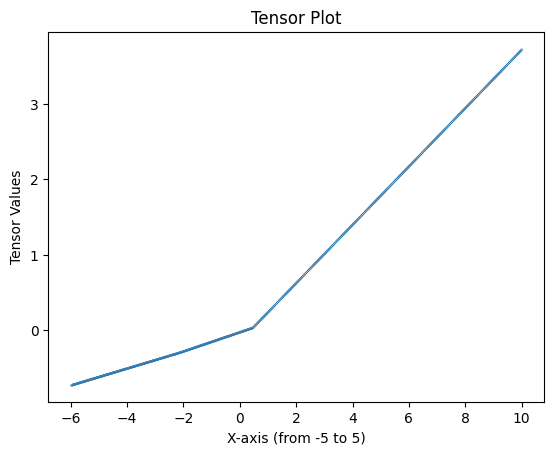

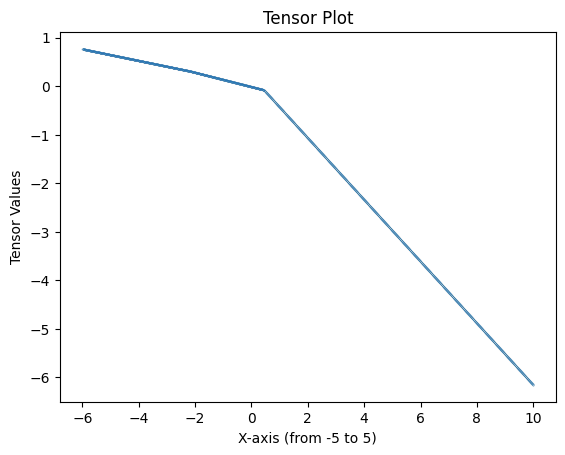

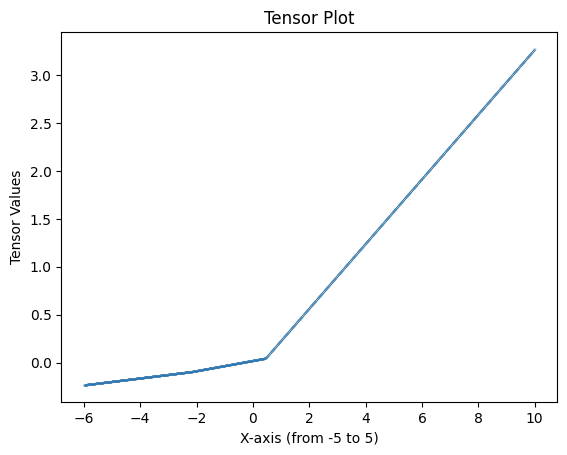

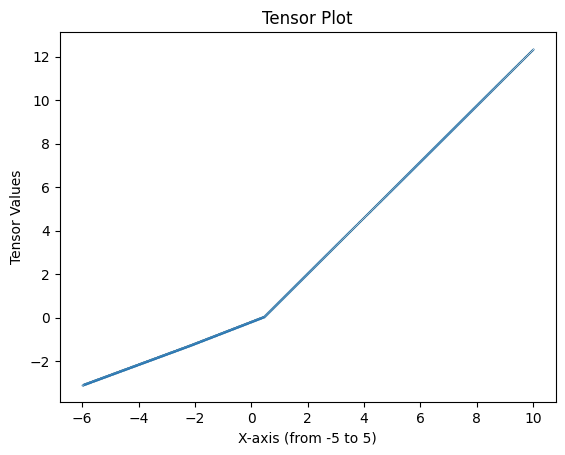

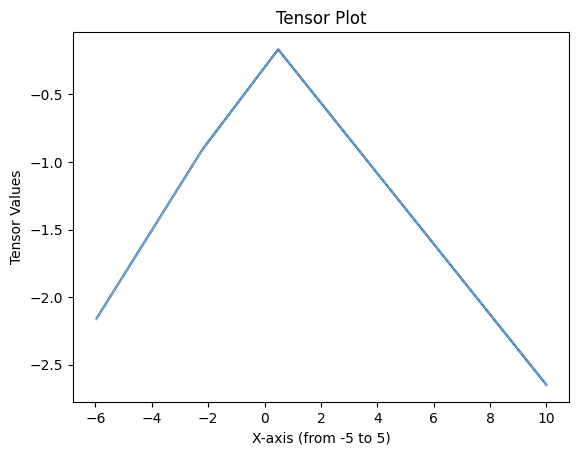

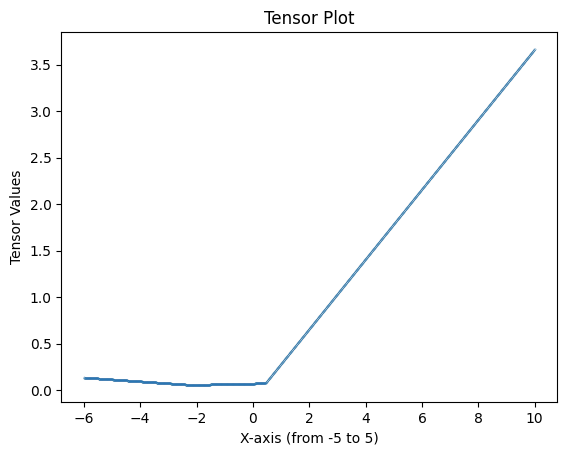

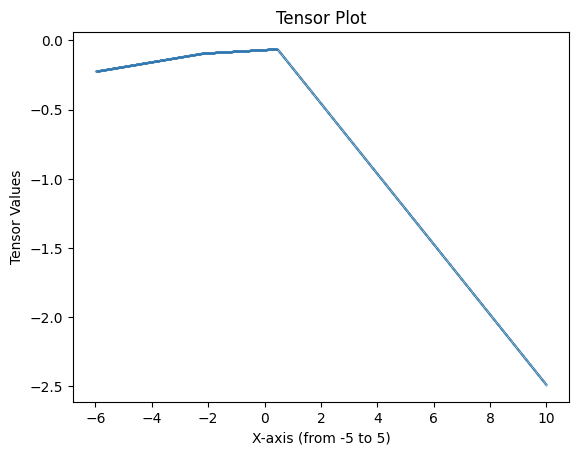

19


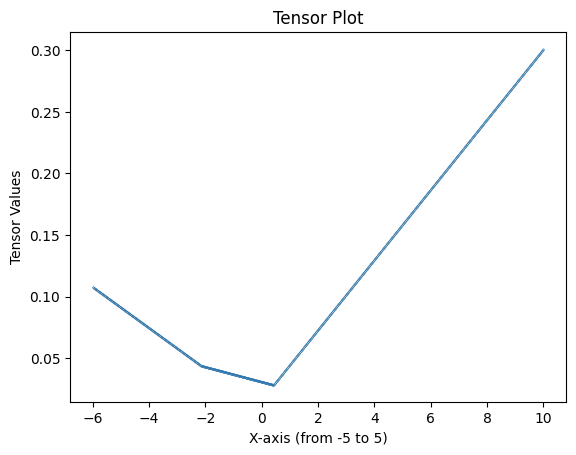

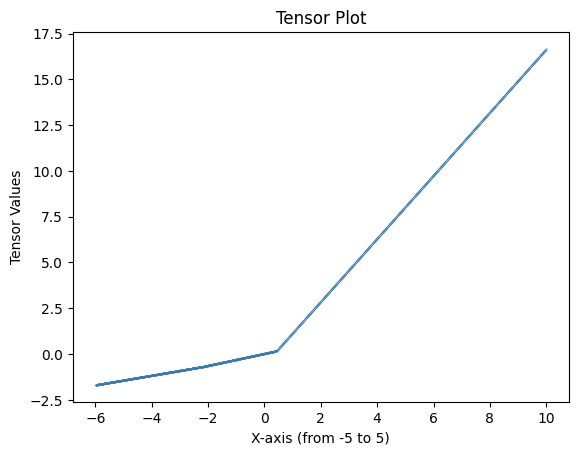

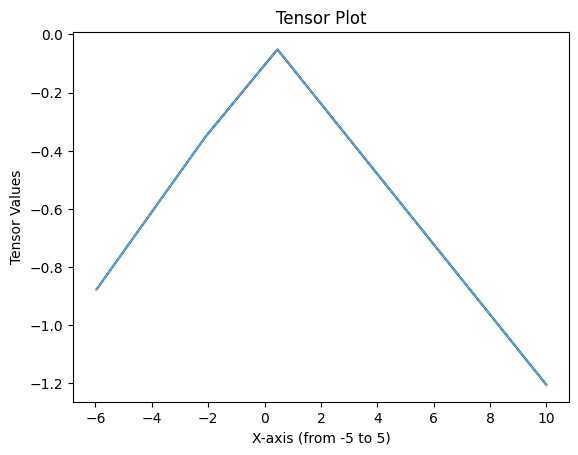

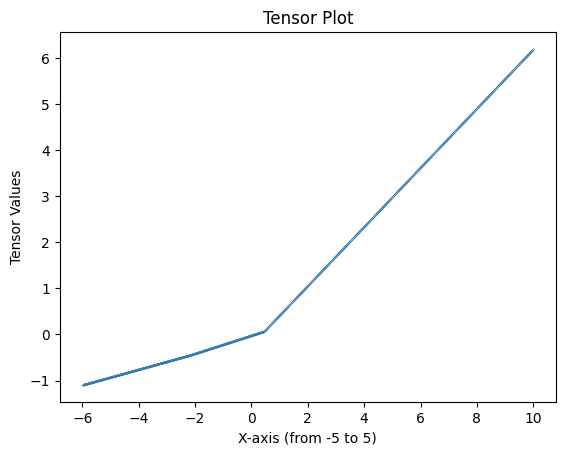

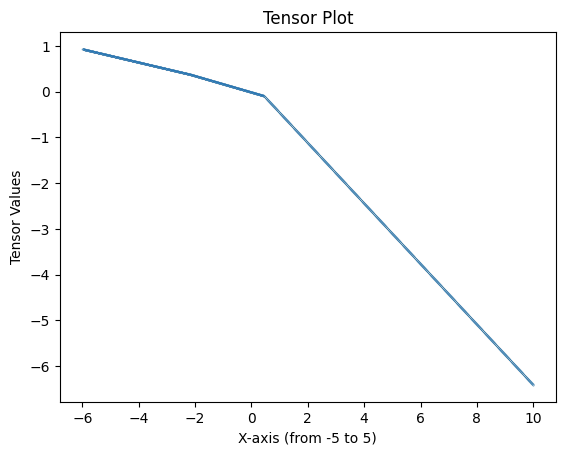

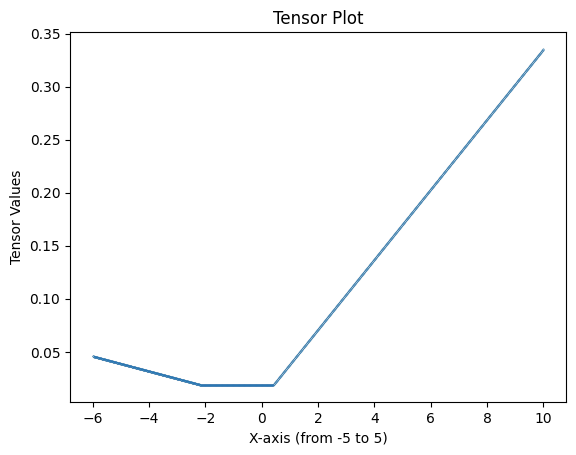

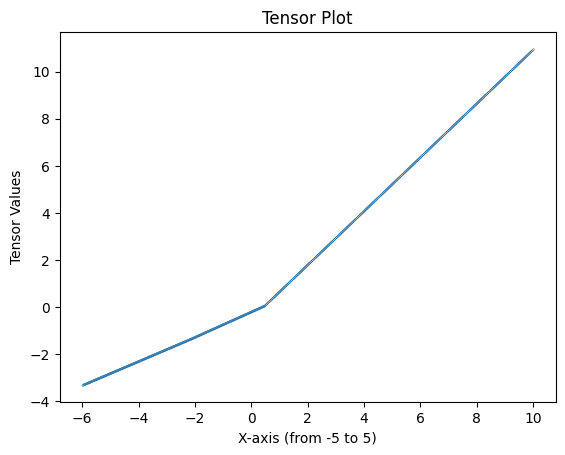

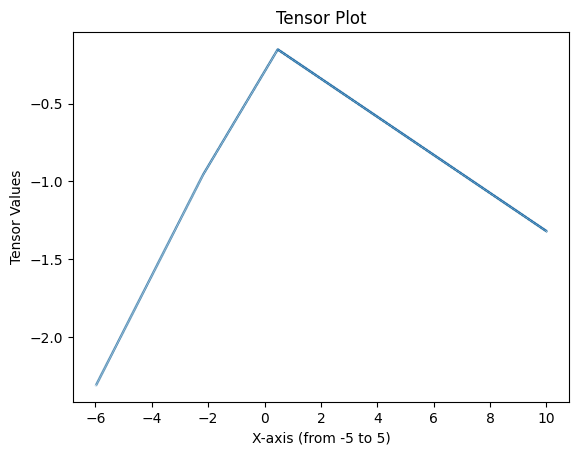

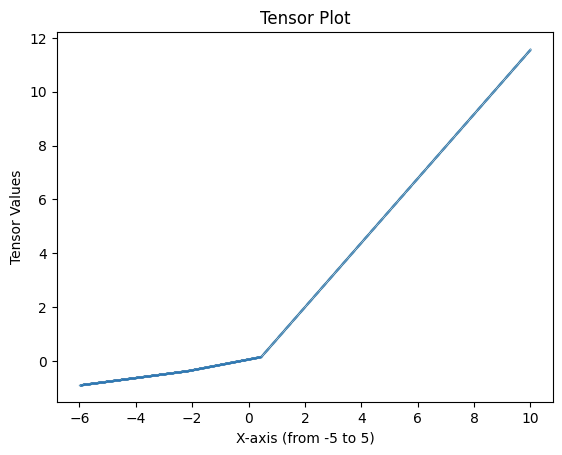

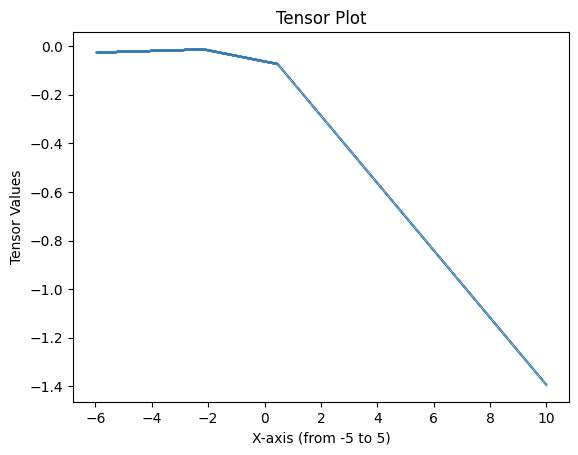

20


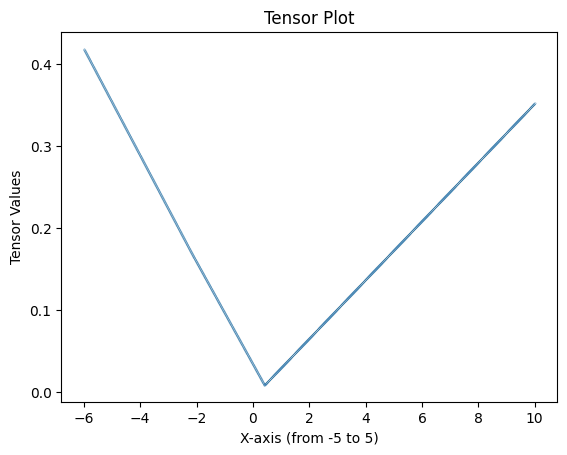

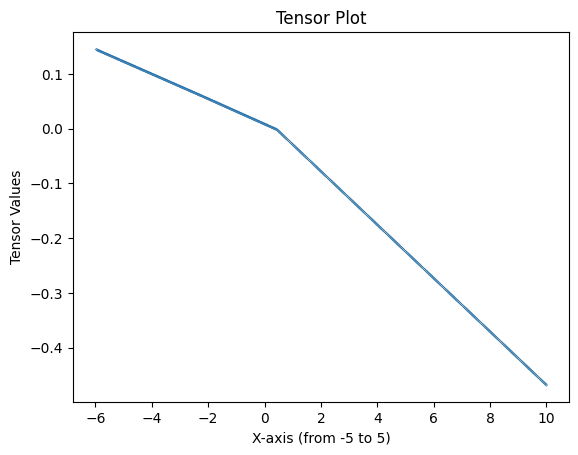

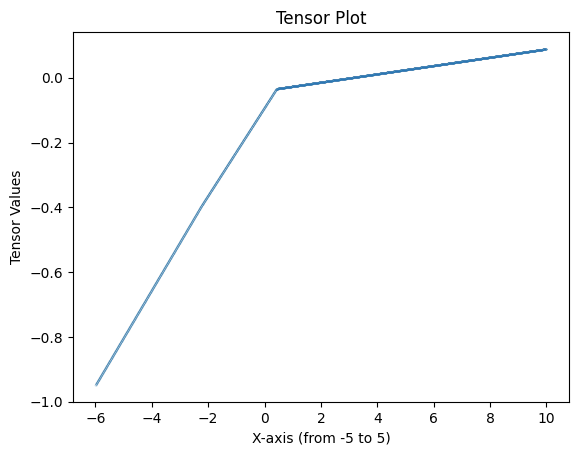

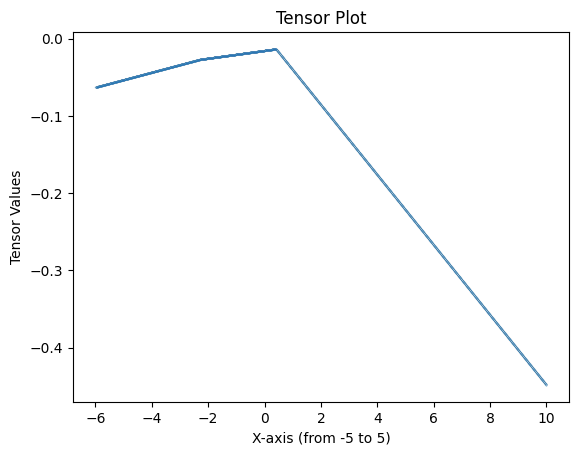

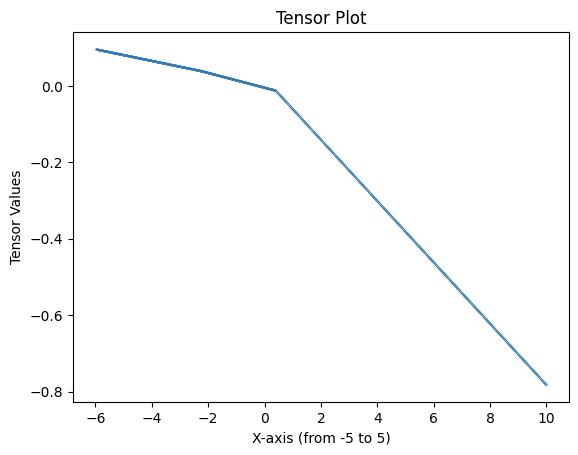

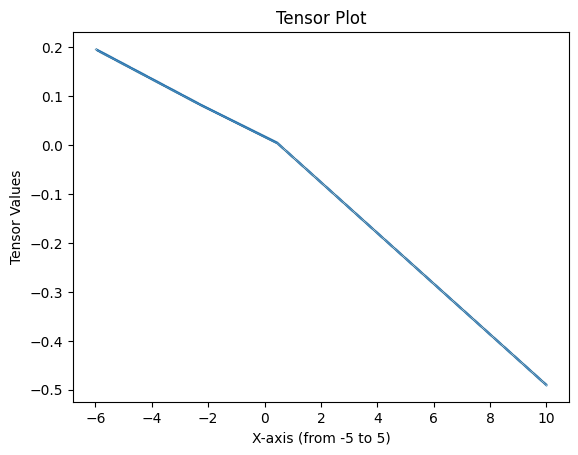

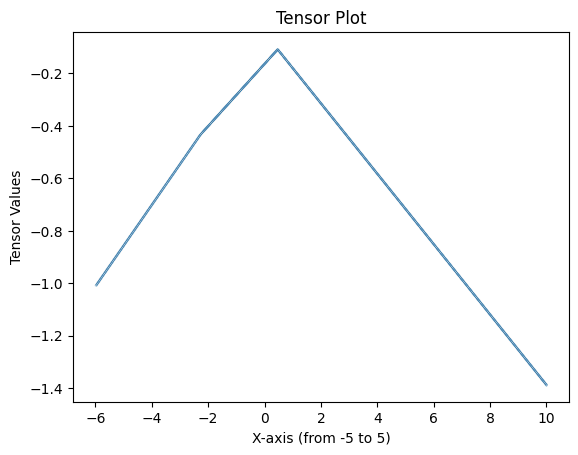

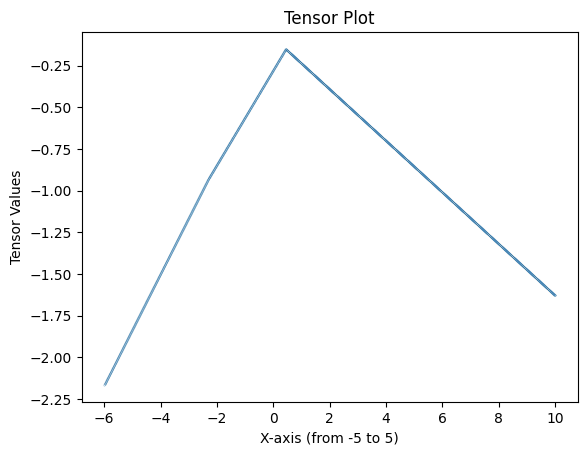

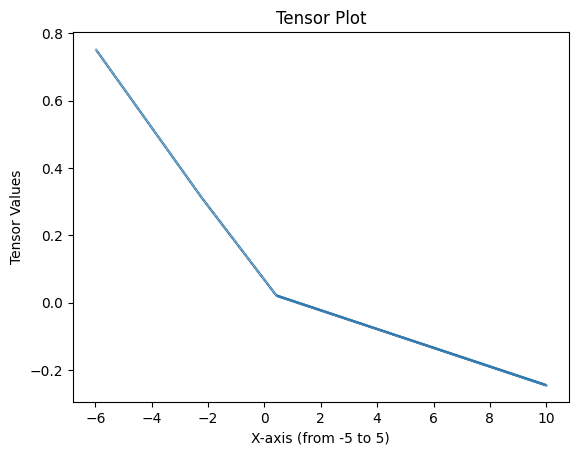

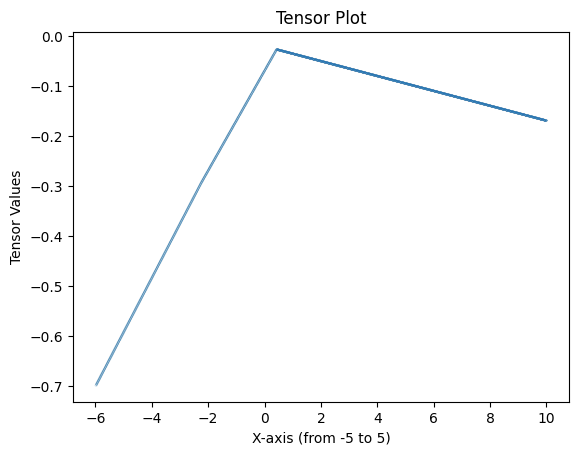

second_tensor


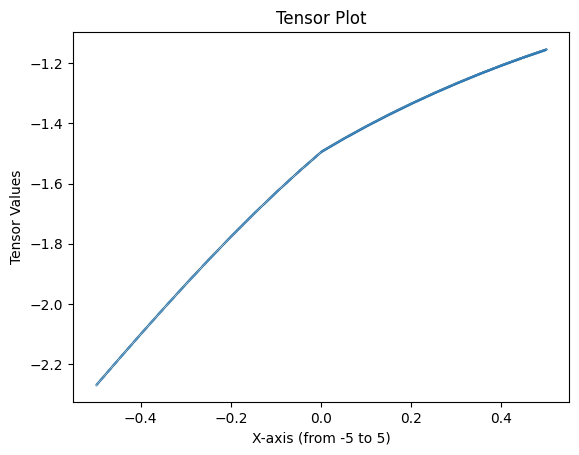

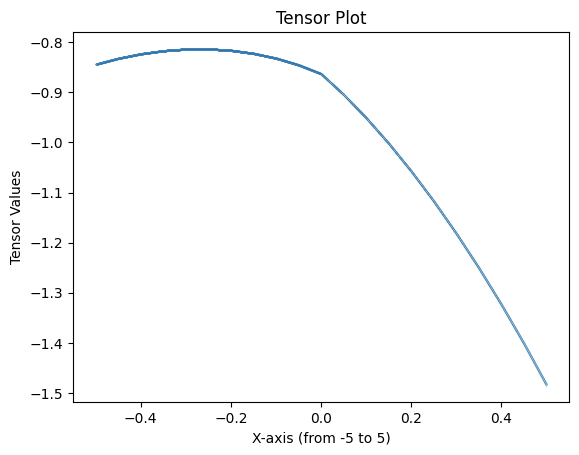

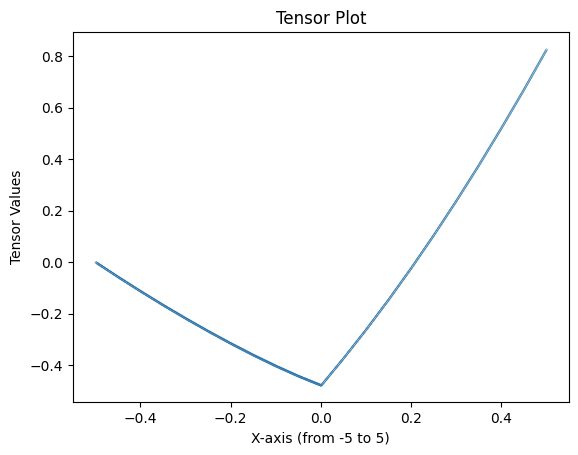

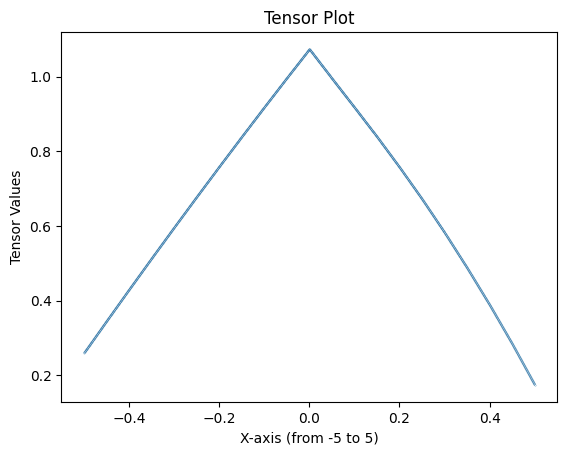

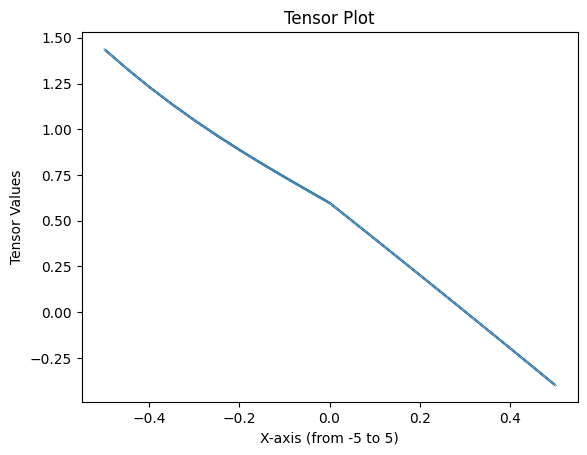

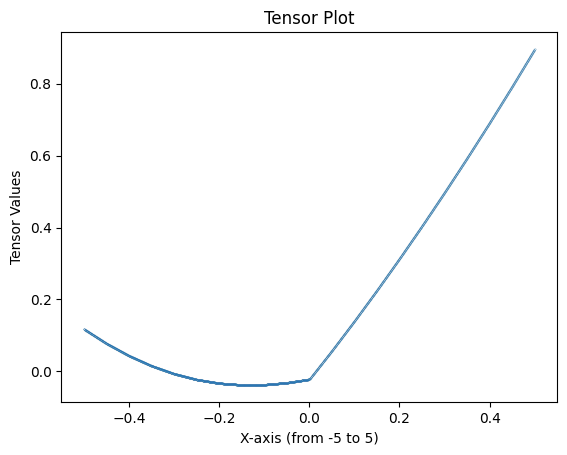

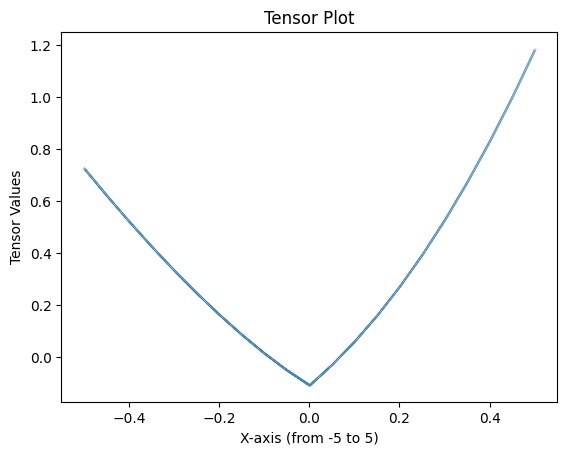

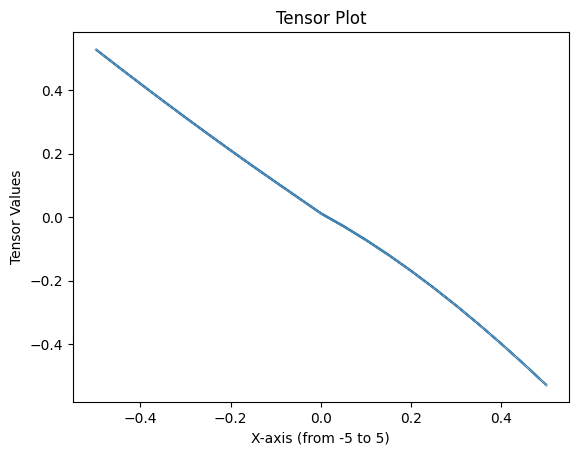

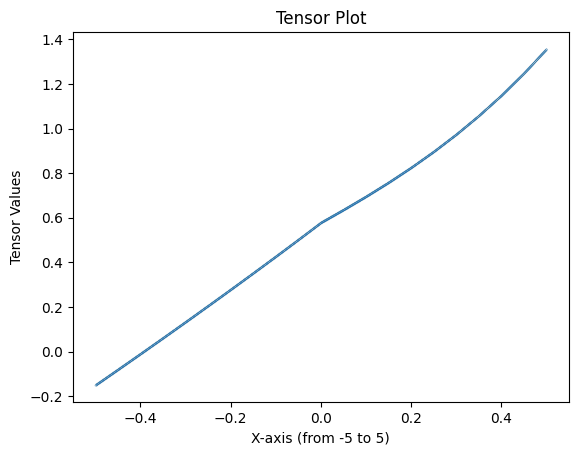

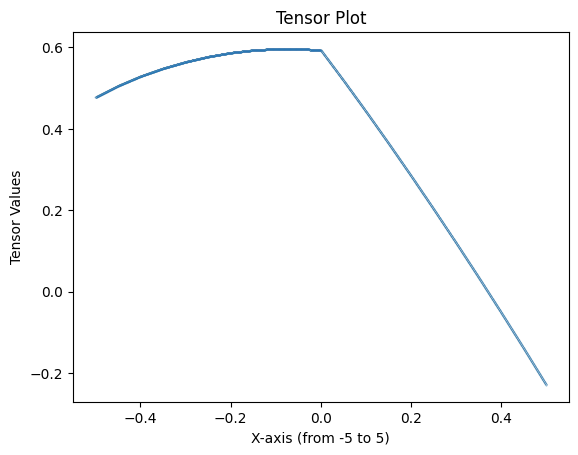

In [132]:
num_models = 10
n = 21

for j in range(n):
    print(j)
    for i in range(num_models):
        t_range = 10
        
        values = torch.linspace(-6, 10, steps=10000)
        result = values.unsqueeze(1).repeat(1, n).to(device)
        tensor = models[i].tensor_1(result)[:, j]

        x = np.linspace(-6, 10, len(tensor))
        
        # plt.plot(x, tensor.detach().numpy())
        plt.scatter(x, tensor.detach().cpu().numpy(), s=0.001)
        plt.xlabel("X-axis (from -5 to 5)")
        plt.ylabel("Tensor Values")
        plt.title("Tensor Plot")
        plt.show()

print("second_tensor")
for i in range(num_models):    
    t_range = 0.5
    values = torch.linspace(-t_range, t_range, steps=10000).to(device)
    tensor = models[i].tensor_2(values.unsqueeze(-1))
    
    x = np.linspace(-t_range, t_range, len(tensor))
    
    plt.scatter(x, tensor.detach().cpu().numpy(), s=0.001)
    plt.xlabel("X-axis (from -5 to 5)")
    plt.ylabel("Tensor Values")
    plt.title("Tensor Plot")
    plt.show()

In [ ]:
num_models = 1
n = 21

for j in range(n):
    print(j)
    for i in range(num_models):
        t_range = 10
        
        values = torch.linspace(-t_range, t_range, steps=10000)
        result = values.unsqueeze(1).repeat(1, n).to(device)
        tensor = models[i].tensor_1(result)[:, j]
                
        x = np.linspace(-t_range, t_range, len(tensor))
        
        # plt.plot(x, tensor.detach().numpy())
        plt.scatter(x, tensor.detach().cpu().numpy(), s=0.001)
        plt.xlabel("X-axis (from -5 to 5)")
        plt.ylabel("Tensor Values")
        plt.title("Tensor Plot")
        plt.show()

print("second_tensor")
for i in range(num_models):    
    t_range = 20
    values = torch.linspace(-t_range, t_range, steps=10000).to(device)
    tensor = models[i].tensor_2(values.unsqueeze(-1))
    
    x = np.linspace(-t_range, t_range, len(tensor))
    
    plt.scatter(x, tensor.detach().cpu().numpy(), s=0.001)
    plt.xlabel("X-axis (from -5 to 5)")
    plt.ylabel("Tensor Values")
    plt.title("Tensor Plot")
    plt.show()

In [ ]:
num_models = 1

for j in range(2):
    print(j)
    for i in range(num_models):
        t_range = 20
        values = torch.linspace(-t_range, t_range, steps=10000)
        result = torch.stack([values, values], dim=1).to(device)
        tensor = models[i].tensor_1(result)[:, j]
        
        # t_range = 40
        # values = torch.linspace(-t_range, t_range, steps=10000).to(device)
        # tensor = model3.tensor_2(values.unsqueeze(-1))
        
        x = np.linspace(-t_range, t_range, len(tensor))
        
        # plt.plot(x, tensor.detach().numpy())
        plt.scatter(x, tensor.detach().cpu().numpy(), s=0.2)
        plt.xlabel("X-axis (from -5 to 5)")
        plt.ylabel("Tensor Values")
        plt.title("Tensor Plot")
        plt.show()

print("second_tensor")
for i in range(num_models):    
    t_range = 40
    values = torch.linspace(-t_range, t_range, steps=10000).to(device)
    tensor = models[i].tensor_2(values.unsqueeze(-1))
    
    x = np.linspace(-t_range, t_range, len(tensor))
    
    # plt.plot(x, tensor.detach().numpy())
    plt.scatter(x, tensor.detach().cpu().numpy(), s=0.2)
    plt.xlabel("X-axis (from -5 to 5)")
    plt.ylabel("Tensor Values")
    plt.title("Tensor Plot")
    plt.show()

In [127]:
models = []

num_epochs = 1
num_features = 21
num_classes = 2

num_step_threshold = 100

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9995 ** (step - num_step_threshold)

start_time = time.time()

for i in range(10):
    model = TabularDenseNet(num_features, num_classes, 1, width=2, density=20).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001 * 1.0)
    scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)
    
    criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
    evaluate_model(model, custom_train_loader, criterion, optimizer, 0, scheduler, 13033, num_features)

    models.append(model)    

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

Execution time: 0.013566 seconds


In [129]:
class CombinedModel(nn.Module):
    def __init__(self, models):
        super(CombinedModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.ones(len(models)), requires_grad=True)

    def forward(self, x):
        outputs = torch.stack([model(x) for model in self.models], dim=-1) 
        weighted_sum = (outputs * self.weights).sum(dim=-1)
        output = weighted_sum / len(self.models)
        return output

combined_model = CombinedModel(models).to(device)

In [130]:
print(combined_model.weights)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       requires_grad=True)


In [131]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)
batch_size = 13033

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 300, scheduler, batch_size, num_features)

Learning Rate: 8.571428571428573e-06
Epoch 1, Training Loss: 0.5298189174045959, Validation Loss: 0.4876934161664336
Training Accuracy: 0.830556316799123, Training F1 Score: 0.7536766709053108
Validation Accuracy: 0.8305382001534583, Validation F1 Score: 0.7536512506063178

Learning Rate: 9.42857142857143e-05
Epoch 11, Training Loss: 0.33968723820485164, Validation Loss: 0.3292201366289841
Training Accuracy: 0.8616059194299808, Training F1 Score: 0.8264407650743183
Validation Accuracy: 0.8615038912638386, Validation F1 Score: 0.8260892800365349

Learning Rate: 0.00017999999999999998
Epoch 21, Training Loss: 0.278246860867675, Validation Loss: 0.27411412017708425
Training Accuracy: 0.8903809262811729, Training F1 Score: 0.8808924890960491
Validation Accuracy: 0.8929080346377288, Validation F1 Score: 0.8839237778028642

Learning Rate: 0.00026571428571428574
Epoch 31, Training Loss: 0.2643915344853537, Validation Loss: 0.259065385807845
Training Accuracy: 0.9007673335160318, Training F1 S

In [103]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)
batch_size = 13033

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 300, scheduler, batch_size, num_features)

Learning Rate: 8.571428571428573e-06
Epoch 1, Training Loss: 0.6208371424444671, Validation Loss: 0.5498188577611156
Training Accuracy: 0.830556316799123, Training F1 Score: 0.7536766709053108
Validation Accuracy: 0.8305382001534583, Validation F1 Score: 0.7536512506063178

Learning Rate: 9.42857142857143e-05
Epoch 11, Training Loss: 0.36100027129221496, Validation Loss: 0.3508360584544257
Training Accuracy: 0.8463825705672787, Training F1 Score: 0.7921257605313066
Validation Accuracy: 0.8459388359092403, Validation F1 Score: 0.7915332575697533

Learning Rate: 0.00017999999999999998
Epoch 21, Training Loss: 0.28065380053255257, Validation Loss: 0.2759114655028123
Training Accuracy: 0.8886681282543163, Training F1 Score: 0.8788569827598032
Validation Accuracy: 0.8917570974460156, Validation F1 Score: 0.882555540903246

Learning Rate: 0.00026571428571428574
Epoch 31, Training Loss: 0.2692493901175321, Validation Loss: 0.26510385855514595
Training Accuracy: 0.8967936420937243, Training F1

In [121]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)
batch_size = 13033

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 300, scheduler, batch_size, num_features)

Learning Rate: 8.571428571428573e-06
Epoch 1, Training Loss: 0.6103764970193467, Validation Loss: 0.5407346935697153
Training Accuracy: 0.830556316799123, Training F1 Score: 0.7536766709053108
Validation Accuracy: 0.8305382001534583, Validation F1 Score: 0.7536512506063178

Learning Rate: 9.42857142857143e-05
Epoch 11, Training Loss: 0.34714762603552185, Validation Loss: 0.3375509585007155
Training Accuracy: 0.8578240613866813, Training F1 Score: 0.8185542541597702
Validation Accuracy: 0.8571193686287405, Validation F1 Score: 0.8178228930309525

Learning Rate: 0.00017999999999999998
Epoch 21, Training Loss: 0.2823790196050648, Validation Loss: 0.27769350321828884
Training Accuracy: 0.8873938065223349, Training F1 Score: 0.8767012461514514
Validation Accuracy: 0.8902773210566699, Validation F1 Score: 0.8801449280122287

Learning Rate: 0.00026571428571428574
Epoch 31, Training Loss: 0.27215590127553635, Validation Loss: 0.26836670634942034
Training Accuracy: 0.8948204987667854, Training 

In [ ]:
batch_size = 10000
all_outputs = []

for start_idx in range(0, len(custom_train_loader.train_data_tensor), batch_size):
    end_idx = min(start_idx + batch_size, len(custom_train_loader.train_data_tensor))
    inputs = custom_train_loader.train_data_tensor[start_idx:end_idx].view(-1, num_features)
    labels = custom_train_loader.train_labels_tensor[start_idx:end_idx]

    optimizer.zero_grad()
    outputs = combined_model(inputs)
    
    all_outputs.append(outputs.detach())

final_outputs = torch.cat(all_outputs, dim=0)
quantiles = torch.linspace(0, 1, 10).to(device)

quantile_values = torch.quantile(final_outputs, quantiles, dim=0)
torch.set_printoptions(sci_mode=False)

print(quantile_values)

In [ ]:
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, batch_size, num_features)

In [ ]:
print(models[-3].bias_2)

In [ ]:
print(models[-2].bias_2)

In [ ]:
print(models[-1].bias_2)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)
batch_size = 13033

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, batch_size, num_features)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 10000, scheduler, 13033, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 0.1)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 13033, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 13033, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 13033, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 10.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 13033, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
# hard sigmoid
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 10.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 13033, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 700

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 2.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 13033, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.999 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 5.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 20, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.999 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 10.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 20, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.999 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 10.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 100, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.999 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 100, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 100, num_features)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.999 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 100, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.999 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 100, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 10000, scheduler, 1000 * 100, num_features)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.995 ** (step - num_step_threshold)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1000, scheduler, 1000 * 100, num_features)

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 10000, scheduler, 1000 * 100, num_features)

In [ ]:
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 10000, scheduler, 1000 * 100, num_features)

In [ ]:
a = 1
b = -1

test_tensor = torch.tensor([[a, b]]).to(device)
print(combined_model(test_tensor))

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

num_step_threshold = 100

def custom_lr_lambda(step):
    if step < num_step_threshold:
        return 1.005 ** step
    if step == num_step_threshold:
        print("here")
    return (1.005 ** num_step_threshold) * (0.9995 ** (step - num_step_threshold))

optimizer = optim.Adam(combined_model.parameters(), lr=0.001 * 1.0 / (1.005 ** num_step_threshold))
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

start_time = time.time()


torch.cuda.reset_max_memory_allocated(device='cuda:0')

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0)
evaluate_model(combined_model, custom_train_loader, criterion, optimizer, 1, scheduler, 1000 * 100, num_features)

print("Peak memory allocated:", torch.cuda.max_memory_allocated(device='cuda:0') / (1024 ** 2), "MB")

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
torch.cuda.reset_max_memory_allocated(device='cuda:0')
print("Peak memory allocated:", torch.cuda.max_memory_allocated(device='cuda:0') / (1024 ** 2), "MB")
